In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler 

from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score, train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

from sklearn.metrics import confusion_matrix, classification_report

import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, average_precision_score    

import warnings
warnings.filterwarnings('ignore')

In [30]:
print(f"LightGBM version: {lgb.__version__}")

LightGBM version: 4.6.0


In [2]:
print(f"NumPy версия: {np.__version__}")

NumPy версия: 1.26.4


# Понимание бизнеса и постановка задачи (Business Understanding & Problem Statement)

**Контекст бизнес-задачи**

**Клиент**: Страховая компания, предоставляющая медицинское страхование<br>
**Бизнес-проблема**: Необходимо выявить среди существующих клиентов с медицинской страховкой тех, кто с высокой вероятностью приобретет доп. услугу — страхование транспортных средств.

**Бизнес-ценность решения**

- Оптимизировать маркетинговые затраты — целенаправленно коммуницировать с наиболее перспективными клиентами
- Повысить конверсию продаж дополнительных продуктов
- Увеличить прибыльность от клиента (customer lifetime value) через расширение продуктового портфеля

**Постановка задачи машинного обучения**

**Задача:** Бинарная классификация<br>
**Целевая переменная:** Response (1 — клиент заинтересован в автостраховании, 0 — не заинтересован)<br>
**Метрика оценки:** ROC-AUC — выбрана для оценки качества ранжирования клиентов по вероятности положительного отклика<br>
**Источник данных:** [Kaggle Competition:] (https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction "Health Insurance Cross Sell Prediction")

**Данные для анализа**

Набор данных содержит информацию о 381109 клиентах с 11 признаками:

Категория признаков	| Переменные	                                            | Описание
--------------------|-----------------------------------------------------------|-------------------------------------------------
Демографические	    | Gender, Age, Region_Code	                                | Пол, возраст, регион клиента    
Автомобильные	    | Vehicle_Age, Vehicle_Damage	                            | Возраст ТС и история повреждений
Страховые	        | Previously_Insured, Annual_Premium, Policy_Sales_Channel	| Наличие автостраховки, годовая премия, канал продаж
Лояльность	        | Vintage	                                                | Количество дней сотрудничества с компанией
Административные	| Driving_License	                                        | Наличие водительских прав
Идентификатор	    | id	                                                    | Уникальный ID клиента

**Особенности задачи**

- Сильная несбалансированность классов: только 12.2% клиентов проявили интерес к автострахованию в обучающей выборке 
- Разнородность признаков: смесь числовых, категориальных и бинарных переменных

**Требования к решению**

**Формат результата:** Файл submission.csv должен содержать вероятности класса 1 (Response=1)<br>
**Воспроизводимость:** Предоставление кода для воспроизведения результатов<br>
**Оценка:** Метрика ROC-AUC 

# Загрузка данных (Data Loading & First Look)

In [2]:
df_train = pd.read_csv('./data/processed/train.csv')
df_train.drop(['id'],axis=1,inplace=True)
df_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
df_test = pd.read_csv('./data/processed/test.csv')
#df_test.drop(['id'],axis=1,inplace=True)
df_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


# Разведочный анализ (Exploratory Data Analysis (EDA))

In [7]:
df_train.shape

(381109, 12)

In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [25]:
df_train.isna().sum() # Проверка на пустые значения

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [9]:
df_train.nunique()

id                      381109
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           48838
Policy_Sales_Channel       155
Vintage                    290
Response                     2
dtype: int64

-------------------------------------------------------------------------------------------------------------------------------------------------------
Обучающая выборка содержит 381 109 записей. Пропущенные значения отсутствуют. Датасет включает 11 колонок: 10 признаков, целевая переменная "Response" и идентификатор "id".

Структура признаков:

Бинарные категориальные (4 признака):
- Gender (Пол)
- Driving_License (Наличие водительских прав)
- Previously_Insured (Ранее застрахован)
- Vehicle_Damage (Повреждение автомобиля в прошлом)


Многоклассовые категориальные (3 признака):
- Region_Code (Код региона)
- Vehicle_Age (Возраст автомобиля)
- Policy_Sales_Channel (Канал продаж полиса)

Числовые признаки (3 признака):
- Age (Возраст)
- Annual_Premium (Годовая премия)
- Vintage (Время взаимодействия с компанией, в днях)

Целевая переменная:
Response — бинарная целевая переменная (1 — отклик, 0 — отсутствие отклика)

Идентификатор:
id — уникальный порядковый номер записи

## Анализ категориальных переменных

In [51]:
# Проверка баланса категориальных признаков
categorical_cols = ['Gender', 'Driving_License', 'Previously_Insured', 
                    'Vehicle_Damage', 'Region_Code', 'Vehicle_Age', 
                    'Policy_Sales_Channel']

for col in categorical_cols:
    print(f"\n{col}:")
    print(df_train[col].value_counts(normalize=True).head())
    print(f"Уникальных значений: {df_train[col].nunique()}")


Gender:
Gender
Male      0.540761
Female    0.459239
Name: proportion, dtype: float64
Уникальных значений: 2

Driving_License:
Driving_License
1    0.997869
0    0.002131
Name: proportion, dtype: float64
Уникальных значений: 2

Previously_Insured:
Previously_Insured
0    0.54179
1    0.45821
Name: proportion, dtype: float64
Уникальных значений: 2

Vehicle_Damage:
Vehicle_Damage
Yes    0.504877
No     0.495123
Name: proportion, dtype: float64
Уникальных значений: 2

Region_Code:
Region_Code
28.0    0.279225
8.0     0.088891
46.0    0.051820
41.0    0.047921
15.0    0.034919
Name: proportion, dtype: float64
Уникальных значений: 53

Vehicle_Age:
Vehicle_Age
1-2 Year     0.525613
< 1 Year     0.432385
> 2 Years    0.042001
Name: proportion, dtype: float64
Уникальных значений: 3

Policy_Sales_Channel:
Policy_Sales_Channel
152.0    0.353663
26.0     0.209127
124.0    0.194157
160.0    0.057146
156.0    0.027974
Name: proportion, dtype: float64
Уникальных значений: 155


In [13]:
# Смотрим, как ведет себя миноритарный класс признака Vehicle_Age
age_stats = df_train.groupby('Vehicle_Age').agg({
    'Response': ['mean', 'count', 'std'],
    'Annual_Premium': 'mean',
    'Previously_Insured': 'mean'
}).round(4)

print(age_stats)

            Response                 Annual_Premium Previously_Insured
                mean   count     std           mean               mean
Vehicle_Age                                                           
1-2 Year      0.1738  200316  0.3789     30523.5821             0.3261
< 1 Year      0.0437  164786  0.2044     30119.5520             0.6630
> 2 Years     0.2937   16007  0.4555     35654.4995             0.0029


Признак Driving_License практически константа — бесполезен для модели. Удаляем Driving_License.

Бинарные признаки Gender, Previously_Insured, Vehicle_Damage сбалансированы и будут закодированы с помощью Label Encoding. 

Многоклассовые категориальные признаки Region_Code и Policy_Sales_Channel имеют сильный разбалланс значений. К ним будет применено кодирование Frequency encoded. При этом кодировании частота встречаемости класса преобразуется в значение. Т.о., эти признаки будут показывать вероятность ("популярность") значения.

Признак Vehicle_Age содержит 3 класса значений и является порядковым. Классы "1-2 Year" и "< 1 Year" хорошо сбалансированы, а класс "> 2 Years" является миноритарным. Однако, класс "> 2 Years" имеет высокое среднее значение по целевой переменной относительно остальных классов. Т.е., этот класс "> 2 Years" - сильный предиктор, содержит высокую информативность и его нельзя объединять с другим классом. Поэтому, к признаку Vehicle_Age будем применять One-Hot Encoding или Target Encoding.

In [54]:
# Проверка дисбаланса целевой переменной
print(f"Распределение целевой переменной:")
print(df_train['Response'].value_counts(normalize=True))

Распределение целевой переменной:
Response
0    0.877437
1    0.122563
Name: proportion, dtype: float64


Дисбаланс целевой переменной 7.15:1
Будем использовать LightGBM/XGBoost модели, т.к. они автоматически оптимизируют AUC и умеют работать с дисбалансом через scale_pos_weight.

## Анализ числовых признаков

In [20]:
df_train[['Age', 'Annual_Premium', 'Vintage']].describe().T.round(2) # описательная статистика

,count,mean,std,min,25%,50%,75%,max
Age,381109.0,38.82,15.51,20.0,25.0,36.0,49.0,85.0
Annual_Premium,381109.0,30564.39,17213.16,2630.0,24405.0,31669.0,39400.0,540165.0
Vintage,381109.0,154.35,83.67,10.0,82.0,154.0,227.0,299.0


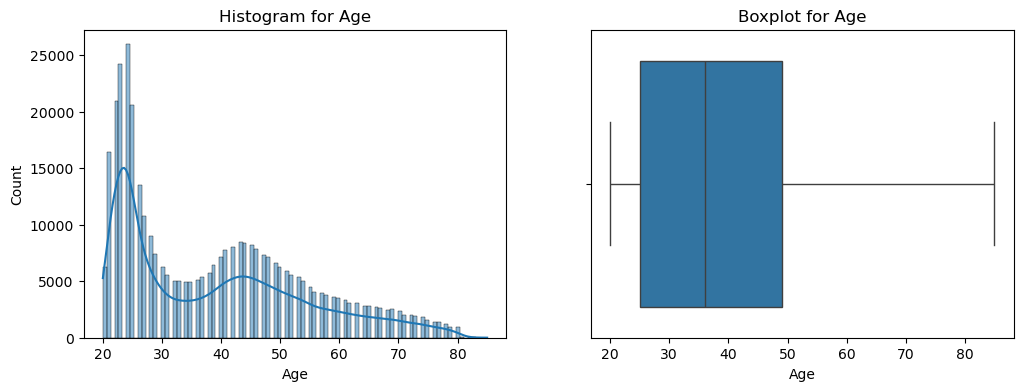

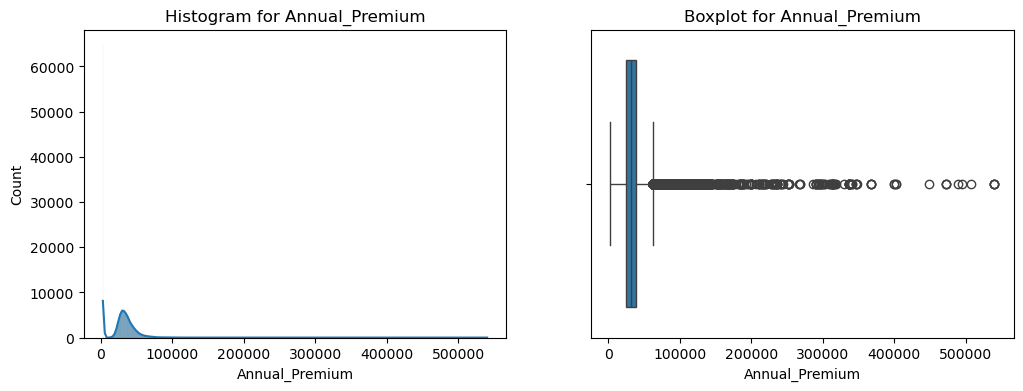

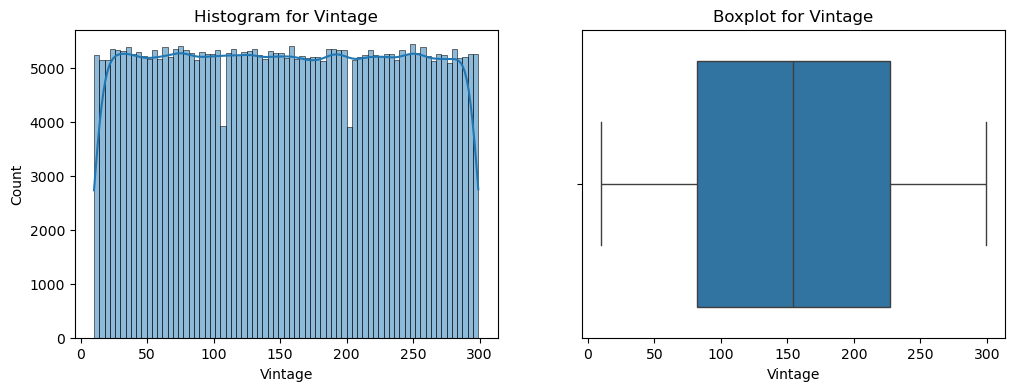

In [8]:
numeric_cols = ['Age', 'Annual_Premium', 'Vintage']

# гистограммы и диаграммы ящика с усами распределения каждой из переменной 
for col in numeric_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df_train[col], ax=ax1, kde=True)
    ax1.set_title(f'Histogram for {col}')
    sns.boxplot(x=df_train[col], ax=ax2)
    ax2.set_title(f'Boxplot for {col}')
    plt.show()

<Axes: xlabel='Response', ylabel='Age'>

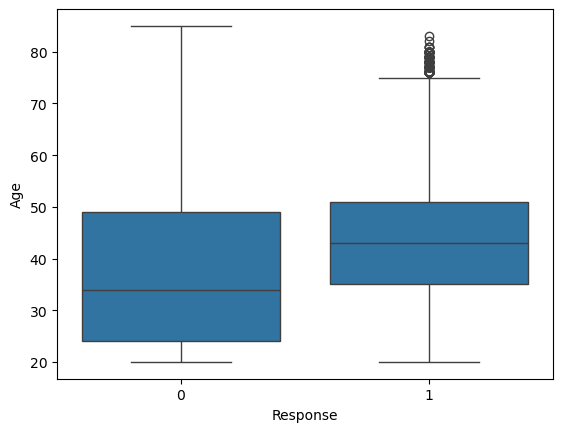

In [22]:
sns.boxplot(y='Age', x=df_train['Response'].astype('category'), data=df_train)

<Axes: xlabel='Response', ylabel='Vintage'>

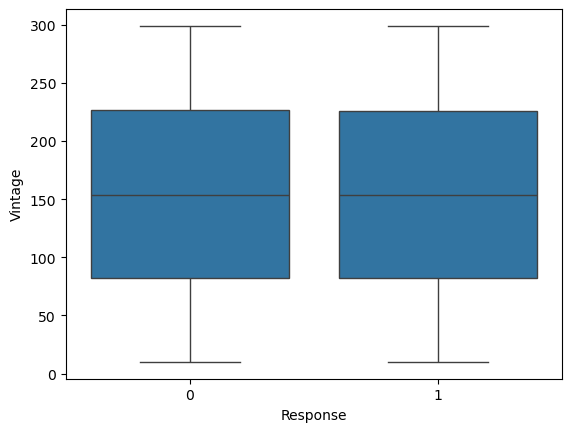

In [23]:
sns.boxplot(y='Vintage', x=df_train['Response'].astype('category'), data=df_train) 

<Axes: xlabel='Response', ylabel='Annual_Premium'>

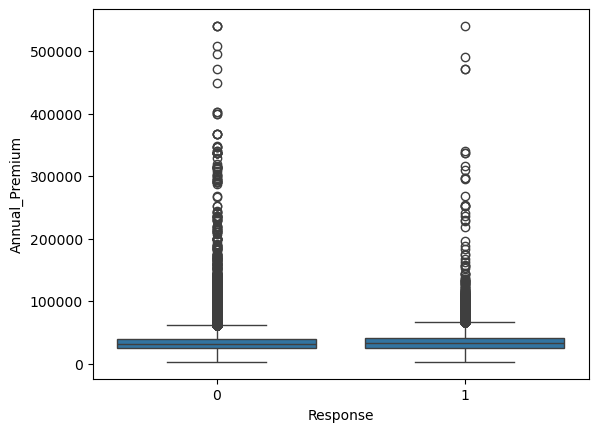

In [24]:
sns.boxplot(y='Annual_Premium', x=df_train['Response'].astype('category'), data=df_train)

In [27]:
for col in numeric_cols:
    print(f"\n=== {col} ===")
    stats = df_train.groupby('Response')[col].agg(['mean', 'std', 'min', 'max', 'count'])
    print(stats)
    
    # Проверяем статистическую значимость различий
    from scipy import stats
    group_0 = df_train[df_train['Response'] == 0][col]
    group_1 = df_train[df_train['Response'] == 1][col]
    
    t_stat, p_value = stats.ttest_ind(group_0, group_1, equal_var=False)
    print(f"T-test p-value: {p_value:.6f}")
    print(f"Significant difference (p < 0.05): {'YES' if p_value < 0.05 else 'NO'}")


=== Age ===
               mean        std  min  max   count
Response                                        
0         38.178227  15.816052   20   85  334399
1         43.435560  12.168924   20   83   46710
T-test p-value: 0.000000
Significant difference (p < 0.05): YES

=== Annual_Premium ===
                  mean           std     min       max   count
Response                                                      
0         30419.160276  16998.293197  2630.0  540165.0  334399
1         31604.092742  18646.508040  2630.0  540165.0   46710
T-test p-value: 0.000000
Significant difference (p < 0.05): YES

=== Vintage ===
                mean        std  min  max   count
Response                                         
0         154.380243  83.661975   10  299  334399
1         154.112246  83.738574   10  299   46710
T-test p-value: 0.516995
Significant difference (p < 0.05): NO


In [10]:
# Тест на проверку нормальности распределения
from scipy.stats import normaltest

for col in numeric_cols:
    print(f'{col}: {normaltest(df_train[col])}')

Age: NormaltestResult(statistic=np.float64(34258.3676703848), pvalue=np.float64(0.0))
Annual_Premium: NormaltestResult(statistic=np.float64(209344.5220951878), pvalue=np.float64(0.0))
Vintage: NormaltestResult(statistic=np.float64(340598.37657391053), pvalue=np.float64(0.0))


Корреляция с Response:
Age               0.111147
Annual_Premium    0.022575
Vintage          -0.001050
Name: Response, dtype: float64


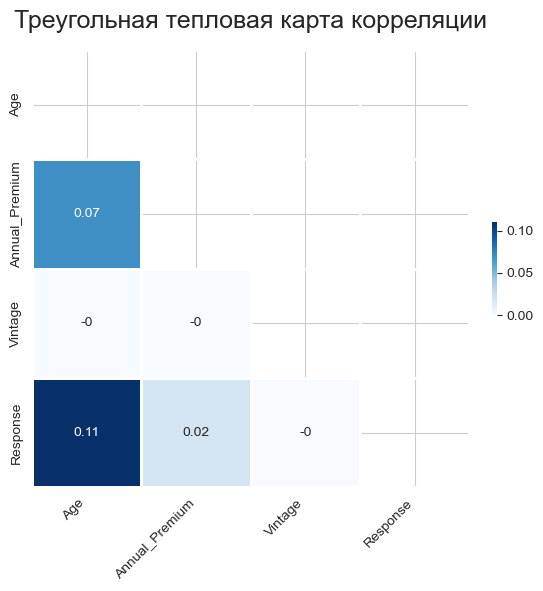

In [12]:
# Корреляция с целевой переменной
correlation_with_target = df_train[numeric_cols + ['Response']].corr()['Response'].drop('Response')
print("Корреляция с Response:")
print(correlation_with_target.sort_values(ascending=False))

plt.rcParams["figure.figsize"] = (6,6)
#sns.heatmap(df_train[numeric_cols + ['Response']].corr(), annot=True, fmt='0.2f')  
sns.set_style("whitegrid")

# Воспользуемся функциями np.triu, чтобы изолировать верхний треугольник (np.tril нижний)
# функция np.ones_like() изменит все изолированные значения на 1.
mask = np.triu(np.ones_like(df_train[numeric_cols + ['Response']].corr(), dtype=bool))

heatmap = sns.heatmap(
    df_train[numeric_cols + ['Response']].corr().round(2),
    annot=True,
    square=True,
    cmap="Blues",
    cbar_kws={"fraction": 0.01},
    linewidth=2,
    
    mask=mask,
)

heatmap.set_title(
    "Треугольная тепловая карта корреляции", fontdict={"fontsize": 18}, pad=16
);

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
);

Vintage имеет распределение близкое к равномерному и по отношению к целевой переменной. Vintage не различает классы на среднем уровне и не имеет статистической значимости (но может иметь нелинейные эфекты), т.е. кандидат на удаление из рассмотрения.
Annual_Premium имеет тяжелый правый хвост и достаточно много выбросов. 
Age и Annual_Premium - важные предикторы. Исходя из значения корреляции Age - это самый сильный предиктор.
Средний возраст откликающихся клиентов 43.4 против 38.2 не откликнувшихся. Откликающиеся платят в среднем больше - 31.604 против 30.419.
Все признаки имеют распределение отличное от нормального, поэтому предполагается использование RobustScaler. 

In [ ]:
# Проверка, какие engineered features усиливают корреляцию
from scipy import stats

def find_best_transformations(X, y, feature_cols):
    """Находит преобразования, максимизирующие корреляцию с таргетом"""
    
    results = {}
    
    for col in feature_cols:
        original_data = X[col]
        
        # Разные преобразования создаем как pandas Series
        transformations = {
            'original': original_data,
            'squared': pd.Series(original_data ** 2, name=col),
            'sqrt': pd.Series(np.sqrt(original_data), name=col),
            'log': pd.Series(np.log(original_data - original_data.min() + 1), name=col),
            'log1p': pd.Series(np.log1p(original_data), name=col),
            'reciprocal': pd.Series(1 / (original_data + 1), name=col),
            'boxcox': pd.Series(stats.boxcox(original_data + 1)[0], name=col) if hasattr(stats, 'boxcox') else None,
            'rank': original_data.rank(),
            'zscore': pd.Series((original_data - original_data.mean()) / original_data.std(), name=col)
        }
        
        # Считаем корреляцию для каждого преобразования
        for transform_name, transformed_data in transformations.items():
            if transformed_data is not None and not transformed_data.isnull().any():
                try:
                    corr = transformed_data.corr(y)
                    results[f"{col}_{transform_name}"] = corr
                except:
                    continue
    
    # Сортируем по абсолютной корреляции
    sorted_results = sorted(results.items(), key=lambda x: abs(x[1]), reverse=True)
    
    print("Лучшие преобразования по корреляции с Response:")
    for feature_name, corr in sorted_results[:10]:
        print(f"{feature_name:30} corr = {corr:.6f}")
    
    return sorted_results


X_train = df_train.drop('Response', axis=1) 
y_train = df_train['Response'] 
# Запускаем для числовых признаков
best_transforms = find_best_transformations(X_train, y_train, 
                                           ['Age', 'Annual_Premium', 'Vintage'])

Лучшие преобразования по корреляции с Response:
Age_log                        corr = 0.164169
Age_reciprocal                 corr = -0.163472
Age_boxcox                     corr = 0.150691
Age_rank                       corr = 0.144360
Age_log1p                      corr = 0.141062
Age_sqrt                       corr = 0.127206
Age_zscore                     corr = 0.111147
Age_original                   corr = 0.111147
Age_squared                    corr = 0.077322
Annual_Premium_rank            corr = 0.033991


Для признака Age несколько преобразований дают лучшую корреляцию с целевой переменной, чем корреляция без преобразования. Поэтому, есть смысл создать дополнительные признаки.
Для признака Annual_Premium преобразование Rank дает увеличение корреляции с целевой переменной. 

### Дополнительно


Анализ признака: Age
Базовые статистики:
  min: 20
  max: 85
  mean: 38.822583565331705
  median: 36.0
  std: 15.511611018090681
  skew: 0.6725389977260843
  kurtosis: -0.5656550664686129
  missing: 0
  zeros: 0

Выбросы (IQR метод):
  Количество: 0 (0.00%)
  Границы: [-11.00, 85.00]

Статистические тесты:
  Корреляция с Response: 0.1111
  T-test p-value: 0.000000
  Значимое различие: ДА


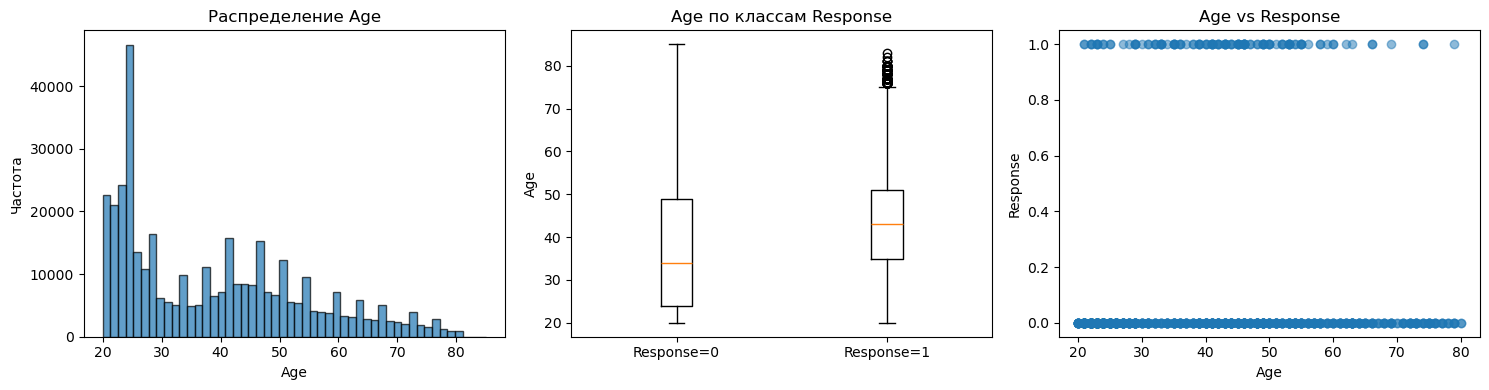


Анализ признака: Annual_Premium
Базовые статистики:
  min: 2630.0
  max: 540165.0
  mean: 30564.389581458323
  median: 31669.0
  std: 17213.155056967284
  skew: 1.7660872148961309
  kurtosis: 34.004568696114696
  missing: 0
  zeros: 0

Выбросы (IQR метод):
  Количество: 10320 (2.71%)
  Границы: [1912.50, 61892.50]

Статистические тесты:
  Корреляция с Response: 0.0226
  T-test p-value: 0.000000
  Значимое различие: ДА


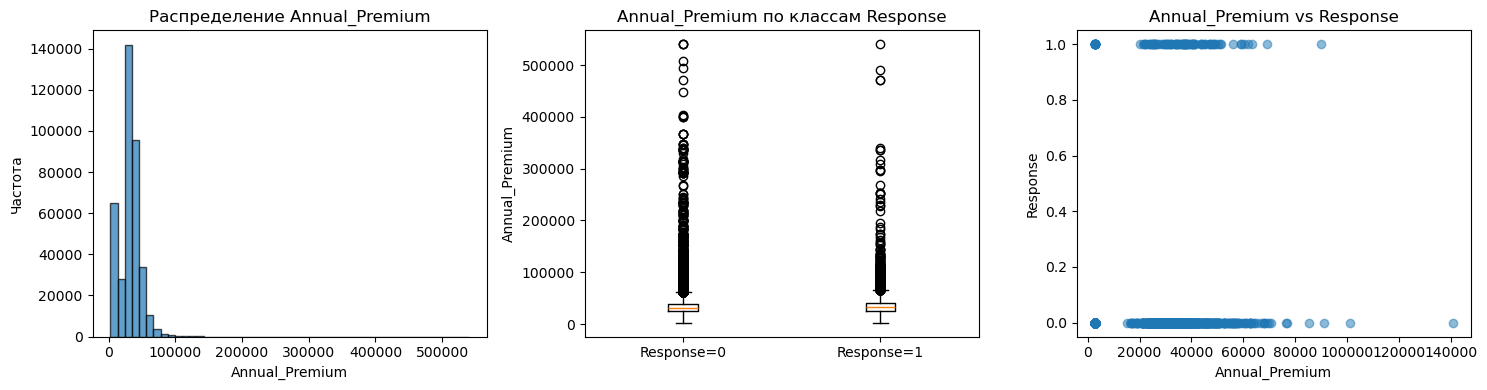


Анализ признака: Vintage
Базовые статистики:
  min: 10
  max: 299
  mean: 154.34739667654136
  median: 154.0
  std: 83.67130362658581
  skew: 0.0030295168899980816
  kurtosis: -1.2006880422961197
  missing: 0
  zeros: 0

Выбросы (IQR метод):
  Количество: 0 (0.00%)
  Границы: [-135.50, 444.50]

Статистические тесты:
  Корреляция с Response: -0.0011
  T-test p-value: 0.516995
  Значимое различие: НЕТ


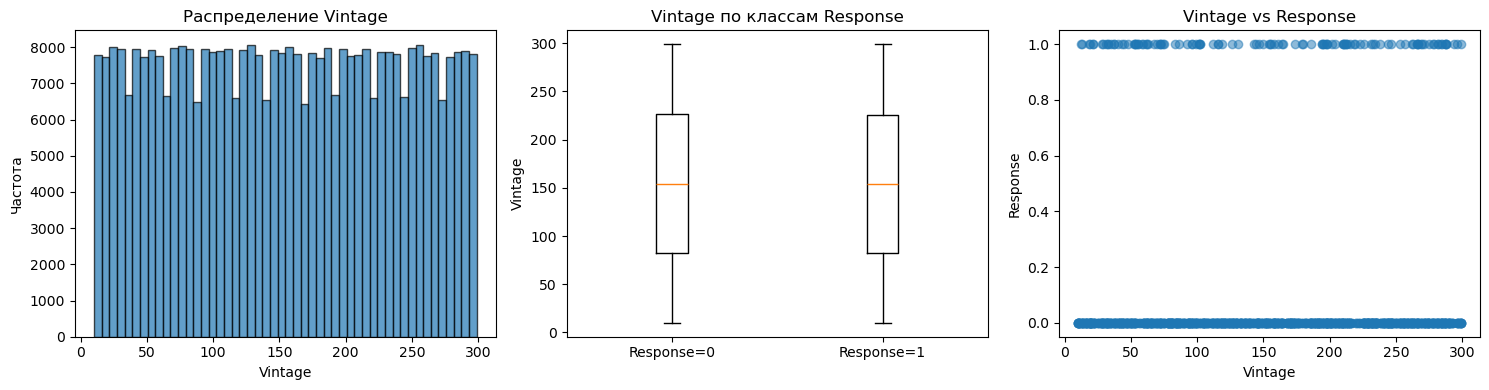

In [9]:
def analyze_numeric_features(df, numeric_cols, target_col='Response'):
    """Комплексный анализ числовых признаков"""
    
    results = {}
    
    for col in numeric_cols:
        print(f"\n{'='*50}")
        print(f"Анализ признака: {col}")
        print('='*50)
        
        # Базовые статистики
        stats = {
            'min': df[col].min(),
            'max': df[col].max(),
            'mean': df[col].mean(),
            'median': df[col].median(),
            'std': df[col].std(),
            'skew': df[col].skew(),
            'kurtosis': df[col].kurtosis(),
            'missing': df[col].isnull().sum(),
            'zeros': (df[col] == 0).sum() if df[col].min() >= 0 else 0
        }
        
        print("Базовые статистики:")
        for key, value in stats.items():
            print(f"  {key}: {value}")
        
        # Проверка на выбросы (IQR метод)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_percent = len(outliers) / len(df) * 100
        
        print(f"\nВыбросы (IQR метод):")
        print(f"  Количество: {len(outliers)} ({outlier_percent:.2f}%)")
        print(f"  Границы: [{lower_bound:.2f}, {upper_bound:.2f}]")
        
        # Корреляция с таргетом
        correlation = df[col].corr(df[target_col])
        
        # Статистическая значимость различий по классам
        from scipy import stats
        group_0 = df[df[target_col] == 0][col]
        group_1 = df[df[target_col] == 1][col]
        
        if len(group_0) > 1 and len(group_1) > 1:
            t_stat, p_value = stats.ttest_ind(group_0, group_1, equal_var=False)
            print(f"\nСтатистические тесты:")
            print(f"  Корреляция с {target_col}: {correlation:.4f}")
            print(f"  T-test p-value: {p_value:.6f}")
            print(f"  Значимое различие: {'ДА' if p_value < 0.05 else 'НЕТ'}")
        
        # Визуализация
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # 1. Гистограмма
        axes[0].hist(df[col], bins=50, alpha=0.7, edgecolor='black')
        axes[0].set_title(f'Распределение {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Частота')
        
        # 2. Box plot по классам
        axes[1].boxplot([group_0, group_1], labels=['Response=0', 'Response=1'])
        axes[1].set_title(f'{col} по классам Response')
        axes[1].set_ylabel(col)
        
        # 3. Scatter plot (если размер данных позволяет)
        sample = df.sample(min(1000, len(df)))
        axes[2].scatter(sample[col], sample[target_col], alpha=0.5)
        axes[2].set_title(f'{col} vs Response')
        axes[2].set_xlabel(col)
        axes[2].set_ylabel('Response')
        
        plt.tight_layout()
        plt.show()
        
        # Сохраняем результаты
        results[col] = {
            'stats': stats,
            'outlier_percent': outlier_percent,
            'correlation': correlation,
            'p_value': p_value if 'p_value' in locals() else None
        }
    
    return results

# Запуск анализа
numeric_analysis = analyze_numeric_features(df_train, numeric_cols)

### Age

Age range: [20, 85]
Mean Age: 38.8, Median: 36.0
Возраст > 100 лет: 0 записей
Возраст < 18 лет: 0 записей

Response rate по возрастным группам:
               mean   count
Age_Group                  
36-45      0.215392   70532
46-55      0.196965   61549
56-65      0.141008   34147
26-35      0.113378   72307
65+        0.083188   28069
18-25      0.035343  114505


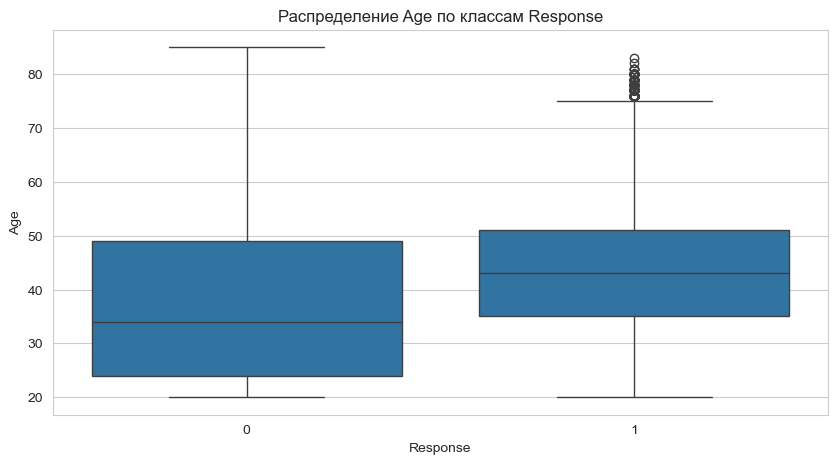

In [ ]:
# Проверка диапазона и распределения
print(f"Age range: [{df_train['Age'].min()}, {df_train['Age'].max()}]")
print(f"Mean Age: {df_train['Age'].mean():.1f}, Median: {df_train['Age'].median():.1f}")

# Проверка на аномалии
print(f"Возраст > 100 лет: {(df_train['Age'] > 100).sum()} записей")
print(f"Возраст < 18 лет: {(df_train['Age'] < 18).sum()} записей")  

# Биннинг для анализа
df_train['Age_Group'] = pd.cut(df_train['Age'], 
                         bins=[0, 25, 35, 45, 55, 65, 100],
                         labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])

# Response rate по возрастным группам
age_response = df_train.groupby('Age_Group')['Response'].agg(['mean', 'count'])
print("\nResponse rate по возрастным группам:")
print(age_response.sort_values('mean', ascending=False))

# Визуализация зависимости от Response
plt.figure(figsize=(10, 5))
sns.boxplot(x='Response', y='Age', data=df_train)
plt.title('Распределение Age по классам Response')
plt.show()

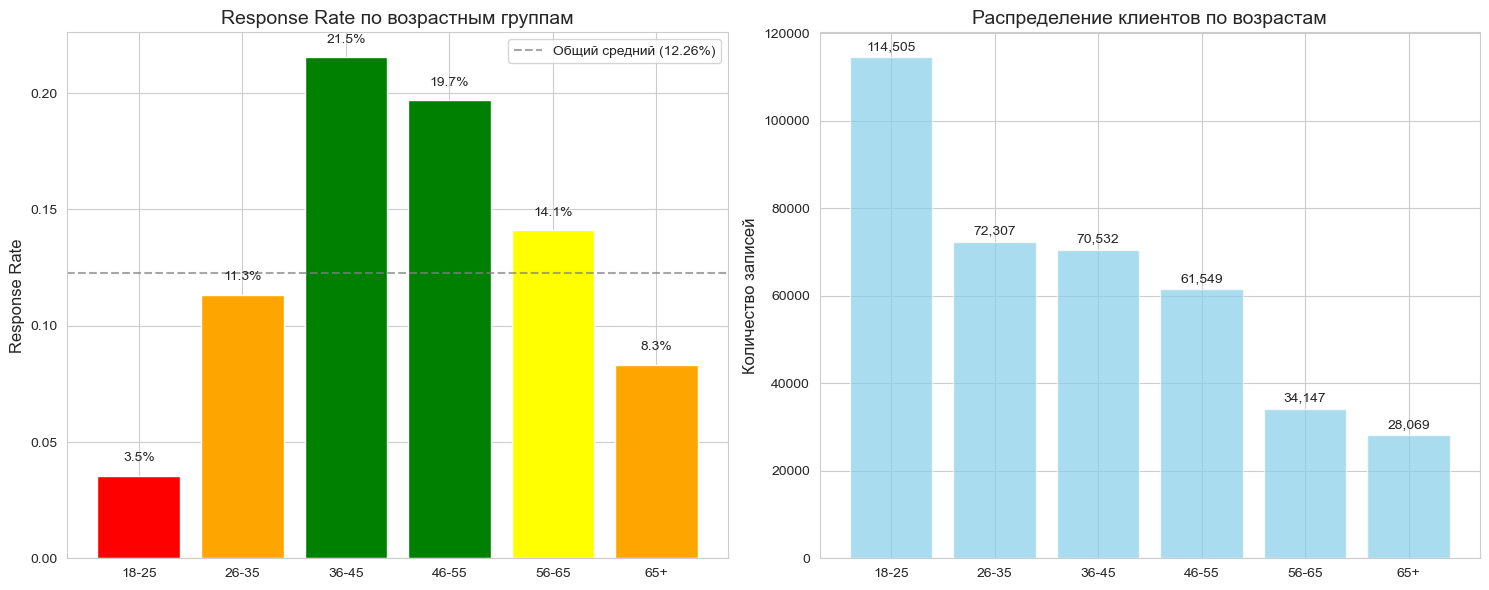


Ключевые выводы:
1. Пик Response rate: 36-45 лет (21.5%) - в 6.1 раз выше, чем у 18-25 лет
2. Вторая лучшая группа: 46-55 лет (19.7%)
3. Самые многочисленные группы: 18-25 лет (114,505 зап.) и 26-35 лет (72,307 зап.)
4. Пиковые группы (36-55 лет) составляют 34.7% от всех клиентов


In [ ]:
# Данные для визуализации
age_groups = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
response_rates = [0.035343, 0.113378, 0.215392, 0.196965, 0.141008, 0.083188]
counts = [114505, 72307, 70532, 61549, 34147, 28069]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Response rate по возрастным группам
bars = ax1.bar(age_groups, response_rates, color=['red', 'orange', 'green', 'green', 'yellow', 'orange'])
ax1.set_title('Response Rate по возрастным группам', fontsize=14)
ax1.set_ylabel('Response Rate', fontsize=12)
ax1.axhline(y=0.1226, color='gray', linestyle='--', alpha=0.7, label='Общий средний (12.26%)')
ax1.legend()

# Добавляем значения на бары
for bar, rate in zip(bars, response_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.005,
             f'{rate:.1%}', ha='center', va='bottom', fontsize=10)

# Количество записей по группам
ax2.bar(age_groups, counts, color='skyblue', alpha=0.7)
ax2.set_title('Распределение клиентов по возрастам', fontsize=14)
ax2.set_ylabel('Количество записей', fontsize=12)

# Добавляем значения
for i, count in enumerate(counts):
    ax2.text(i, count + 1000, f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Анализ
print("\nКлючевые выводы:")
print(f"1. Пик Response rate: 36-45 лет ({response_rates[2]:.1%}) - в {response_rates[2]/response_rates[0]:.1f} раз выше, чем у 18-25 лет")
print(f"2. Вторая лучшая группа: 46-55 лет ({response_rates[3]:.1%})")
print(f"3. Самые многочисленные группы: 18-25 лет ({counts[0]:,} зап.) и 26-35 лет ({counts[1]:,} зап.)")
print(f"4. Пиковые группы (36-55 лет) составляют {(counts[2] + counts[3])/sum(counts):.1%} от всех клиентов")

In [ ]:
# engineered features для Age

def create_age_features_advanced(df):
    """Продвинутые признаки для Age с учетом средней корреляции"""
    df = df.copy()
    
    # НЕЛИНЕЙНЫЕ ПРЕОБРАЗОВАНИЯ (могут выявить скрытые зависимости)
    df['Age_squared'] = df['Age'] ** 2
    df['Age_log'] = np.log(df['Age'] - 19)  # т.к. min=20
    df['Age_sqrt'] = np.sqrt(df['Age'])
    df['Age_inverse'] = 1 / df['Age'] 
 
    
    # ИНДИКАТОРЫ КЛЮЧЕВЫХ ВОЗРАСТНЫХ ГРУПП
    df['Young_Adult_20_30'] = ((df['Age'] >= 20) & (df['Age'] < 30)).astype(int)
    df['Middle_Aged_40_50'] = ((df['Age'] >= 40) & (df['Age'] < 50)).astype(int)  
    df['Senior_60_plus'] = (df['Age'] >= 60).astype(int)
    
    # ЦИКЛИЧЕСКОЕ КОДИРОВАНИЕ (если есть циклическая зависимость)
    #df['Age_sin'] = np.sin(2 * np.pi * df['Age'] / 85)  # 85 - max возраст
    #df['Age_cos'] = np.cos(2 * np.pi * df['Age'] / 85)
    
    return df

# Проверка: какие преобразования усиливают корреляцию
X_train = df_train.drop('Response', axis=1) 
y_train = df_train['Response'] 
X_train = create_age_features_advanced(X_train)
age_transforms = ['Age', 'Age_squared', 'Age_log', 'Age_sqrt', 'Age_inverse','Young_Adult_20_30','Middle_Aged_40_50','Senior_60_plus']
for col in age_transforms:
    if col in X_train.columns:
        corr = X_train[col].corr(y_train)
        print(f"{col:15} correlation with Response: {corr:.4f}")

Age             correlation with Response: 0.1111
Age_squared     correlation with Response: 0.0773
Age_log         correlation with Response: 0.1642
Age_sqrt        correlation with Response: 0.1272
Age_inverse     correlation with Response: -0.1644
Young_Adult_20_30 correlation with Response: -0.2060
Middle_Aged_40_50 correlation with Response: 0.1376
Senior_60_plus  correlation with Response: -0.0261


Выводы: 
Логарифмическое преобразование признака дает более высокую корреляцию с целевой переменной. Есть смысл создать такой дополнительный признак.

Так же, есть смысл создать отдельные признаки по возрастным группам и заполнить их значения с помощью Target Encoding
Дополнительно создадим 2 бинарных признака для групп с максимальным и минимальным response rates. 

### Annual_Premium

Annual_Premium имеет сложную нелинейную зависимость (на диаграмме мы наблюдаем U-shaped паттерн), которую сложно уловить.
Annual_Premium имеет длинный правосторонний хвост, с большим количеством значений,но это не выбросы. Это, скорее, разные сегменты клиентов. Поэтому, логично Annual_Premium разделить на группы и по ним создать отдельные признаки.  

In [20]:
# Проверка на выбросы (скорее всего они будут!)
print(f"Annual_Premium range: [{df_train['Annual_Premium'].min():.0f}, {df_train['Annual_Premium'].max():.0f}]")
print(f"Skewness: {df_train['Annual_Premium'].skew():.2f}")
print(f"Kurtosis: {df_train['Annual_Premium'].kurtosis():.2f}")

# Анализ выбросов
Q1 = df_train['Annual_Premium'].quantile(0.25)
Q3 = df_train['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_train[(df_train['Annual_Premium'] < lower_bound) | (df_train['Annual_Premium'] > upper_bound)]
print(f"\nВыбросы (IQR метод): {len(outliers)} записей ({len(outliers)/len(df_train):.2%})")

# Проверка нулевых или отрицательных значений
print(f"Нулевые премии: {(df_train['Annual_Premium'] == 0).sum()}")
print(f"Отрицательные премии: {(df_train['Annual_Premium'] < 0).sum()}")

# Логарифмическое преобразование (если сильно skewed)
if abs(df_train['Annual_Premium'].skew()) > 1:
    df_train['Annual_Premium_log'] = np.log1p(df_train['Annual_Premium'])
    print(f"После log transform skew: {df_train['Annual_Premium_log'].skew():.2f}")

# Разбиение на категории
df_train['Premium_Group'] = pd.qcut(df_train['Annual_Premium'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
premium_response = df_train.groupby('Premium_Group')['Response'].mean()
print("\nResponse rate по премиям:")
print(premium_response)

Annual_Premium range: [2630, 540165]
Skewness: 1.77
Kurtosis: 34.00

Выбросы (IQR метод): 10320 записей (2.71%)
Нулевые премии: 0
Отрицательные премии: 0
После log transform skew: -1.47

Response rate по премиям:
Premium_Group
Very Low     0.123993
Low          0.099087
Medium       0.112105
High         0.129735
Very High    0.147901
Name: Response, dtype: float64


In [51]:
def evaluate_premium_transformations(X, y):
    """Оценка разных преобразований Annual_Premium"""
    
    transformations = {}
    
    # Исходный
    transformations['Original'] = X['Annual_Premium']
    
    # Разные преобразования
    transformations['Log1p'] = np.log1p(X['Annual_Premium'])
    transformations['Sqrt'] = np.sqrt(X['Annual_Premium'])
    transformations['Reciprocal'] = 1 / (X['Annual_Premium'] + 1)
    transformations['Rank'] = X['Annual_Premium'].rank() / len(X)
    
    # Winsorized версии
    p01, p99 = X['Annual_Premium'].quantile([0.01, 0.99])
    transformations['Winsorized_1_99'] = X['Annual_Premium'].clip(p01, p99)
    transformations['Log_Winsorized'] = np.log1p(transformations['Winsorized_1_99'])
    
    # Robust scaled
    from sklearn.preprocessing import RobustScaler
    scaler = RobustScaler()
    transformations['Robust_Scaled'] = scaler.fit_transform(X[['Annual_Premium']]).ravel()
    
    # Оцениваем корреляцию с Response
    results = {}
    for name, transformed in transformations.items():
        corr = np.corrcoef(transformed, y)[0, 1]
        results[name] = corr
    
    # Сортируем по абсолютной корреляции
    sorted_results = sorted(results.items(), key=lambda x: abs(x[1]), reverse=True)
    
    print("Лучшие преобразования Annual_Premium:")
    for name, corr in sorted_results[:10]:
        print(f"{name:20} corr = {corr:.6f}")
    
    return sorted_results

# Запускаем оценку
X_train = df_train.drop('Response', axis=1) 
y_train = df_train['Response'] 
premium_results = evaluate_premium_transformations(X_train, y_train)

Лучшие преобразования Annual_Premium:
Rank                 corr = 0.033991
Robust_Scaled        corr = 0.022575
Original             corr = 0.022575
Winsorized_1_99      corr = 0.022487
Sqrt                 corr = 0.012962
Reciprocal           corr = 0.008646
Log1p                corr = 0.002707
Log_Winsorized       corr = 0.002464


### Vintage

Response rate по Vintage интервалам:
                    mean  count
Vintage                        
(183.4, 212.3]  0.125452  38150
(125.6, 154.5]  0.125082  38151
(9.711, 38.9]   0.124410  38164
(38.9, 67.8]    0.123751  38036
(212.3, 241.2]  0.122768  38080
(270.1, 299.0]  0.122196  37841
(96.7, 125.6]   0.121268  38213
(154.5, 183.4]  0.120909  37797
(241.2, 270.1]  0.119981  38281
(67.8, 96.7]    0.119830  38396


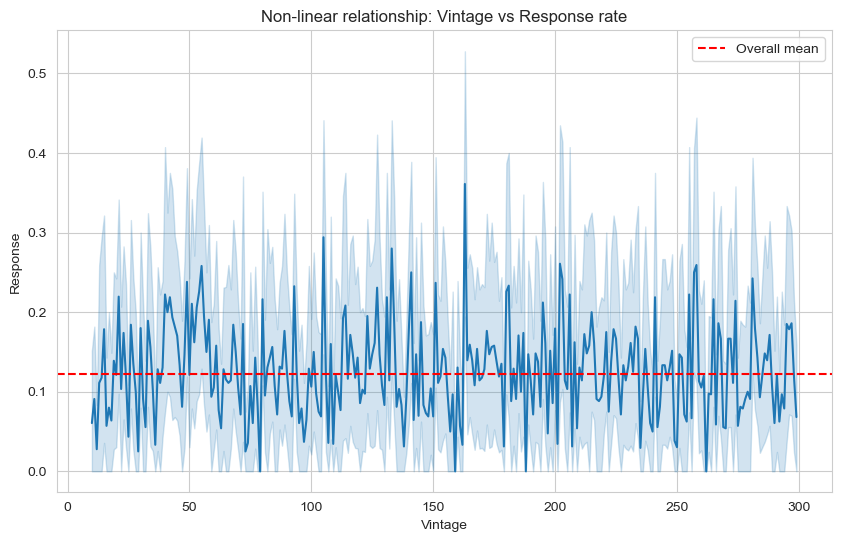

In [14]:
# 1. Response rate по Vintage группам
vintage_bins = pd.cut(df_train['Vintage'], bins=10)
response_by_vintage = df_train.groupby(vintage_bins)['Response'].agg(['mean', 'count'])

print("Response rate по Vintage интервалам:")
print(response_by_vintage.sort_values('mean', ascending=False))

# 2. Визуализация
plt.figure(figsize=(10, 6))
sns.lineplot(x='Vintage', y='Response', data=df_train.sample(10000), 
             ci=95, estimator='mean')
plt.title('Non-linear relationship: Vintage vs Response rate')
plt.axhline(y=df_train['Response'].mean(), color='r', linestyle='--', label='Overall mean')
plt.legend()
plt.show()

In [47]:
print(f"{df_train['Vintage'].max()}")

299


In [49]:
# 1. Проверка диапазона
print(f"Vintage range: [{df_train['Vintage'].min()}, {df_train['Vintage'].max()}] дней")
print(f"Mean: {df_train['Vintage'].mean():.1f} дней, Median: {df_train['Vintage'].median():.1f} дней")

# 2. Преобразование в месяцы/годы для интерпретации
df_train['Vintage_Months'] = df_train['Vintage'] / 30
df_train['Vintage_Years'] = df_train['Vintage'] / 365

print(f"\nВ годах: от {df_train['Vintage'].min()/365:.1f} до {df_train['Vintage'].max()/365:.1f} лет")

# 3. Проверка на закономерности
# Часто есть зависимость: новые клиенты vs лояльные клиенты
df_train['Is_New_Customer'] = (df_train['Vintage'] < 30).astype(int)  # меньше месяца
df_train['Is_Loyal_Customer'] = (df_train['Vintage'] > 365).astype(int)  # больше года

print(f"Новых клиентов (<30 дней): {df_train['Is_New_Customer'].mean():.2%}")
print(f"Лояльных клиентов (>1 года): {df_train['Is_Loyal_Customer'].mean():.2%}")

# 4. Response rate по Vintage группам
df_train['Vintage_Group'] = pd.cut(df_train['Vintage'], 
                            bins=[0, 30, 90, 180, df_train['Vintage'].max()],
                            labels=['<1m', '1-3m', '3-6m', '6-12m'])

vintage_response = df_train.groupby('Vintage_Group')['Response'].agg(['mean', 'count'])
print("\nResponse rate по Vintage:")
print(vintage_response.sort_values('mean', ascending=False))

Vintage range: [10, 299] дней
Mean: 154.3 дней, Median: 154.0 дней

В годах: от 0.0 до 0.8 лет
Новых клиентов (<30 дней): 6.87%
Лояльных клиентов (>1 года): 0.00%

Response rate по Vintage:
                   mean   count
Vintage_Group                  
<1m            0.123665   27526
1-3m           0.122962   79130
6-12m          0.122737  156188
3-6m           0.121811  118265


In [52]:
def check_vintage_nonlinearity(df, y):
    """Проверка нелинейных зависимостей Vintage"""
    df = df.copy()
    
    # Создаем много бинов для детального анализа
    df['Vintage_Fine_Bins'] = pd.cut(df['Vintage'], bins=20)
    response_by_bin = df.groupby('Vintage_Fine_Bins', observed=False).agg({
        'Response': 'mean',
        'Vintage': 'count'
    }).sort_values('Response', ascending=False)
    
    print("Response rate по детальным Vintage бинам:")
    print(response_by_bin.head(10))
    
    # Проверяем максимальную разницу
    max_diff = response_by_bin['Response'].max() - response_by_bin['Response'].min()
    print(f"\nМаксимальная разница в Response rate: {max_diff:.4f}")
    
    # Если разница < 0.01 (1%), признак практически бесполезен
    if max_diff < 0.01:
        print("Vintage практически не информативен (разница < 1%)")
        return False
    else:
        print("Есть нелинейные зависимости, стоит исследовать")
        return True

# Проверяем
y_train = df_train['Response']
has_nonlinearity = check_vintage_nonlinearity(df_train, y_train)

Response rate по детальным Vintage бинам:
                   Response  Vintage
Vintage_Fine_Bins                   
(197.85, 212.3]    0.128416    19468
(140.05, 154.5]    0.126453    18410
(9.711, 24.45]     0.125812    19553
(38.9, 53.35]      0.124611    19605
(125.6, 140.05]    0.123803    19741
(111.15, 125.6]    0.123714    18470
(212.3, 226.75]    0.122949    18406
(24.45, 38.9]      0.122938    18611
(284.55, 299.0]    0.122930    19507
(53.35, 67.8]      0.122837    18431

Максимальная разница в Response rate: 0.0106
Есть нелинейные зависимости, стоит исследовать


In [6]:
# Проверка информативности через модели:
def evaluate_vintage_importance(X, y):
    """Оценка важности Vintage признаков"""
    
    # 1. Проверяем корреляции
    print("Корреляции с Response:")
    print(f"Vintage: {X['Vintage'].corr(y):.6f}")
    print(f"Vintage_Log: {np.log1p(X['Vintage']).corr(y):.6f}")
    
    # 2. Проверяем через feature importance в LightGBM
    from lightgbm import LGBMClassifier
    
    # Модель только с Vintage
    model_single = LGBMClassifier(n_estimators=100, random_state=42)
    model_single.fit(X[['Vintage']], y)
    vintage_importance = model_single.feature_importances_[0]
    
    # Модель со всеми признаками
    # (нужно подготовить X со всеми признаками)
    
    print(f"\nFeature importance Vintage (отдельная модель): {vintage_importance}")
    
    # 3. Проверяем через permutation importance
    from sklearn.inspection import permutation_importance
    
    model = LGBMClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    vintage_idx = list(X.columns).index('Vintage') if 'Vintage' in X.columns else -1
    
    if vintage_idx != -1:
        print(f"Permutation importance Vintage: {result.importances_mean[vintage_idx]:.6f}")
    
    return vintage_importance

# Запускаем оценку
X_train = df_train.drop('Response', axis=1) 
y_train = df_train['Response'] 
vintage_imp = evaluate_vintage_importance(X_train[['Vintage', 'Age', 'Annual_Premium']], y_train)

Корреляции с Response:
Vintage: -0.001050
Vintage_Log: -0.001650
[LightGBM] [Info] Number of positive: 46710, number of negative: 334399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246
[LightGBM] [Info] Number of data points in the train set: 381109, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122563 -> initscore=-1.968377
[LightGBM] [Info] Start training from score -1.968377

Feature importance Vintage (отдельная модель): 3000
[LightGBM] [Info] Number of positive: 46710, number of negative: 334399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 381109, number of used features: 3
[LightGBM] [Info] [binary:Bo

# Предобработка (Data Preprocessing)

In [4]:
df_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
# Target encoding со сглаживанием (лучший для деревьев)
def target_encode_channel(df, channel_col, target_col, smoothing=100, is_train=True, encoders=None):
    # Глобальное среднее
    global_mean = df[target_col].mean()
    
    if is_train:
        channel_stats = df.groupby(channel_col)[target_col].agg(['mean', 'count']) # Вычисляем статистики
        # Сглаживание
        channel_stats['encoded'] = (channel_stats['count'] * channel_stats['mean'] + smoothing * global_mean) / (channel_stats['count'] + smoothing)
    
    return df[channel_col].map(channel_stats['encoded']).fillna(global_mean)

#df_train['Vehicle_Age_encoded'] = target_encode_channel(df_train, 'Vehicle_Age', 'Response', smoothing=50)

Функционал ниже выполняет комплексную предобработку данных для задачи предсказания 
покупки доп.услуги автострахования. 

**Ключевые методы обработки**

**Удаление нефункциональных признаков:**
1. Driving_License - 99.8% значений = 1 (неинформативен)
2. Vintage - количество дней с компанией не влияет на решение

**Frequency Encoding (Частотное кодирование):**
Замена категорий на их частоту в данных
1. Policy_Sales_Channel - канал продаж (150+ уникальных значений)
2. Region_Code - регион (50+ уникальных значений)

**Target Encoding с регуляризацией:** с формулой: encoded_value = (count * mean + smoothing * global_mean) / (count + smoothing), где smoothing = 50 (Защита от переобучения на редких категориях)

1. Vehicle_Age 

**Rank Transform:**

1. Annual_Premium

**Биннинг и Response Rates**

Age и Annual_Premium разбиты на группы с разной конверсией:
- Age: 6 групп (18-25, 26-35, ..., 65+)
- Premium: 5 групп (Very Low, Low, Medium, High, Very High)

Каждой группе присвоен Target Encoded показатель - фактическая 
вероятность покупки в этой группе из обучающих данных.

**Создание новых признаков (Feature Engineering)**

**Индикаторы важных сегментов:**

1. Vehicle_Old_HighResp - старые машины (>2 лет), высокий отклик
2. Vehicle_New_LowResp - новые машины (<1 года), низкий отклик
3. Premium_Is_Very_High - очень высокая премия
4. Premium_Is_Very_Low - очень низкая премия

**Взаимодействия признаков:** (Кросс-признаки, выявленные в EDA)

1. OldCar_NoDamage - старый автомобиль без повреждений
2. OldCar_HighPremium - старый автомобиль с высокой премией
3. Age_to_Premium_Ratio - отношение возраста к страховой премии

**Логарифмирование возраста:**

Age_Log = log(Age - offset)
- Учитывает нелинейную зависимость возраста от отклика
- Молодые клиенты более чувствительны к изменению возраста

**Преобразования основаны на бизнес-инсайтах:**

1. Vehicle_Age: Старые машины → выше риск → выше интерес к страховке
2. Annual_Premium: Нелинейная зависимость (U-образная кривая)
3. Age: Пик интереса 36-45 лет (семейные, ответственные)
4. Vehicle_Damage: История повреждений → осознание рисков


In [6]:
# Функция интерполяции
def interpolate_rank(value, rank_info):
    """Интерполяция rank для значения на основе rank_info из train"""
    if value <= rank_info['min']:
        return 0.0
    elif value >= rank_info['max']:
        return 1.0
    
    idx = np.searchsorted(rank_info['sorted_values'], value)
    if idx == 0:
        return rank_info['sorted_ranks'][0]
    
    left_val = rank_info['sorted_values'][idx-1]
    right_val = rank_info['sorted_values'][idx]
    left_rank = rank_info['sorted_ranks'][idx-1]
    right_rank = rank_info['sorted_ranks'][idx]
    
    # Защита от деления на ноль
    if right_val == left_val:
        return left_rank
    
    weight = (value - left_val) / (right_val - left_val)
    return left_rank + weight * (right_rank - left_rank)

def preprocess_features_final(X, y=None, is_train=True, encoders=None):
    """Обработка признаков с учетом дисбаланса"""
    X_processed = X.copy()
    
    if encoders is None:
        encoders = {
            'frequency': {},
            'target': {},
            'rank': {},
            'response_rates': {},
            'global_stats': {}
        }
    
    # ИНИЦИАЛИЗАЦИЯ ГЛОБАЛЬНЫХ СТАТИСТИК 
    if is_train and y is not None:
        global_mean = y.mean()
        encoders['global_stats']['response_mean'] = global_mean
    else:
        global_mean = encoders['global_stats'].get('response_mean', 0.122563)
    
    # УДАЛЕНИЕ НЕИНФОРМАТИВНЫХ ПРИЗНАКОВ 
    # Driving_License - удаляем (99.8% = 1)
    if 'Driving_License' in X_processed.columns:
        X_processed = X_processed.drop('Driving_License', axis=1)
    
    # Vintage - удаляем (не информативен)
    if 'Vintage' in X_processed.columns:
        X_processed = X_processed.drop('Vintage', axis=1)
    
    # FREQUENCY ENCODING
    # 1. Policy_Sales_Channel
    if 'Policy_Sales_Channel' in X_processed.columns:
        if is_train:
            channel_freq = X_processed['Policy_Sales_Channel'].value_counts(normalize=True)
            encoders['frequency']['policy_sales_channel'] = channel_freq.to_dict()
        else:
            channel_freq_dict = encoders['frequency'].get('policy_sales_channel', {})
            channel_freq = pd.Series(channel_freq_dict)
        
        X_processed['Policy_Sales_Channel_freq'] = X_processed['Policy_Sales_Channel'].map(
            lambda x: channel_freq.get(x, 0) if hasattr(channel_freq, 'get') 
            else channel_freq.to_dict().get(x, 0)
        )
    
    # 2. Region_Code
    if 'Region_Code' in X_processed.columns:
        if is_train:
            region_freq = X_processed['Region_Code'].value_counts(normalize=True)
            encoders['frequency']['region_code'] = region_freq.to_dict()
        else:
            region_freq_dict = encoders['frequency'].get('region_code', {})
            region_freq = pd.Series(region_freq_dict)
        
        X_processed['Region_Code_freq'] = X_processed['Region_Code'].map(
            lambda x: region_freq.get(x, 0) if hasattr(region_freq, 'get')
            else region_freq.to_dict().get(x, 0)
        )
    
    # 3. VEHICLE_AGE - TARGET ENCODING
    if 'Vehicle_Age' in X_processed.columns:
        if is_train and y is not None:
            # Только для обучающих данных вычисляем статистики
            xy_processed = X.copy()
            xy_processed['Response'] = y
            vehicle_age_stats = xy_processed.groupby('Vehicle_Age')['Response'].agg(['mean', 'count'])
        
            # Сглаживание
            smoothing = 50
            global_mean = y.mean()  # Вычисляем global_mean
            vehicle_age_encoded = (
                vehicle_age_stats['count'] * vehicle_age_stats['mean'] + 
                smoothing * global_mean
                ) / (vehicle_age_stats['count'] + smoothing)
        
            # Сохраняем в энкодеры
            encoders['target']['vehicle_age'] = vehicle_age_encoded.to_dict()
            encoders['target']['global_mean'] = float(global_mean)  # Сохраняем global_mean!
        
            # Применяем к обучающим данным
            X_processed['Vehicle_Age_TE'] = X_processed['Vehicle_Age'].map(vehicle_age_encoded)    
        elif not is_train and encoders is not None:
            # Для тестовых/валидационных данных используем сохранённые значения
            vehicle_age_dict = encoders['target'].get('vehicle_age', {})
            saved_global_mean = encoders['target'].get('global_mean', 0.1)  # значение по умолчанию
        
            # Применяем энкодер
            X_processed['Vehicle_Age_TE'] = X_processed['Vehicle_Age'].map(
                lambda x: vehicle_age_dict.get(x, saved_global_mean)
                )
    
        # 3.1 Индикатор "старые машины"
        X_processed['Vehicle_Old_HighResp'] = (X_processed['Vehicle_Age'] == '> 2 Years').astype('int8')
        # 3.2 Индикатор "новые машины"
        X_processed['Vehicle_New_LowResp'] = (X_processed['Vehicle_Age'] == '< 1 Year').astype('int8')

        # 4. Дополнительные признаки
        # Отношение к средней категории
        #df['Age_Response_Ratio'] = df['Vehicle_Age_ResponseRate'] / 0.1738

    # БИНАРНЫЕ ПРИЗНАКИ
    # 4. Gender
    if 'Gender' in X_processed.columns:
        X_processed['Gender_encoded'] = X_processed['Gender'].map({'Male': 1, 'Female': 0})
        # Заполняем пропуски значением по умолчанию (например, 0)
        X_processed['Gender_encoded'] = X_processed['Gender_encoded'].fillna(0).astype('int8')
    
    # 5. Vehicle_Damage
    if 'Vehicle_Damage' in X_processed.columns:
        X_processed['Vehicle_Damage_encoded'] = X_processed['Vehicle_Damage'].map({'Yes': 1, 'No': 0})
        X_processed['Vehicle_Damage_encoded'] = X_processed['Vehicle_Damage_encoded'].fillna(0).astype('int8')
    
    # 6. Previously_Insured 
    if 'Previously_Insured' in X_processed.columns:
        X_processed['Previously_Insured'] = X_processed['Previously_Insured'].astype('int8')
    
    # Взаимодействия с Vehicle_Old_HighResp
    X_processed['OldCar_NoDamage'] = X_processed['Vehicle_Old_HighResp'] * (X_processed['Vehicle_Damage'] == 0).astype(int)
    
    

    # УДАЛЕНИЕ ИСХОДНЫХ КАТЕГОРИАЛЬНЫХ КОЛОНОК 
    cols_to_drop = ['Policy_Sales_Channel', 'Region_Code', 'Vehicle_Age', 
                    'Gender', 'Vehicle_Damage']
    X_processed = X_processed.drop(
        [col for col in cols_to_drop if col in X_processed.columns], 
        axis=1, 
        errors='ignore'
    )
    
    # НЕПРЕРЫВНЫЕ ЧИСЛОВЫЕ ПРИЗНАКИ
    # 7. AGE 
    if 'Age' in X_processed.columns:
        # Age Response rates
        age_response_rates = {
            '18-25': 0.035343,
            '26-35': 0.113378,
            '36-45': 0.215392,
            '46-55': 0.196965,
            '56-65': 0.141008,
            '65+': 0.083188
        }
        
        if is_train:
            encoders['response_rates']['age'] = age_response_rates
        else:
            age_response_rates = encoders['response_rates'].get('age', age_response_rates)
        
        # Биннинг Age
        age_bins = [18, 26, 36, 46, 56, 66, 86]
        age_labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
        
        X_processed['Age_Group'] = pd.cut(
            X_processed['Age'], 
            bins=age_bins, 
            labels=age_labels, 
            right=False
        )
        
        # Target Encoding
        X_processed['Age_Target_Encoded'] = X_processed['Age_Group'].map(age_response_rates).astype('float64') #
        
        # 8.1 Логарифмирование Age
        if is_train:
            age_min = X_processed['Age'].min()
            age_offset = age_min - 1 if age_min > 1 else 0
            encoders['age_log_config'] = {
                'min_value': age_min,
                'offset': age_offset
            }
        else:
            age_log_config = encoders.get('age_log_config', {})
            age_offset = age_log_config.get('offset', X_processed['Age'].min() - 1)
        
        # Применяем логарифмирование
        age_values = X_processed['Age'] - age_offset
        if (age_values <= 0).any():
            # Fallback для отрицательных значений
            X_processed['Age_Log'] = np.log1p(X_processed['Age'] - X_processed['Age'].min())
        else:
            X_processed['Age_Log'] = np.log(age_values)
        
        # Взаимодействия признаков 
        # 8.2   
        X_processed['Age_to_Premium_Ratio'] = X_processed['Age'] / (X_processed['Annual_Premium'] + 1)
        
        # Удаляем промежуточные колонки
        X_processed = X_processed.drop(['Age_Group', 'Age'], axis=1, errors='ignore')
    
    
    # 9. ANNUAL_PREMIUM  
    if 'Annual_Premium' in X_processed.columns:
        # Rank преобразование
        if is_train:
            # Вычисляем rank
            rank_series = X_processed['Annual_Premium'].rank(pct=True, method='average')
            X_processed['Annual_Premium_Rank'] = rank_series
            
            # Сохраняем информацию для теста
            sorted_values = np.sort(X_processed['Annual_Premium'].unique())
            sorted_ranks = rank_series.groupby(X_processed['Annual_Premium']).first().reindex(sorted_values).values
            
            encoders['rank']['annual_premium'] = {
                'sorted_values': sorted_values,
                'sorted_ranks': sorted_ranks,
                'min': X_processed['Annual_Premium'].min(),
                'max': X_processed['Annual_Premium'].max()
            }
        else:
            # Используем сохраненный rank_info
            rank_info = encoders['rank'].get('annual_premium')
            if rank_info:
                X_processed['Annual_Premium_Rank'] = X_processed['Annual_Premium'].apply(
                    lambda x: interpolate_rank(x, rank_info)
                )
            else:
                # Fallback: вычисляем rank на месте (не рекомендуется)
                X_processed['Annual_Premium_Rank'] = X_processed['Annual_Premium'].rank(pct=True)
        
        # 10-15. Premium Groups
        premium_response_rates = {
            'Very Low': 0.123993,
            'Low': 0.099087,
            'Medium': 0.112105,
            'High': 0.129735,
            'Very High': 0.147901
        }
        
        annual_premium_original = X_processed['Annual_Premium'].copy()

    if is_train:
        encoders['response_rates']['premium'] = premium_response_rates
    
        # Определяем границы на train
        quantiles = annual_premium_original.quantile([0.2, 0.4, 0.6, 0.8])
        encoders['premium_quantiles'] = {
            'q20': float(quantiles[0.2]),
            'q40': float(quantiles[0.4]),
            'q60': float(quantiles[0.6]),
            'q80': float(quantiles[0.8]),
            'min': float(annual_premium_original.min()),
            'max': float(annual_premium_original.max())
        }
    
        # Биннинг
        bins = [
            float(annual_premium_original.min()),
            float(quantiles[0.2]),
            float(quantiles[0.4]),
            float(quantiles[0.6]),
            float(quantiles[0.8]),
            float(annual_premium_original.max())
        ]
        labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
        X_processed['Premium_Group'] = pd.cut(
            annual_premium_original, 
            bins=bins, 
            labels=labels, 
            include_lowest=True
        )
    else:
        premium_response_rates = encoders['response_rates'].get('premium', premium_response_rates)
        premium_quantiles = encoders.get('premium_quantiles', {})
    
        # Используем границы из train
        bins = [
            float(premium_quantiles.get('min', annual_premium_original.min())),
            float(premium_quantiles.get('q20', annual_premium_original.quantile(0.2))),
            float(premium_quantiles.get('q40', annual_premium_original.quantile(0.4))),
            float(premium_quantiles.get('q60', annual_premium_original.quantile(0.6))),
            float(premium_quantiles.get('q80', annual_premium_original.quantile(0.8))),
            float(premium_quantiles.get('max', annual_premium_original.max()))
        ]
        labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
        X_processed['Premium_Group'] = pd.cut(
            annual_premium_original, 
            bins=bins, 
            labels=labels, 
            include_lowest=True
        )

    # Создаем 5 признаков на основе групп
    X_processed['Premium_Group_TE'] = X_processed['Premium_Group'].map(premium_response_rates).astype('float64')
    X_processed['Premium_Is_Very_High'] = (X_processed['Premium_Group'] == 'Very High').astype('int8')
    X_processed['Premium_Is_Very_Low'] = (X_processed['Premium_Group'] == 'Very Low').astype('int8')
    X_processed['Premium_Is_Low'] = (X_processed['Premium_Group'] == 'Low').astype('int8')

    # Взаимодействия признаков
    X_processed['OldCar_HighPremium']   = X_processed['Vehicle_Old_HighResp'] * X_processed['Premium_Is_Very_High']
    

    # Создаем признак отклонения от линейной зависимости
    # Используем оригинальную копию для вычислений
    #premium_min = float(annual_premium_original.min())
    #premium_max = float(annual_premium_original.max())
    #
    #linear_expectation = (
    #    (annual_premium_original - premium_min) / (premium_max - premium_min) * 
    #    (premium_response_rates['Very High'] - premium_response_rates['Very Low']) + 
    #    premium_response_rates['Very Low']
    #)
    #
    #X_processed['Premium_Nonlinear_Boost'] = X_processed['Premium_Group_TE'] - linear_expectation

    # Удаляем промежуточные колонки
    X_processed = X_processed.drop(['Premium_Group', 'Annual_Premium'], axis=1, errors='ignore')
    
    return X_processed, encoders

# Сравнение моделей на кросвалидации. Выбор модели. (Model Comparison with Cross-Validation)

Методология:
- Использована 5-fold кросс-валидация на всем тренировочном датасете
- OOF (Out-of-Fold) предсказания для оценки качества 

Результаты:
- **OOF AUC** наилучших моделей (LightGBM, XGBoost, CatBoost): 0.8578 ± 0.011 (кросс-валидация)
- Наиболее значимые признаки для LightGBM: Region_Code_freq, Age_to_Premium_Ratio, Age_Log, Annual_Premium_Rank, Policy_Sales_Channel_freq
- Наиболее значимые признаки для XGBoost: Previously_Insured, Vehicle_Damage_encoded, Age_Target_Encoded
- Наиболее значимые признаки для CatBoost: Previously_Insured, Region_Code_freq, Vehicle_Damage_encoded, Policy_Sales_Channel_freq, Age_Log

Запуск кросс-валидации...

Модель: LogisticRegression

Fold 1/5
Fold 1 AUC: 0.834709

Fold 2/5
Fold 2 AUC: 0.832664

Fold 3/5
Fold 3 AUC: 0.833893

Fold 4/5
Fold 4 AUC: 0.835117

Fold 5/5
Fold 5 AUC: 0.835607

OOF AUC: 0.834383
Средний по фолдам: 0.834398 ± 0.001033

Модель: RandomForest

Fold 1/5
Fold 1 AUC: 0.815616

Fold 2/5
Fold 2 AUC: 0.817496

Fold 3/5
Fold 3 AUC: 0.819229

Fold 4/5
Fold 4 AUC: 0.817422

Fold 5/5
Fold 5 AUC: 0.820194

OOF AUC: 0.817997
Средний по фолдам: 0.817991 ± 0.001587

Модель: LightGBM

Fold 1/5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.855601
[200]	valid_0's auc: 0.85692
[300]	valid_0's auc: 0.857047
Early stopping, best iteration is:
[276]	valid_0's auc: 0.857081
Fold 1 AUC: 0.857081

Fold 2/5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.854938
[200]	valid_0's auc: 0.855926
[300]	valid_0's auc: 0.855968
[400]	valid_0's auc: 0.856162
Early stopping, best iteration is:
[392]	

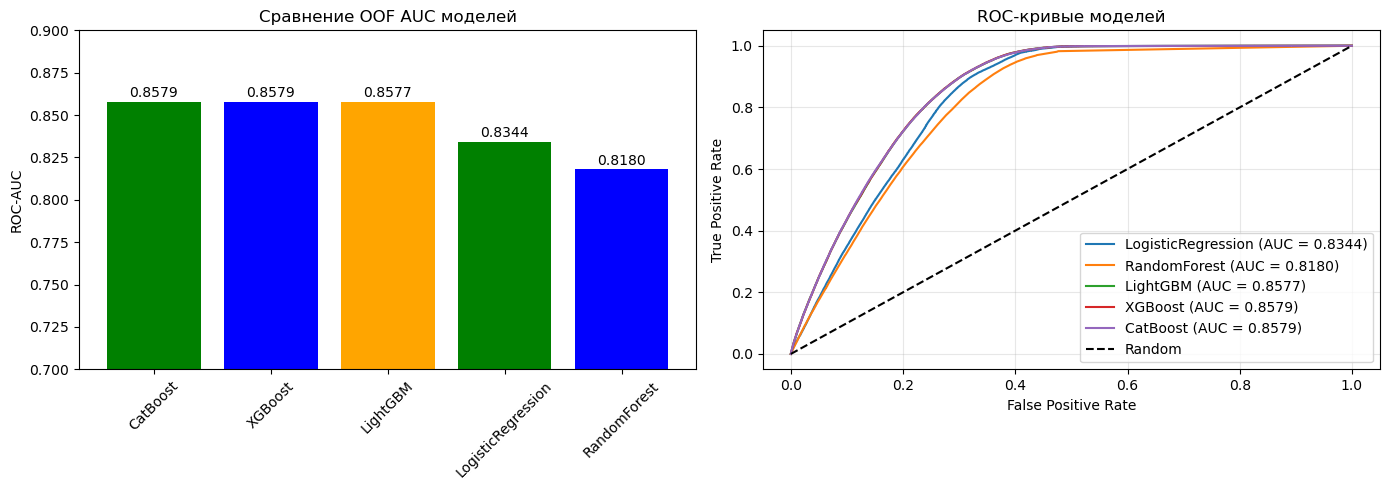


Лучшая модель: CatBoost


In [39]:
def fit_model_with_early_stopping(model, X_train, y_train, X_val, y_val,model_name='LightGBM'):
    """Универсальная функция обучения с early stopping"""
    if model_name == 'LightGBM':
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='auc',
                  #early_stopping_rounds=100,
                  #verbose=100
                  callbacks=[
                            lgb.early_stopping(stopping_rounds=100),
                            lgb.log_evaluation(period=100)  # Заменяет verbose=100
                           ]
                        )
    elif model_name == 'XGBoost': #or model_name == 'CatBoost' or model_name == 'RandomForest':
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )    
    elif hasattr(model, 'early_stopping_rounds'):
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc',
            early_stopping_rounds=100,
            verbose=False
        )    
    else:
        # Для других моделей
        model.fit(X_train, y_train)
    
    return model

def run_cross_validation(X, y, models, n_splits=5, random_state=42):
    """
    Запуск кросс-валидации для нескольких моделей
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    results = {}
    
    for model_name, model in models.items():
        print(f"\n{'='*60}")
        print(f"Модель: {model_name}")
        print('='*60)
        
        oof_predictions = np.zeros(len(X))
        fold_scores = []
        fold_n_estimators = []
        feature_importances = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            print(f"\nFold {fold + 1}/{n_splits}")
            
            # Разделение
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
            
            # Предобработка
            X_train_processed, encoders = preprocess_features_final(
                X_train_fold, y_train_fold, is_train=True
            )
            X_val_processed, _ = preprocess_features_final(
                X_val_fold, is_train=False, encoders=encoders
            )
                       
            
            # Обучение модели
            #if model_name == 'LightGBM':
            #    model.fit(
            #        X_train_processed, y_train_fold,
            #        eval_set=[(X_val_processed, y_val_fold)],
            #        eval_metric='auc',
            #        #early_stopping_rounds=100,
            #        #verbose=100
            #        callbacks=[
            #                    lgb.early_stopping(stopping_rounds=100),
            #                    lgb.log_evaluation(period=100)  # Заменяет verbose=100
            #                ]
            #            )
            #else:
            #    model.fit(X_train_processed, y_train_fold)
         
            model = fit_model_with_early_stopping(model, X_train_processed, y_train_fold, X_val_processed, y_val_fold,model_name)

            # Предсказания
            if hasattr(model, 'predict_proba'):
                val_pred = model.predict_proba(X_val_processed)[:, 1]
            else:
                val_pred = model.predict(X_val_processed)
            
            # Сохраняем OOF predictions
            oof_predictions[val_idx] = val_pred
            
            # Оценка фолда
            fold_auc = roc_auc_score(y_val_fold, val_pred)
            fold_scores.append(fold_auc)            
            print(f"Fold {fold + 1} AUC: {fold_auc:.6f}")
            
            if hasattr(model, 'best_iteration_') and model.best_iteration_ is not None:
                fold_n_estimators.append(model.best_iteration_)
                #print(f'{model.best_iteration_}')
            elif hasattr(model,'best_iteration') and model.best_iteration is not None:
                fold_n_estimators.append(model.best_iteration)
                #print(f'{model.best_iteration}')
            else:
                fold_n_estimators.append(0)       
            

            # Feature importance
            if hasattr(model, 'feature_importances_'):
                importance = pd.DataFrame({
                    'feature': X_train_processed.columns,
                    'importance': model.feature_importances_,
                    'fold': fold
                })
                feature_importances.append(importance)
        
        # Общая оценка
        oof_auc = roc_auc_score(y, oof_predictions)
        print(f"\n{'='*40}")
        print(f"OOF AUC: {oof_auc:.6f}")
        print(f"Средний по фолдам: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}")
        print('='*40)
        
        # Сохраняем результаты
        results[model_name] = {
            'oof_auc': oof_auc,
            'fold_scores': fold_scores,
            'oof_predictions': oof_predictions,
            'feature_importances': pd.concat(feature_importances) if feature_importances else None,
            'n_estimators': int(np.mean(fold_n_estimators))           
        }
    
    return results

def compare_models(results, y):
    """Сравнение результатов моделей"""
    print("\n" + "="*60)
    print("СРАВНЕНИЕ МОДЕЛЕЙ")
    print("="*60)
    
    comparison = []
    for model_name, result in results.items():
        comparison.append({
            'Model': model_name,
            'OOF AUC': result['oof_auc'],
            'Mean Fold AUC': np.mean(result['fold_scores']),
            'Std Fold AUC': np.std(result['fold_scores']),
            'n_estimators': result['n_estimators']
        })
    
    df_comparison = pd.DataFrame(comparison).sort_values('OOF AUC', ascending=False)
    print(df_comparison.to_string(index=False))
    
    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # График 1: AUC по моделям
    models = df_comparison['Model'].values
    auc_scores = df_comparison['OOF AUC'].values
    
    bars = axes[0].bar(models, auc_scores, color=['green', 'blue', 'orange'])
    axes[0].set_title('Сравнение OOF AUC моделей')
    axes[0].set_ylabel('ROC-AUC')
    axes[0].set_ylim(0.7, 0.9)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Добавляем значения на бары
    for bar, score in zip(bars, auc_scores):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{score:.4f}', ha='center', va='bottom')
    
    # График 2: ROC-кривые
    for model_name, result in results.items():
        fpr, tpr, _ = roc_curve(y, result['oof_predictions'])
        axes[1].plot(fpr, tpr, label=f'{model_name} (AUC = {result["oof_auc"]:.4f})')
    
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC-кривые моделей')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df_comparison

# 1. LightGBM (Быстрый Gradient Boosting)
lgb_model = LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    scale_pos_weight=7.15,  # для дисбаланса 87.7%/12.3%
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

# 2. XGBoost (Gradient Boosting с регуляризацией)
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    early_stopping_rounds=100,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=7.15,
    random_state=42,
    n_jobs=-1,
    enable_categorical=True, # Этот метод необходим для работы с категориями
    tree_method='hist'   # Этот метод необходим для работы с категориями
)



# 3. CatBoost (Категориальный boosting)
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    border_count=128,
    random_strength=1,
    auto_class_weights='Balanced',
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=False,
    thread_count=-1
)

# Словарь моделей
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),  # Простая базовая модель
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'), # Bagging алгоритм, устойчивый к переобучению
    'LightGBM': lgb_model,
    'XGBoost': xgb_model,
    'CatBoost': cat_model
}


X_train = df_train.drop('Response', axis=1) 
y_train = df_train['Response'] 
# Запускаем кросс-валидацию
print("Запуск кросс-валидации...")
results = run_cross_validation(X_train, y_train, models, n_splits=5)

# Сравниваем модели
comparison_df = compare_models(results, y_train)

# Выбираем лучшую модель
best_model_name = comparison_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f"\nЛучшая модель: {best_model_name}")

Лучшее качество показали модели LihtGBM и CatBoost. Модель правильно ранжирует 85.8% пар "положительный-отрицательный" случаев и обладает сильной разделительной способностью между классами 0 и 1.
Небольшое стандартное отклонение (0.1%) свидетельствует о стабильности модели.
Данне проверены на кросс-валидации, что подтверждает наличие хорошей обобщающей способности модели.


Feature Importance: RandomForest
Топ-20 признаков:
 1. Vehicle_Damage_encoded               0.19
 2. Age_to_Premium_Ratio                 0.17
 3. Annual_Premium_Rank                  0.16
 4. Previously_Insured                   0.15
 5. Region_Code_freq                     0.11
 6. Policy_Sales_Channel_freq            0.08
 7. Age_Log                              0.08
 8. Age_Target_Encoded                   0.02
 9. Vehicle_Age_TE                       0.01
10. Vehicle_New_LowResp                  0.01
11. Gender_encoded                       0.01
12. Premium_Group_TE                     0.00
13. Vehicle_Old_HighResp                 0.00
14. Premium_Is_Low                       0.00
15. Premium_Is_Very_Low                  0.00
16. Premium_Is_Very_High                 0.00
17. OldCar_HighPremium                   0.00
18. OldCar_NoDamage                      0.00


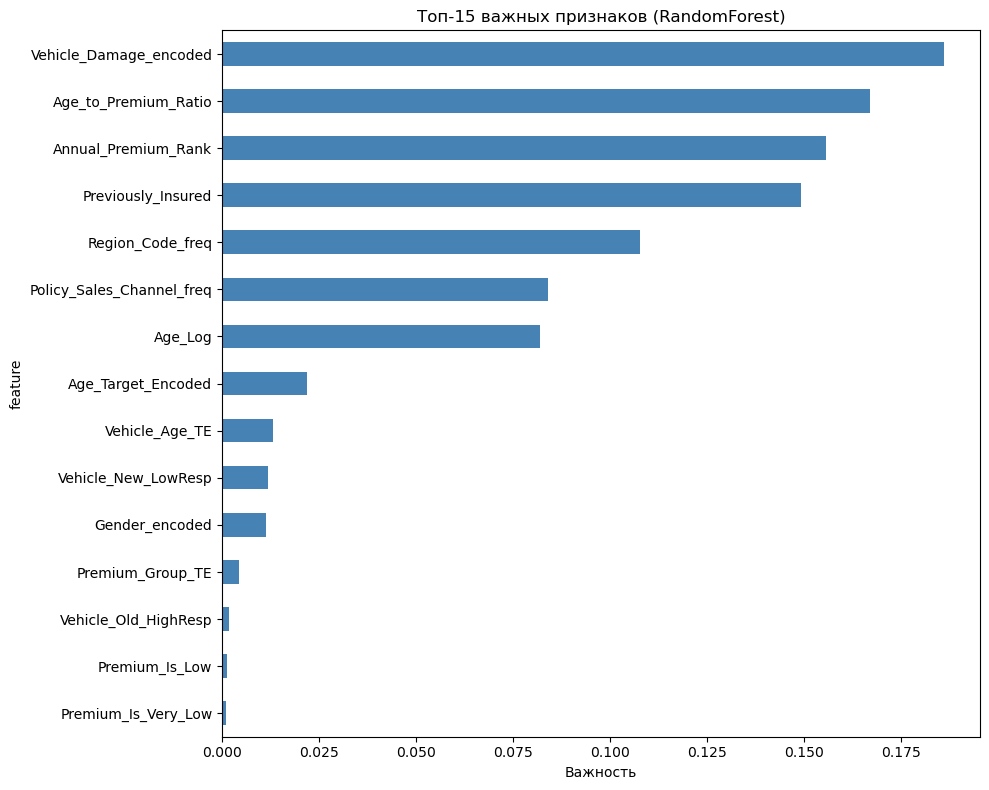


Engineered features в топе:
  ✓ Annual_Premium_Rank
  ✓ Age_Target_Encoded
  ✓ Vehicle_Age_TE
  ✓ Premium_Group_TE
  ✓ Premium_Is_Low
  ✓ Premium_Is_Very_Low
  ✓ Premium_Is_Very_High

Всего engineered features в топ-20: 7/20

Feature Importance: LightGBM
Топ-20 признаков:
 1. Age_to_Premium_Ratio              1642.20
 2. Region_Code_freq                  1633.80
 3. Annual_Premium_Rank               1503.40
 4. Policy_Sales_Channel_freq         1468.20
 5. Age_Log                           1362.80
 6. Vehicle_Age_TE                     338.40
 7. Vehicle_Damage_encoded             263.60
 8. Gender_encoded                     215.80
 9. Age_Target_Encoded                 210.60
10. Previously_Insured                 136.60
11. Premium_Group_TE                    96.20
12. OldCar_HighPremium                  44.80
13. Vehicle_Old_HighResp                37.80
14. Vehicle_New_LowResp                 26.20
15. Premium_Is_Low                       9.40
16. Premium_Is_Very_Low             

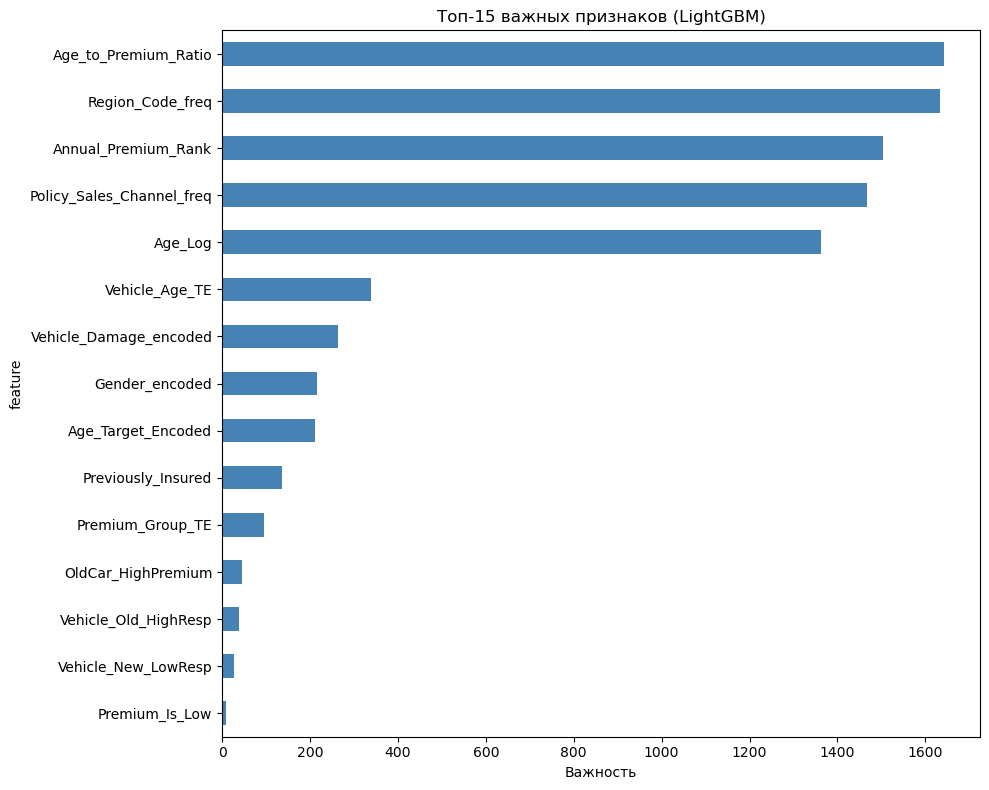


Engineered features в топе:
  ✓ Annual_Premium_Rank
  ✓ Vehicle_Age_TE
  ✓ Age_Target_Encoded
  ✓ Premium_Group_TE
  ✓ Premium_Is_Low
  ✓ Premium_Is_Very_Low
  ✓ Premium_Is_Very_High

Всего engineered features в топ-20: 7/20

Feature Importance: XGBoost
Топ-20 признаков:
 1. Previously_Insured                   0.51
 2. Vehicle_Damage_encoded               0.42
 3. Age_Target_Encoded                   0.02
 4. Age_Log                              0.01
 5. Policy_Sales_Channel_freq            0.00
 6. OldCar_HighPremium                   0.00
 7. Vehicle_New_LowResp                  0.00
 8. Vehicle_Old_HighResp                 0.00
 9. Vehicle_Age_TE                       0.00
10. Region_Code_freq                     0.00
11. Gender_encoded                       0.00
12. Age_to_Premium_Ratio                 0.00
13. Annual_Premium_Rank                  0.00
14. Premium_Group_TE                     0.00
15. Premium_Is_Low                       0.00
16. Premium_Is_Very_Low              

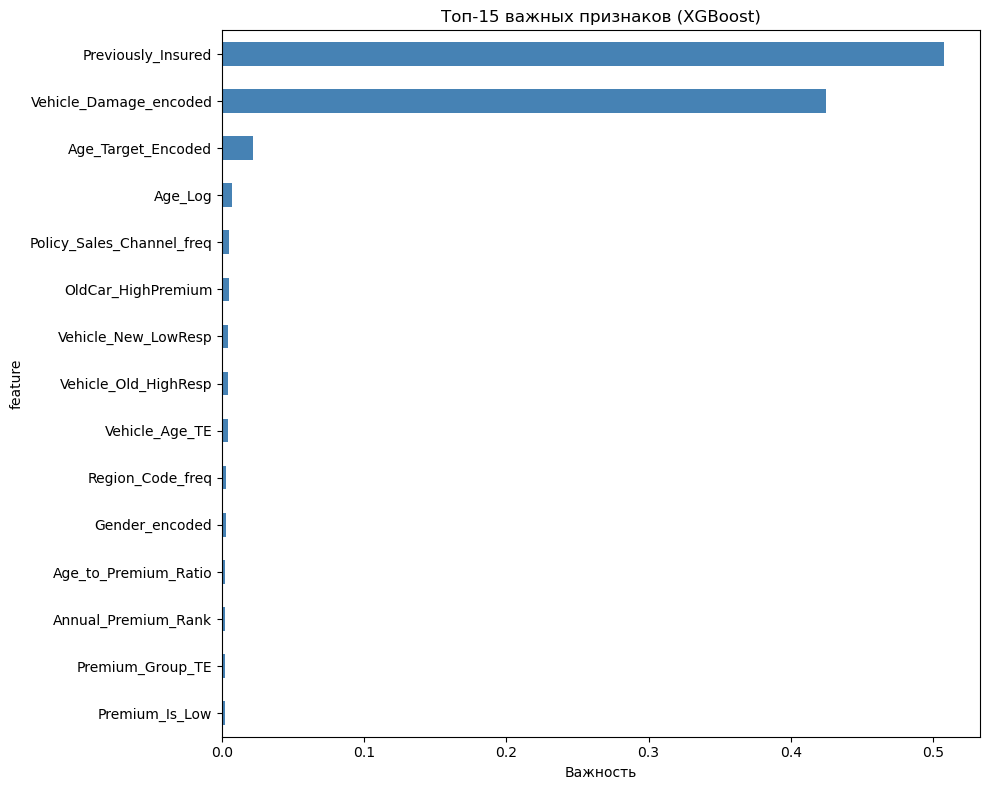


Engineered features в топе:
  ✓ Age_Target_Encoded
  ✓ Vehicle_Age_TE
  ✓ Annual_Premium_Rank
  ✓ Premium_Group_TE
  ✓ Premium_Is_Low
  ✓ Premium_Is_Very_Low
  ✓ Premium_Is_Very_High

Всего engineered features в топ-20: 7/20

Feature Importance: CatBoost
Топ-20 признаков:
 1. Previously_Insured                  31.01
 2. Region_Code_freq                    14.34
 3. Vehicle_Damage_encoded              11.19
 4. Age_Log                             10.97
 5. Policy_Sales_Channel_freq           10.88
 6. Age_to_Premium_Ratio                 5.71
 7. Age_Target_Encoded                   5.53
 8. Annual_Premium_Rank                  4.35
 9. Gender_encoded                       1.67
10. Vehicle_Age_TE                       1.38
11. Premium_Group_TE                     1.13
12. Vehicle_New_LowResp                  1.09
13. Vehicle_Old_HighResp                 0.20
14. Premium_Is_Low                       0.16
15. Premium_Is_Very_Low                  0.16
16. Premium_Is_Very_High            

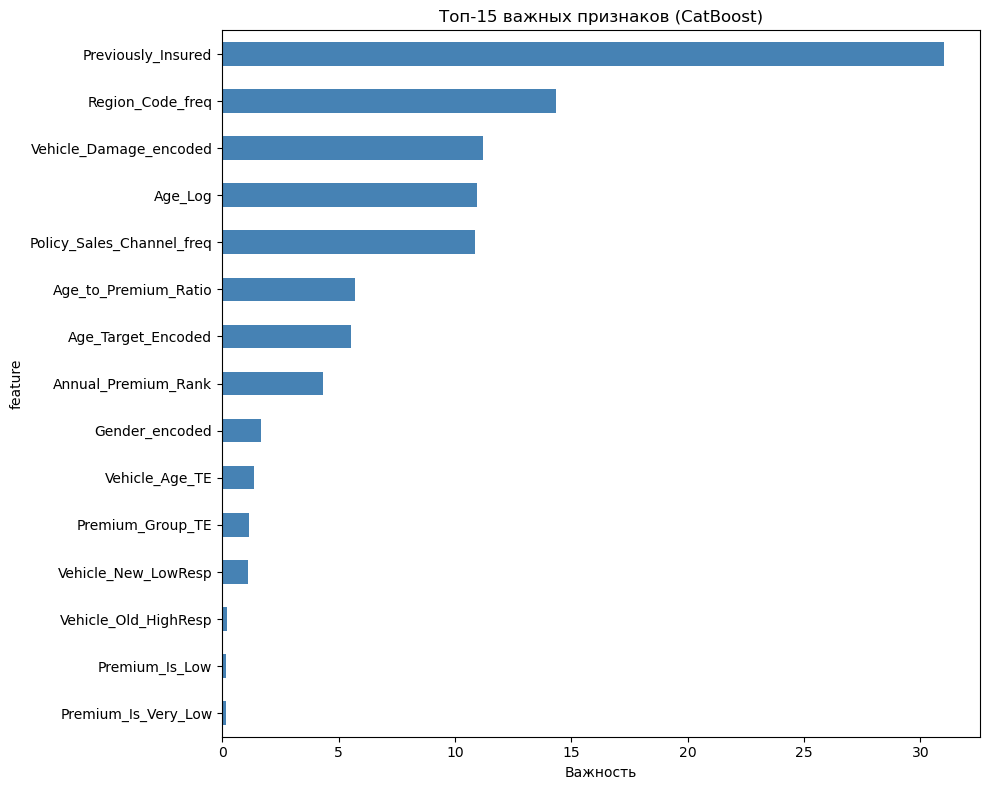


Engineered features в топе:
  ✓ Age_Target_Encoded
  ✓ Annual_Premium_Rank
  ✓ Vehicle_Age_TE
  ✓ Premium_Group_TE
  ✓ Premium_Is_Low
  ✓ Premium_Is_Very_Low
  ✓ Premium_Is_Very_High

Всего engineered features в топ-20: 7/20


In [40]:
def analyze_feature_importance(results, top_n=20):
    """Анализ важности признаков"""
    
    for model_name, result in results.items():
        if result['feature_importances'] is not None:
            print(f"\n{'='*60}")
            print(f"Feature Importance: {model_name}")
            print('='*60)
            
            # Агрегируем importance по фолдам
            importance_df = result['feature_importances']
            mean_importance = importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False)
            
            # Топ-N признаков
            print(f"Топ-{top_n} признаков:")
            top_features = mean_importance.head(top_n)
            
            for i, (feature, importance) in enumerate(top_features.items(), 1):
                print(f"{i:2}. {feature:30} {importance:10.2f}")
            
            # Визуализация
            plt.figure(figsize=(10, 8))
            top_features.head(15).plot(kind='barh', color='steelblue')
            plt.title(f'Топ-15 важных признаков ({model_name})')
            plt.xlabel('Важность')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
            
            # Проверка engineered features
            print("\nEngineered features в топе:")
            engineered_in_top = [f for f in top_features.index if any(
                keyword in f for keyword in ['TE', '_Encoded', '_Rank', 'Nonlinear', 'Is_', 'Peak']
            )]
            for feat in engineered_in_top:
                print(f"  ✓ {feat}")
            
            print(f"\nВсего engineered features в топ-{top_n}: {len(engineered_in_top)}/{top_n}")

# Анализируем важность признаков
analyze_feature_importance(results, top_n=20)

Вывод: В Train у нас 88% значений класса "0". Большой дисбаланс классов.

# Базовая модель и метрики для несбалансированных данных (Baseline Model & Metrics)

В исследуемом датасете присутствует значительный дисбаланс целевой переменной Response (0 - 87.74%, 1 - 12.26%). В задачах с дисбалансом фокус смещается на поиск редкого класса, минимизацию пропусков положительных случаев (false negatives) и управление компромиссом между точностью и полнотой.
Метрика Accuracy в случае дисбаланса бесполезна: Модель, всегда предсказывающая мажоритарный класс (0), достигнет Accuracy 87.74%, но при этом все метрики качества для миноритарного класса будут нулевыми (Precision=0, Recall=0, F1=0).

Ключевые метрики для дисбаланса:
- Precision (точность): Доля верно предсказанных положительных случаев среди всех предсказанных как положительные. Показывает, насколько мы можем доверять положительному предсказанию.
- Recall (полнота): Доля верно найденных положительных случаев среди всех реальных положительных. Показывает, какую часть редкого класса мы обнаруживаем.
- F1-Score: Гармоническое среднее Precision и Recall. Балансирует обе метрики, особенно полезен когда классы несбалансированы.
- ROC-AUC: Площадь под ROC-кривой, показывает способность модели различать классы. Менее чувствительна к дисбалансу.
- PR-AUC (Precision-Recall AUC): Площадь под Precision-Recall кривой. Более информативна при сильном дисбалансе, так как фокусируется на positive классе.
- Confusion Matrix: Наглядное представление ошибок классификации (TP, FP, FN, TN).

Метрика	   | Формула	           | Когда использовать
-----------|-----------------------|----------------------------------
Precision  |	TP/(TP+FP)	       | Когда ложные срабатывания дороги
Recall	   | TP/(TP+FN)	           | Когда пропуски положительных дороги
F1-Score   |	2PR/(P+R)	       | Для общего баланса качества
ROC-AUC	   | Площадь под ROC	   | Для сравнения моделей, ранжирования
PR-AUC	   | Площадь под PR-кривой | При сильном дисбалансе классов

Технические приемы для работы с дисбалансом:
Stratified sampling: Для сохранения пропорций классов используем train_test_split(stratify=y) и StratifiedKFold().
Методы ресэмплинга: SMOTE (oversampling) и RandomUnderSampler для балансировки данных.
Взвешивание классов: Параметр class_weight='balanced' или scale_pos_weight в LightGBM.
Настройка порога: Оптимизация decision threshold для баланса Precision/Recall.

Данная задача взята с Kaggle. По условиям соревнования основной метрикой для оценки является ROC-AUC score. Кроме того, требуется предоставить предсказания в виде вероятности положительного класса (probability of positive class) для тестового набора. Поэтому, основной задачей является максимизация значения ROC-AUC.

В реальных бизнес-задачах выбор метрик зависит от стоимости ошибок. Если false negatives дороги (пропущенные случаи в диагностике, мошенничестве) — максимизируем Recall. Если false positives дороги (ложные срабатывания в спам-фильтре, кредитном скоринге) — максимизируем Precision.


## Обучение базовой модели

По результатам сравнительного анализа моделей на кросс-валидации наилучшие показатели продемонстрировали алгоритмы LightGBM, XGBoost, CatBoost. Выберем в качестве базовой для дальнейших экспериментов модель LightGBM (LGBMClassifier). Для модели LightGBM с помощью кросс-валидации и раннего останова было установлено оптимальное значение количества деревьев n_estimators = 291.  

Процесс обучения базовой модели:

Разделение данных: Исходный набор df_Train разделен на обучающую (Train) и тестовую (Test) выборки в соотношении 80/20 с использованием параметра stratify=y для сохранения исходного распределения классов.

Препроцессинг: К обеим выборкам применена функция preprocess_features_final(), выполняющая удаление неинформативных признаков, кодирование категориальных переменных, обработку непрерывных признаков, создание индикаторных признаков, создание взаимодействий признаков.

Обучение модели: LGBMClassifier обучен на тренировочных данных с дефолтными гиперпараметрами и n_estimators = 291.

Оценка и оптимизация:
Кросс-валидация на Train: Оценка устойчивости модели с использованием StratifiedKFold (5 фолдов)

Оптимальный порог: На тестовой выборке определен порог вероятности, максимизирующий F1-score

Сравнение метрик:
На Train с кросс-валидацией
На Test с порогом по умолчанию (0.5)
На Test с оптимальным порогом

Метрики оценки: ROC-AUC, Precision, Recall, F1-score, Confusion Matrix


In [42]:
from sklearn.model_selection import RandomizedSearchCV

lgb_model = LGBMClassifier(
    objective='binary',
    boosting_type='dart',  # лучше для несбалансированных
    metric='auc',
    n_estimators=500,
    learning_rate=0.01,#0.05,
    num_leaves=63,#31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,#0.5,#0.1,
    reg_lambda=0,#0.1,
    scale_pos_weight=7.15,  # для дисбаланса 87.7%/12.3%
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

# Создаем pipeline
pipeline = Pipeline([
    ('classifier', lgb_model)
])

# Определяем пространство гиперпараметров
param_dist = {
    'classifier__n_estimators': [270,290, 320, 350],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__num_leaves': [15, 31, 63],
    'classifier__reg_alpha': [0, 0.1, 0.5],
    'classifier__reg_lambda': [0, 0.1, 0.5]
}

X = df_train.drop('Response', axis=1)
y = df_train['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Предобработка
X_train_processed, encoders = preprocess_features_final(X_train, y_train, is_train=True)
X_test_processed, _ = preprocess_features_final(X_test, y_test, is_train=False, encoders=encoders)

# RandomizedSearch с кросс-валидацией
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,  # количество комбинаций
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # Стратифицированная кросс-валидация (важно для несбалансированных данных)
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Поиск лучших параметров
random_search.fit(X_train_processed, y_train)

print(f"Лучшие параметры: {random_search.best_params_}")
print(f"Лучший ROC-AUC (CV): {random_search.best_score_:.4f}")

# Используем лучшую модель
best_model = random_search.best_estimator_

# Финальная оценка
y_pred = best_model.predict(X_test_processed)
y_proba = best_model.predict_proba(X_test_processed)[:, 1]

print("\n=== ФИНАЛЬНАЯ ОЦЕНКА НА TEST ===")
print(f'ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}')
print(f'PR-AUC: {average_precision_score(y_test, y_proba):.4f}')
print(f'F1: {f1_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_pred):.4f}')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Лучшие параметры: {'classifier__reg_lambda': 0.5, 'classifier__reg_alpha': 0.5, 'classifier__num_leaves': 63, 'classifier__n_estimators': 320, 'classifier__learning_rate': 0.1}
Лучший ROC-AUC (CV): 0.8566

=== ФИНАЛЬНАЯ ОЦЕНКА НА TEST ===
ROC-AUC: 0.8575
PR-AUC: 0.3701
F1: 0.4373
Precision: 0.2868
Recall: 0.9210


In [43]:
# LightGBM (Быстрый Gradient Boosting)
lgb_model = LGBMClassifier(
    objective='binary',
    boosting_type='dart',  # лучше для несбалансированных
    metric='auc',
    n_estimators=320,
    learning_rate=0.1,#0.05,
    num_leaves=63,#31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,#0.1,
    reg_lambda=0.5,#0.1,
    scale_pos_weight=7.15,  # для дисбаланса 87.7%/12.3%
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)



Оценка модели: LightGBM
  F1-score: 0.4359 ± 0.0017
  PR-AUC: 0.3701
  Test ROC-AUC: 0.8575
  Test F1-score: 0.4373

РЕЗУЛЬТАТЫ КРОСС-ВАЛИДАЦИИ на обучающей выборке:
          ROC-AUC_mean   F1_mean  Precision_mean  Recall_mean
LightGBM      0.857027  0.435896        0.285682     0.919262

РЕЗУЛЬТАТЫ на тестовой выборке:
          ROC-AUC_mean  F1_mean  Precision_mean  Recall_mean
LightGBM      0.857484  0.43734        0.286752     0.921002

РЕЗУЛЬТАТЫ на тестовой выборке с оптимальным порогом
          ROC-AUC_mean   F1_mean  Precision_mean  Recall_mean  threshold
LightGBM      0.857484  0.458766        0.328243     0.761614   0.669209


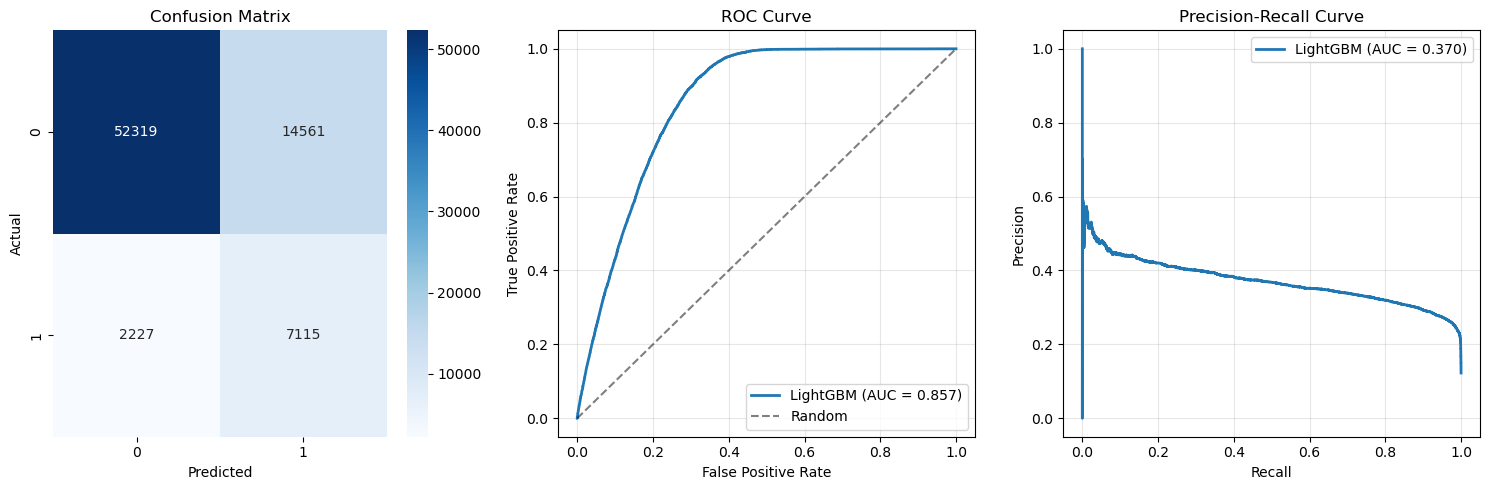

In [44]:
# Визуализация
def plot_model_curve(y_test_prm, y_test_proba_prm, y_pred_prm):
 
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Матрица ошибок
    cm = confusion_matrix(y_test_prm, y_pred_prm)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # ROC-кривая
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test_prm, y_test_proba_prm)
    axes[1].plot(fpr, tpr, label=f'LightGBM (AUC = {roc_auc_score(y_test_prm, y_test_proba_prm):.3f})', linewidth=2)
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Precision-Recall кривая
    from sklearn.metrics import precision_recall_curve
    precision, recall, _ = precision_recall_curve(y_test_prm, y_test_proba_prm)
    axes[2].plot(recall, precision, label=f'LightGBM (AUC = {average_precision_score(y_test_prm, y_test_proba_prm):.3f})', linewidth=2)
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def create_base_model(models):
    from sklearn.calibration import CalibratedClassifierCV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    X = df_train.drop('Response', axis=1)
    y = df_train['Response']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Предобработка
    X_train_processed, encoders = preprocess_features_final(X_train, y_train, is_train=True)
    X_test_processed, _ = preprocess_features_final(X_test, y_test, is_train=False, encoders=encoders)

    results_train = {}
    results_test = {}
    results_threshold = {}
    trained_models = {}  # Словарь для хранения обученных моделей

    for name, model in models.items():    
        print(f"\nОценка модели: {name}")
    
        try:
            # Кросс-валидация для оценки
            y_proba = cross_val_predict(model, X_train_processed, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
            auc_cv = roc_auc_score(y_train, y_proba) 

            f1_scores = cross_val_score(model, X_train_processed, y_train, cv=cv, scoring='f1', n_jobs=-1, error_score='raise')
            precision_scores = cross_val_score(model, X_train_processed, y_train, cv=cv, scoring='precision', n_jobs=-1, error_score='raise')
            recall_scores = cross_val_score(model, X_train_processed, y_train, cv=cv, scoring='recall', n_jobs=-1, error_score='raise')
        
            # Сохраняем результаты кросс-валидации
            results_train[name] = {
                'ROC-AUC_mean': auc_cv,#auc_scores.mean(),
                'ROC-AUC_std': 0,#auc_scores.std(),
                'F1_mean': f1_scores.mean(),
                'F1_std': f1_scores.std(),
                'Precision_mean': precision_scores.mean(),
                'Precision_std': precision_scores.std(),
                'Recall_mean': recall_scores.mean(),
                'Recall_std': recall_scores.std()
            }
        
            #print(f"  ROC-AUC: {auc_scores.mean():.4f} ± {auc_scores.std():.4f}")
            print(f"  F1-score: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
        
            # Обучаем модель на всех тренировочных данных для предсказания на тесте
            model.fit(X_train_processed, y_train)
            #model=fit_model_with_early_stopping(model, X_train_processed, y_train, X_test_processed, y_test,model_name='LightGBM')
    
            trained_models[name] = model  # Сохраняем обученную модель
        
            # Предсказания на тестовой выборке
            y_test_pred = model.predict(X_test_processed)
            y_test_proba = model.predict_proba(X_test_processed)[:, 1]
        
            # Метрики на тестовой выборке
            results_test[name] = {
                'ROC-AUC_mean': roc_auc_score(y_test, y_test_proba),
                'ROC-AUC_std': 0,
                'F1_mean': f1_score(y_test, y_test_pred),
                'F1_std': 0,
                'Precision_mean': precision_score(y_test, y_test_pred),
                'Precision_std': 0,
                'Recall_mean': recall_score(y_test, y_test_pred),
                'Recall_std': 0
            }
        
            print(f"  PR-AUC: {average_precision_score(y_test, y_test_proba):.4f}")
            print(f"  Test ROC-AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
            print(f"  Test F1-score: {f1_score(y_test, y_test_pred):.4f}")
            
            # Подбор порога по метрике F1
            precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
            # Найти порог, максимизирующий F1
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
            # Применить новый порог
            y_pred_optimized = (y_test_proba >= optimal_threshold).astype(int)
            # Метрики с применением оптимального порога
            results_threshold[name] = {
                'ROC-AUC_mean': roc_auc_score(y_test, y_test_proba),
                'ROC-AUC_std': 0,
                'F1_mean': f1_score(y_test, y_pred_optimized),
                'F1_std': 0,
                'Precision_mean': precision_score(y_test, y_pred_optimized),
                'Precision_std': 0,
                'Recall_mean': recall_score(y_test, y_pred_optimized),
                'Recall_std': 0,
                'threshold': optimal_threshold
            }         
        
        except Exception as e:
            print(f"  Ошибка при оценке {name}: {e}")
            results_train[name] = {'error': str(e)}
            results_test[name] = {'error': str(e)}

    # Вывод результатов в таблице
    print("\n" + "="*60)
    print("РЕЗУЛЬТАТЫ КРОСС-ВАЛИДАЦИИ на обучающей выборке:")
    print("="*60)

    results_train_df = pd.DataFrame(results_train).T
    if 'error' not in results_train_df.columns:
        print(results_train_df[['ROC-AUC_mean', 'F1_mean', 'Precision_mean', 'Recall_mean']])
    else:
        print(results_train_df)

    print("\n" + "="*60)
    print("РЕЗУЛЬТАТЫ на тестовой выборке:")
    print("="*60)

    results_test_df = pd.DataFrame(results_test).T
    if 'error' not in results_test_df.columns:
        print(results_test_df[['ROC-AUC_mean', 'F1_mean', 'Precision_mean', 'Recall_mean']])
    else:
        print(results_test_df)

    print("\n" + "="*60)
    print("РЕЗУЛЬТАТЫ на тестовой выборке с оптимальным порогом")
    print("="*60)

    results_threshold_df = pd.DataFrame(results_threshold).T
    if 'error' not in results_threshold_df.columns:
        print(results_threshold_df[['ROC-AUC_mean', 'F1_mean', 'Precision_mean', 'Recall_mean', 'threshold']])
    else:
        print(results_threshold_df)    

    plot_model_curve(y_test, y_test_proba, y_pred_optimized)
    

# Словарь моделей
models = {
    #'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),  # Простая базовая модель
    #'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'), # Bagging алгоритм, устойчивый к переобучению
    #'XGBoost': xgb_model
    #'CatBoost': cat_model,    
    'LightGBM': lgb_model
}

create_base_model(models)
      

Калибровка

Некоторые алгоритмы машинного обучения, особенно tree-based (LightGBM, XGBoost, RandomForest), выдают "переуверенные" вероятности — например, присваивают 90% вероятность событию, которое происходит только в 70% случаев. Калибровка исправляет это, корректируя выходные вероятности модели, чтобы они лучше соответствовали реальным частотам событий.

Мы проведем кросс-валидационную калибровку методом Isotonic Regression (она лучше подходит для больших выборок), которая обучает калибровочную функцию на отдельной части данных, чтобы избежать переобучения.

In [45]:
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import cross_val_predict
from sklearn.calibration import CalibratedClassifierCV

lgb_model = LGBMClassifier(
    objective='binary',
    boosting_type='dart',  # лучше для несбалансированных
    metric='auc',
    n_estimators=320,
    learning_rate=0.1,#0.05,
    num_leaves=63,#31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,#0.1,
    reg_lambda=0.5,#0.1,
    scale_pos_weight=7.15,  # для дисбаланса 87.7%/12.3%
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)


X = df_train.drop('Response', axis=1)
y = df_train['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Предобработка
X_train_processed, encoders = preprocess_features_final(X_train, y_train, is_train=True)
X_test_processed, _ = preprocess_features_final(X_test, y_test, is_train=False, encoders=encoders)


# Калибровка с кросс-валидацией
calibrated = CalibratedClassifierCV(
    lgb_model,
    method='isotonic',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
)

# Обучаем и калибруем на всей тренировочной выборке
calibrated.fit(X_train_processed, y_train)

# Получаем калиброванные вероятности
y_proba_calibrated = calibrated.predict_proba(X_test_processed)[:, 1]

# Находим новый оптимальный порог
precision_cal, recall_cal, thresholds_cal = precision_recall_curve(y_test, y_proba_calibrated)
f1_scores_cal = 2 * (precision_cal * recall_cal) / (precision_cal + recall_cal + 1e-10)
optimal_idx = np.argmax(f1_scores_cal)
optimal_thresh_cal = thresholds_cal[optimal_idx]
y_pred_optimized = (y_proba_calibrated >= optimal_thresh_cal).astype(int)

#print(f"Оптимальный порог до калибровки: {optimal_threshold:.3f}")
print(f"Оптимальный порог после калибровки: {optimal_thresh_cal:.3f}")
print(f"  PR-AUC: {average_precision_score(y_test, y_proba_calibrated):.4f}")
print(f"  Test ROC-AUC: {roc_auc_score(y_test, y_proba_calibrated):.4f}")
print(f"  Test F1-score: {f1_score(y_test, y_pred_optimized):.4f}")
print(f'  Precision: {precision_score(y_test, y_pred_optimized):.4f}')
print(f'  Recall: {recall_score(y_test, y_pred_optimized):.4f}')               


Оптимальный порог после калибровки: 0.233
  PR-AUC: 0.3703
  Test ROC-AUC: 0.8576
  Test F1-score: 0.4591
  Precision: 0.3295
  Recall: 0.7568


Выводы: 

- ROC-AUC достаточно высок (0.8576) - модель отлично разделяет классы; 
- Отсутствие переобучения - метрики на train и test практически идентичны;
- Стабильность (низкое std) - F1-score ±0.0017 показывает надежность;

- Низкая Precision (~0.29-0.33) - только 29-33% предсказанных "1" действительно;
- Не высокий F1-score (~0.46) - из-за низкой Precision;

Модель без подбора порога дает высокий Recall (0.921), т.е. модель "ловит всё", но с большим количеством ложных срабатываний.
Модель с оптимизацией порога (0.669) находит меньше случаев (Recall = 0.76), но качество предсказаний выше (Precision = 0.328) и имеет лучший баланс (F1 = 0.46).
Модель с калибровкой и порогом (0.233) не дала значимых улучшений, относительно модели с порогом 0.669.

Из этих моделей для наших целей лучше подходит модель с порогом 0.669. Она обладает высоким ROC-AUC и обладает большоей сбалансированностью. 

## SMOTE + UnderSampling

Попробуем использовать комбинированный метод решения проблемы дисбаланса.

UnderSampling (Недостовыборка) — удаляет наблюдения из мажоритарного класса, чтобы приблизить его размер к размеру миноритарного класса. В комбинации со SMOTE часто используют не случайный, а очищающий андерсэмплинг (напр., Tomek Links), целенаправленно удаляющий примеры в зоне неопределенности.

SMOTE (Synthetic Minority Over-sampling Technique) — увеличивает количество примеров миноритарного класса путем создания синтетических примеров. Алгоритм для каждого примера находит k ближайших соседей, случайно выбирает одного и создает новый пример в случайной точке отрезка между ними.

Совместное применение (обычно сначала SMOTE, затем очищающий UnderSampling) дает синергетический эффект: происходит не просто уравнивание количества, но и улучшение качества разделяющей границы за счет "очистки" пространства признаков от конфликтующих примеров.

Основные преимущества комбинации:
- Уменьшение области перекрытия классов.
- Сохранение ключевой информации мажоритарного класса за счет целенаправленного, а не случайного удаления.
- Создание более четко разделимого датасета по сравнению с использованием только SMOTE.

Критически важные практические аспекты:
- Балансировка — часть пайплайна обучения: SMOTE и UnderSampling должны применяться только к тренировочному фолду внутри каждой итерации кросс-валидации. Применение до разделения выборки приводит к data leakage и некорректной оценке модели.
- Не сочетать с внутренней балансировкой модели: Не рекомендуется одновременно использовать внешнюю балансировку (SMOTE) и параметры типа scale_pos_weight в XGBoost/LightGBM без необходимости — это может дать избыточный эффект и ухудшить результат.
- Параметр k_neighbors в SMOTE: Должен быть меньше текущего количества примеров миноритарного класса в тренировочном фолде.
- Структура валидации: Для итоговой оценки модели, обученной с таким пайплайном, необходимо использовать hold-out test set или nested cross-validation.

Быстрая прикидка SMOTE на выбранной модели:

In [46]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

lgb_model = LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=291,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

X = df_train.drop('Response', axis=1)
y = df_train['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Предобработка
X_train_processed, encoders = preprocess_features_final(X_train, y_train, is_train=True)
X_test_processed, _ = preprocess_features_final(X_test, y_test, is_train=False, encoders=encoders)

# Pipeline с сэмплингом
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
    ('classifier', lgb_model)
])

# Обучение
pipeline.fit(X_train_processed, y_train)

# Прогноз на ПРЕОБРАЗОВАННЫХ данных
y_pred = pipeline.predict(X_test_processed)
y_proba = pipeline.predict_proba(X_test_processed)[:, 1]

# Метрики
print(f'ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}')
print(f'PR-AUC: {average_precision_score(y_test, y_proba):.4f}')
print(f'F1: {f1_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_pred):.4f}')

ROC-AUC: 0.8550
PR-AUC: 0.3617
F1: 0.4275
Precision: 0.3578
Recall: 0.5309


SMOTE на кросс-валидации

In [47]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Создаем pipeline
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
    ('classifier', lgb_model)
])

# Стратифицированная кросс-валидация (важно для несбалансированных данных)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Метрики для оценки
scoring = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'accuracy': 'accuracy'
}

# Кросс-валидация
cv_results = cross_validate(
    pipeline,
    X_train_processed,  # используем только train данные
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,  # параллельные вычисления
    return_train_score=True  # чтобы видеть метрики на train
)

# Вывод результатов кросс-валидации
print("=== КРОСС-ВАЛИДАЦИЯ (5 фолдов) ===")
print(f"ROC-AUC: {np.mean(cv_results['test_roc_auc']):.4f} (+/- {np.std(cv_results['test_roc_auc']):.4f})")
print(f"F1: {np.mean(cv_results['test_f1']):.4f} (+/- {np.std(cv_results['test_f1']):.4f})")
print(f"Precision: {np.mean(cv_results['test_precision']):.4f} (+/- {np.std(cv_results['test_precision']):.4f})")
print(f"Recall: {np.mean(cv_results['test_recall']):.4f} (+/- {np.std(cv_results['test_recall']):.4f})")

# Обучение финальной модели на всех train данных
pipeline.fit(X_train_processed, y_train)

# Финальная оценка на test наборе
y_pred = pipeline.predict(X_test_processed)
y_proba = pipeline.predict_proba(X_test_processed)[:, 1]

print("\n=== ФИНАЛЬНАЯ ОЦЕНКА НА TEST ===")
print(f'ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}')
print(f'PR-AUC: {average_precision_score(y_test, y_proba):.4f}')
print(f'F1: {f1_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_pred):.4f}')

=== КРОСС-ВАЛИДАЦИЯ (5 фолдов) ===
ROC-AUC: 0.8547 (+/- 0.0016)
F1: 0.4241 (+/- 0.0047)
Precision: 0.3583 (+/- 0.0037)
Recall: 0.5197 (+/- 0.0094)

=== ФИНАЛЬНАЯ ОЦЕНКА НА TEST ===
ROC-AUC: 0.8550
PR-AUC: 0.3617
F1: 0.4275
Precision: 0.3578
Recall: 0.5309


SMOTE + подбор параметров с помощью GridSearch с кросс-валидацией

In [48]:
from sklearn.model_selection import RandomizedSearchCV

# Создаем pipeline
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
    ('classifier', lgb_model)
])

# Определяем пространство гиперпараметров
param_dist = {
    'classifier__n_estimators': [291, 500, 800, 1000],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__num_leaves': [15, 31, 63],
    'classifier__reg_alpha': [0, 0.1, 0.5],
    'classifier__reg_lambda': [0, 0.1, 0.5],
    'smote__sampling_strategy': [0.2, 0.3, 0.4],  # подбираем параметры SMOTE
    'undersample__sampling_strategy': [0.5, 0.6, 0.7]  # подбираем параметры undersampling
}

# RandomizedSearch с кросс-валидацией
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,  # количество комбинаций
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # Стратифицированная кросс-валидация (важно для несбалансированных данных)
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Поиск лучших параметров
random_search.fit(X_train_processed, y_train)

print(f"Лучшие параметры: {random_search.best_params_}")
print(f"Лучший ROC-AUC (CV): {random_search.best_score_:.4f}")

# Используем лучшую модель
best_model = random_search.best_estimator_

# Финальная оценка
y_pred = best_model.predict(X_test_processed)
y_proba = best_model.predict_proba(X_test_processed)[:, 1]

print("\n=== ФИНАЛЬНАЯ ОЦЕНКА НА TEST ===")
print(f'ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}')
print(f'PR-AUC: {average_precision_score(y_test, y_proba):.4f}')
print(f'F1: {f1_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_pred):.4f}')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Лучшие параметры: {'undersample__sampling_strategy': 0.5, 'smote__sampling_strategy': 0.2, 'classifier__reg_lambda': 0, 'classifier__reg_alpha': 0, 'classifier__num_leaves': 15, 'classifier__n_estimators': 500, 'classifier__learning_rate': 0.05}
Лучший ROC-AUC (CV): 0.8561

=== ФИНАЛЬНАЯ ОЦЕНКА НА TEST ===
ROC-AUC: 0.8567
PR-AUC: 0.3690
F1: 0.4563
Precision: 0.3380
Recall: 0.7020


Исползуем полученные лучшие параметры модели и undersample. 

SMOTE + подбор порога

In [49]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_recall_curve

lgb_model = LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=15,#31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,#0.1,
    reg_lambda=0,#0.1,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

X = df_train.drop('Response', axis=1)
y = df_train['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Предобработка
X_train_processed, encoders = preprocess_features_final(X_train, y_train, is_train=True)
X_test_processed, _ = preprocess_features_final(X_test, y_test, is_train=False, encoders=encoders)

# Pipeline с сэмплингом
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.2, random_state=42)),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
    ('classifier', lgb_model)
])

# Обучение
pipeline.fit(X_train_processed, y_train)

# Прогноз на ПРЕОБРАЗОВАННЫХ данных
y_pred = pipeline.predict(X_test_processed)
y_proba = pipeline.predict_proba(X_test_processed)[:, 1]

# Подбор порога по метрике F1
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Найти порог, максимизирующий F1
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Применить новый порог
y_pred_optimized = (y_proba >= optimal_threshold).astype(int)

# Метрики
print(f'Порог: {optimal_threshold}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}')
print(f'PR-AUC: {average_precision_score(y_test, y_proba):.4f}')
print(f'F1: {f1_score(y_test, y_pred_optimized):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_optimized):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_optimized):.4f}')

Порог: 0.4905347369268198
ROC-AUC: 0.8567
PR-AUC: 0.3690
F1: 0.4575
Precision: 0.3350
Recall: 0.7215


SMOTE + Калибровка + подбор порога

In [50]:
#from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')

class AdvancedSMOTECalibratedPipeline:
    """Пайплайн с вложенной кросс-валидацией"""
    
    def __init__(self, base_model, n_folds_outer=5, n_folds_inner=3, 
                 smote_strategy=0.3, undersample_strategy=0.5):
        self.base_model = base_model
        self.n_folds_outer = n_folds_outer
        self.n_folds_inner = n_folds_inner
        self.smote_strategy = smote_strategy
        self.undersample_strategy = undersample_strategy
        self.calibrated_models = []
        self.calibration_data = []
        
    def fit(self, X, y):
        from imblearn.over_sampling import SMOTE
        from imblearn.under_sampling import RandomUnderSampler
        
        skf_outer = StratifiedKFold(n_splits=self.n_folds_outer, 
                                    shuffle=True, random_state=42)
        
        # Для каждого фолда внешней CV
        for fold_idx, (train_idx, calib_idx) in enumerate(skf_outer.split(X, y)):
            X_train, X_calib = X.iloc[train_idx], X.iloc[calib_idx]
            y_train, y_calib = y.iloc[train_idx], y.iloc[calib_idx]
            
            print(f"Обучение фолда {fold_idx + 1}/{self.n_folds_outer}")
            
            # Внутренняя кросс-валидация для калибровки
            skf_inner = StratifiedKFold(n_splits=self.n_folds_inner, 
                                        shuffle=True, random_state=42)
            
            # Применяем SMOTE и undersampling только к тренировочным данным
            smote = SMOTE(sampling_strategy=self.smote_strategy, 
                         random_state=42)
            rus = RandomUnderSampler(sampling_strategy=self.undersample_strategy, 
                                   random_state=42)
            
            # Resample только тренировочные данные
            X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
            X_train_res, y_train_res = rus.fit_resample(X_train_res, y_train_res)
            
            # Обучаем базовую модель
            model_clone = clone(self.base_model)
            model_clone.fit(X_train_res, y_train_res)
            
            # Калибруем на валидационных данных (без SMOTE)
            calibrator = CalibratedClassifierCV(
                model_clone,
                method='isotonic',
                cv=skf_inner
            )
            calibrator.fit(X_calib, y_calib)
            
            self.calibrated_models.append(calibrator)
            self.calibration_data.append((X_calib, y_calib))
            
        # Финальная модель на всех данных
        self.final_smote = SMOTE(sampling_strategy=self.smote_strategy, 
                                random_state=42)
        self.final_rus = RandomUnderSampler(sampling_strategy=self.undersample_strategy, 
                                          random_state=42)
        
        X_res, y_res = self.final_smote.fit_resample(X, y)
        X_res, y_res = self.final_rus.fit_resample(X_res, y_res)
        
        self.final_model_ = clone(self.base_model).fit(X_res, y_res)
        
        # Калибруем финальную модель на всей выборке
        self.final_calibrator_ = CalibratedClassifierCV(
            self.final_model_,
            method='isotonic',
            cv=self.n_folds_inner
        )
        self.final_calibrator_.fit(X, y)  # калибруем на исходных данных!
        
        return self
    
    def predict_proba(self, X, use_ensemble=True):
        """Предсказание вероятностей"""
        if use_ensemble and len(self.calibrated_models) > 0:
            # Ансамблирование предсказаний от всех фолдов
            probas = []
            for calibrator in self.calibrated_models:
                proba = calibrator.predict_proba(X)[:, 1]
                probas.append(proba)
            
            # Усреднение
            return np.column_stack([
                1 - np.mean(probas, axis=0),
                np.mean(probas, axis=0)
            ])
        else:
            # Используем финальную модель
            return self.final_calibrator_.predict_proba(X)
    
    def predict(self, X, threshold=0.5, use_ensemble=True):
        proba = self.predict_proba(X, use_ensemble)[:, 1]
        return (proba >= threshold).astype(int)
    
    def get_calibration_curves(self):
        """Визуализация калибровочных кривых для каждого фолда"""
        import matplotlib.pyplot as plt
        from sklearn.calibration import calibration_curve
        
        fig, axes = plt.subplots(1, self.n_folds_outer, figsize=(15, 4))
        
        for idx, (calibrator, (X_calib, y_calib)) in enumerate(zip(self.calibrated_models, self.calibration_data)):
            y_proba = calibrator.predict_proba(X_calib)[:, 1]
            prob_true, prob_pred = calibration_curve(y_calib, y_proba, n_bins=10)
            
            ax = axes[idx] if self.n_folds_outer > 1 else axes
            ax.plot(prob_pred, prob_true, 's-', label=f'Фолд {idx+1}')
            ax.plot([0, 1], [0, 1], 'k:', label='Идеально')
            ax.set_xlabel('Предсказанная вероятность')
            ax.set_ylabel('Фактическая доля')
            ax.set_title(f'Фолд {idx+1}')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

        

Обучение фолда 1/3
Обучение фолда 2/3
Обучение фолда 3/3


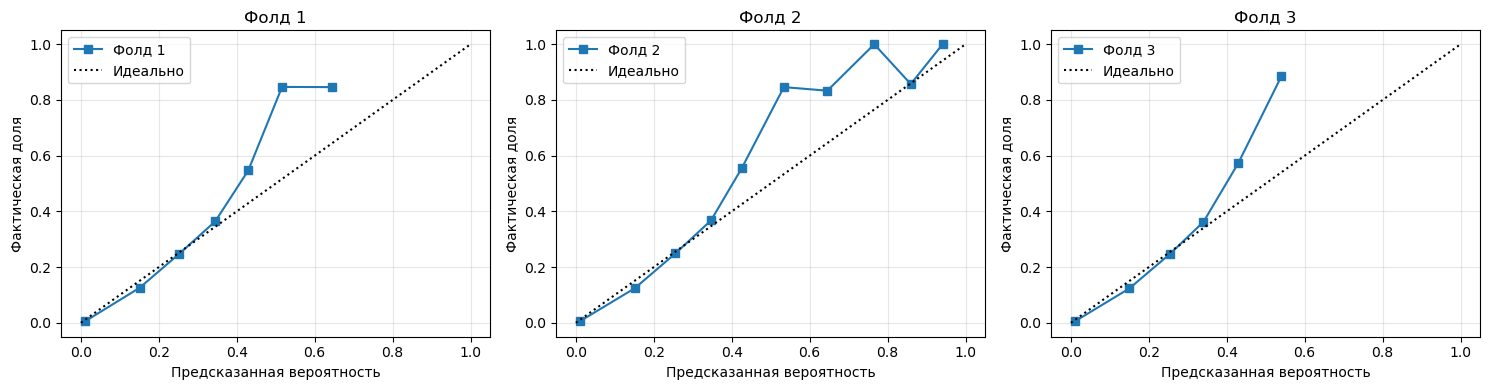

Порог: 0.21493721128976495
ROC-AUC: 0.8571
PR-AUC: 0.3709
F1: 0.4568
Precision: 0.3215
Recall: 0.7887


In [51]:
# Создаем базовую модель LightGBM
lgb_model = LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=15,#31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,#0.1,
    reg_lambda=0,#0.1,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)
    
X = df_train.drop('Response', axis=1)
y = df_train['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Предобработка
X_train_processed, encoders = preprocess_features_final(X_train, y_train, is_train=True)
X_test_processed, _ = preprocess_features_final(X_test, y_test, is_train=False, encoders=encoders)

# pipeline с кросс-валидацией
advanced_pipeline = AdvancedSMOTECalibratedPipeline(
    base_model=lgb_model,
    n_folds_outer=3,  # меньше фолдов для скорости
    n_folds_inner=3,
    smote_strategy=0.2, 
    undersample_strategy=0.5
)
advanced_pipeline.fit(X_train_processed, y_train)

# Визуализация калибровки
advanced_pipeline.get_calibration_curves()

# Предсказания
y_pred_ensemble =  advanced_pipeline.predict(X_test_processed)
y_proba_ensemble = advanced_pipeline.predict_proba(X_test_processed)[:, 1]

# Подбор порога по метрике F1
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_ensemble)

# Найти порог, максимизирующий F1
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Применить новый порог
y_predict_ensemble_optimized = (y_proba_ensemble >= optimal_threshold).astype(int)

# Метрики
print(f'Порог: {optimal_threshold}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_proba_ensemble):.4f}')
print(f'PR-AUC: {average_precision_score(y_test, y_proba_ensemble):.4f}')
print(f'F1: {f1_score(y_test, y_predict_ensemble_optimized):.4f}')
print(f'Precision: {precision_score(y_test, y_predict_ensemble_optimized):.4f}')
print(f'Recall: {recall_score(y_test, y_predict_ensemble_optimized):.4f}')


РЕЗУЛЬТАТЫ ОЦЕНКИ базовой модели со SMOTE+Undersample НА TEST:

 LGBMClassifier с SMOTE+Undersample         | ROC-AUC_mean |  PR-AUC |  F1_mean | Precision_mean | Recall_mean |
--------------------------------------------|--------------|---------|----------|----------------|-------------|
без настройки порога                        | 0.8550       |  0.3617 |  0.4275  | 0.3578         | 0.5309      |
с лучшими параметрами по GridSearch         | 0.8567       |  0.3690 |  0.4563  | 0.3380         | 0.7020      |
с оптимальным порогом (0.491)               | 0.8567       |  0.3690 |  0.4575  | 0.3350         | 0.7215      |
с калибровкой и оптимальным порогом (0.215) | 0.8571       |  0.3709 |  0.4568  | 0.3215         | 0.7887      |

Выводы: 
Без настройки порога (threshold = 0.5) Recall (0.5309) > Precision (0.3578) - модель пропускает почти половину положительных случаев.
Подбор параметров с помощью GridSearch помог найти модель с хорошей разделительной способностью (вырос Recall до 0.7020).
Калибровка вероятностей сделала предсказанные вероятности более достоверными, что позволило снизить порог классификации без потери качества. Разделительная способность улучшилась (Recall вырос значительно (0.7215 → 0.7887)).

При использовании алгоритма SMOTE+Undersample совместно с LGBMClassifier наилучшие результаты (ROC-AUC=0.8571 и F1=0.4568) получаются после проведения калибровки вероятностей и с оптимальным порогом 0.215.
PR-AUC низкий (0.3709) - Модель плохо справляется с детектированием меньшего класса. 

# Применение ансамблевых методов (Voting и Stacking)

Теперь, попробуем применить ансамбли. 
Почему ансамбли могут помочь при дисбалансе:
- Разные модели по-разному ошибаются на миноритарном классе. Ансамбль усредняет эти ошибки.
- Ансамбль более устойчив к переобучению.
- Ансамбли позволяют работать на исходных данных (с весами классов), на SMOTE-данных, на undersampled данных, применять разные алгоритмы.


## Blending моделей (с использованием встроенных параметров моделей для балансировки) 
В качестве простого ансамблевого подхода используем Blending. Blending (усреднение) — это ансамблевый метод, который комбинирует предсказания нескольких разнородных моделей путём взвешенного усреднения их выходных вероятностей. В отличие от Stacking, где мета-модель обучается на предсказаниях базовых моделей, Blending использует фиксированную (часто линейную) функцию агрегации.

**Реализация:**
Используем `VotingClassifier` из scikit-learn с параметром `voting='soft'`, что позволяет работать с вероятностями классов вместо жёстких предсказаний.

**Математическая формализация:**
Для K моделей и весов w₁, w₂, ..., wₚ (∑wᵢ = 1), итоговая вероятность вычисляется как:
P(y=1|x) = w₁·P₁(y=1|x) + w₂·P₂(y=1|x) + ... + wₚ·Pₚ(y=1|x),
где Pᵢ(y=1|x) — вероятность положительного класса от i-й модели.

**Особенности и ограничения:**
1. **Линейность комбинации**: VotingClassifier реализует линейное взвешенное усреднение, что может быть субоптимальным при наличии нелинейных зависимостей между предсказаниями моделей
2. **Учёт дисбаланса**: Каждая базовая модель настраивается с использованием встроенных механизмов балансировки классов (class_weight, scale_pos_weight и др.)
3. **Интерпретируемость**: Веса моделей имеют прямую интерпретацию — вклад каждой модели в итоговое предсказание
4. **Вычислительная эффективность**: Простота реализации и низкие вычислительные затраты на инференс

In [55]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, average_precision_score
from sklearn.calibration import CalibratedClassifierCV

def train_and_evaluate_improved(X_train, y_train, X_test, y_test, voting):
    """Обучение и оценка улучшенной модели"""
    
    # 1. CatBoost с балансировкой
    #from catboost import CatBoostClassifier
    #catboost = CatBoostClassifier(
    #    #auto_class_weights='Balanced',
    #    scale_pos_weight=7.2,
    #    iterations=1000,
    #    learning_rate=0.05,
    #    depth=6,
    #    verbose=0,
    #    random_seed=42,
    #    eval_metric='Precision'  # оптимизируем PR-AUC!
    #)
    
    # 2. Обучение
    voting.fit(X_train, y_train)
    
    # 3. Прогноз
    y_proba = voting.predict_proba(X_test)[:, 1]
    
    # 3.1 Калибровка (результат не улучшила, поэтому закомментил)
    #calibrated_voting = CalibratedClassifierCV(
    #    voting,  # уже обученный Voting
    #    method='isotonic',
    #    cv=5
    #    )

    # Переобучаем на тех же данных 
    #calibrated_voting.fit(X_train, y_train)

    #y_proba = calibrated_voting.predict_proba(X_test)[:, 1]

    # 4. Находим оптимальный порог по PR-кривой
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    
    # F1 для каждого порога
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    y_pred_optimal = (y_proba > optimal_threshold).astype(int)
    
    # 5. Метрики
    metrics = {
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'PR-AUC': average_precision_score(y_test, y_proba),
        'F1-Score': f1_scores[optimal_idx],
        'Precision': precision[optimal_idx],
        'Recall': recall[optimal_idx],
        'Optimal Threshold': optimal_threshold
    }
    
    return metrics, y_pred_optimal, y_proba

# Применение
X = df_train.drop('Response', axis=1)
y = df_train['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Предобработка
X_train_processed, encoders = preprocess_features_final(X_train, y_train, is_train=True)
X_test_processed, encoders = preprocess_features_final(X_test, y_test, is_train=False, encoders=encoders)

cat_model = CatBoostClassifier(
        iterations=500,  # меньше для скорости
        learning_rate=0.05,
        depth=6,
        auto_class_weights='Balanced',
        verbose=0,
        random_state=42   
    )

# XGBoost (Gradient Boosting с регуляризацией)
xgb_model = XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            n_estimators=254,#200,
            learning_rate=0.01,
            scale_pos_weight=7.15,
            random_state=42,
            n_jobs=-1,
            enable_categorical=False  # Убедимся, что это установлено
        )

lgb_model = LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=291,#1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    scale_pos_weight=7.15,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)


from sklearn.ensemble import VotingClassifier
# Ансамбль разных моделей
model = VotingClassifier(
    estimators=[
        ('catboost', cat_model),#CatBoostClassifier(verbose=0, auto_class_weights='Balanced')),
        #('XGBoost', xgb_model),
        #('xgb', XGBClassifier(eval_metric='logloss', use_label_encoder=False)),
        ('lgbm', lgb_model),
        ('lr',LogisticRegression(max_iter=100, random_state=42, class_weight='balanced'))
        #('rf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))#RandomForestClassifier(class_weight='balanced'))
    ],
    voting='soft'  # используем вероятности
)

improved_metrics, y_pred_improved, y_proba_improved = train_and_evaluate_improved(X_train_processed, y_train, X_test_processed, y_test, model)

print("Улучшенная модель:")
for metric, value in improved_metrics.items():
    print(f"{metric}: {value:.4f}")
  

Улучшенная модель:
ROC-AUC: 0.8555
PR-AUC: 0.3621
F1-Score: 0.4574
Precision: 0.3204
Recall: 0.7990
Optimal Threshold: 0.6609


Этот код реализует продвинутый ансамблинг методом Voting (Blending) с использованием двухуровневой кросс-валидации для предотвращения переобучения. Система динамически подбирает оптимальные веса для каждой модели в ансамбле на основе их индивидуальной производительности.

**Особенности:**
- Все модели настроены с встроенной балансировкой классов (scale_pos_weight, class_weight)
- Веса присваиваются пропорционально качеству моделей (ROC-AUC)
- Двухуровневая валидация. Уровень 1: Оценка моделей и подбор весов на внутренних фолдах (внутренняя кросс-валидация для честной оценки); Уровень 2: Тестирование ансамбля на внешних фолдах. 
- Автоматическая фильтрация сломанных моделей
- Статистический анализ надежности моделей по фолдам

В результате создается VotingClassifier, который объединяет несколько сильных моделей с оптимальными весами, обеспечивая стабильность и высокое качество предсказаний при работе с несбалансированными данными.

In [53]:
from sklearn.ensemble import VotingClassifier

# LightGBM (Быстрый Gradient Boosting)
lgb_model = LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=291,#1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    scale_pos_weight=7.15,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

xgb_model = XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            n_estimators=254,#200,
            learning_rate=0.01,
            scale_pos_weight=7.15,
            random_state=42,
            n_jobs=-1,
            enable_categorical=False  # Убедимся, что это установлено
        )


cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    border_count=128,
    random_strength=1,
    auto_class_weights='Balanced',
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=False,
    thread_count=-1
)

def find_optimal_weights_proportional(X, y, inner_cv, model_names):
    """Веса пропорциональны качеству отдельных моделей"""
    
    # Создаем словарь всех возможных моделей с "легкими" версиями для CV
    all_models = {
        'lr': LogisticRegression(
            class_weight='balanced', 
            max_iter=1000, 
            random_state=42
        ),
        'rf': RandomForestClassifier(
            class_weight='balanced', 
            n_estimators=200, 
            random_state=42,
            n_jobs=-1
        ),
        'lgb': LGBMClassifier(
            objective='binary',
            metric='auc',
            n_estimators=291,#200,
            learning_rate=0.05,
            scale_pos_weight=7.15,
            random_state=42,
            n_jobs=-1,
            verbosity=-1
        ),
        'xgb': XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            n_estimators=254,#200,
            learning_rate=0.01,
            scale_pos_weight=7.15,
            random_state=42,
            n_jobs=-1,
            enable_categorical=False  # Убедимся, что это установлено
        ),
        'cat': CatBoostClassifier(
            iterations=200,
            learning_rate=0.05,
            auto_class_weights='Balanced',
            random_seed=42,
            verbose=False,
            thread_count=-1
        )
    }
    
    # Выбираем только указанные модели
    models = {name: all_models[name] for name in model_names}
    
    model_scores = {}
    print(f"  Оценка {len(models)} моделей на внутренней CV:")
    
    for name, model in models.items():
        try:
            scores = cross_val_score(
                model, X, y, cv=inner_cv, 
                scoring='roc_auc', 
                n_jobs=-1,
                error_score='raise'
            )
            if np.isnan(scores).any():
                print(f"    {name}: обнаружены NaN значения, пропускаем")
                model_scores[name] = 0.0  # Нулевой вес, если есть NaN
            else:
                model_scores[name] = scores.mean()
                print(f"    {name}: ROC-AUC = {scores.mean():.4f} ± {scores.std():.4f}")
        except Exception as e:
            print(f"    Ошибка при оценке модели {name}: {str(e)[:100]}...")
            model_scores[name] = 0.0  # Нулевой вес при ошибке
    
    # Удаляем модели с нулевым качеством
    valid_models = {name: score for name, score in model_scores.items() if score > 0}
    valid_names = list(valid_models.keys())
    
    if not valid_models:
        print("    Все модели дали ошибку, используем равные веса")
        weights = [1.0 / len(model_names)] * len(model_names)
        return weights, 0.5, model_scores
    
    # Веса пропорциональны ROC-AUC
    total_score = sum(valid_models.values())
    if total_score > 0:
        weights = [valid_models.get(name, 0.0) / total_score for name in model_names]
    else:
        weights = [1.0 / len(model_names)] * len(model_names)
    
    # Защита от крайних значений
    eps = 0.05  # Минимальный вес 5%
    weights = [max(eps, min(1.0 - eps, w)) for w in weights]
    weights = [w / sum(weights) for w in weights]
    
    best_score = max(valid_models.values()) if valid_models else 0.5
    
    return weights, best_score, model_scores


def two_level_cv_voting_evaluation(X, y, test_size=0.2, random_state=42):
    """Двухуровневая кросс-валидация для VotingClassifier"""
    
    # 1. Разделяем на train и test
    X_train_in, X_test_in, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    
    # Преобразуем y_train и y_test в numpy массивы
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
    
    # Предобработка
    X_train, encoders = preprocess_features_final(X_train_in, y_train, is_train=True)
    X_test, encoders = preprocess_features_final(X_test_in, y_test, is_train=False, encoders=encoders)
    
    # Преобразуем X_train и X_test в numpy массивы для безопасной индексации
    if isinstance(X_train, pd.DataFrame):
        X_train_np = X_train.values
    else:
        X_train_np = np.array(X_train)
        
    if isinstance(X_test, pd.DataFrame):
        X_test_np = X_test.values
    else:
        X_test_np = np.array(X_test)
    
    print("=" * 60)
    print("ДВУХУРОВНЕВАЯ КРОСС-ВАЛИДАЦИЯ VOTING CLASSIFIER")
    print("=" * 60)
    print(f"Размер train: {X_train_np.shape}")
    print(f"Размер test: {X_test_np.shape}")
    print(f"Тип данных: {X_train_np.dtype}")
    
    # 2. Какие модели включаем в Voting
    # Начнем с логистики и LightGBM, затем добавим остальные
    model_names = ['lr', 'lgb', 'cat', 'rf']  # Начнем без XGBoost
    
    # 3. Настройки CV
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    
    # Для хранения результатов
    outer_scores = {
        'roc_auc': [], 'f1': [], 'precision': [], 'recall': []
    }
    optimal_weights_list = []
    model_scores_list = []
    valid_model_names_list = []  # Для хранения валидных моделей на каждом фолде
    
    # 4. Внешняя кросс-валидация
    print(f"\nВнешняя кросс-валидация (5 фолдов), начальные модели: {model_names}")
    print("-" * 60)
    
    for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X_train_np, y_train), 1):
        # Используем индексацию по позициям для numpy массивов
        X_outer_train = X_train_np[train_idx]
        X_outer_val = X_train_np[val_idx]
        y_outer_train = y_train[train_idx]
        y_outer_val = y_train[val_idx]
        
        print(f"\nФолд {fold}:")
        print("-" * 40)
        
        # 4.1. Подбор оптимальных весов на внутренней CV
        weights, best_score, model_scores = find_optimal_weights_proportional(
            X_outer_train, y_outer_train, inner_cv, model_names
        )
        
        # Определяем, какие модели работают на этом фолде
        valid_models_fold = [name for name in model_names if model_scores.get(name, 0) > 0]
        valid_model_names_list.append(valid_models_fold)
        
        print(f"  Валидные модели на этом фолде: {valid_models_fold}")
        
        # Если нет валидных моделей, пропускаем фолд
        if not valid_models_fold:
            print(f"  Нет валидных моделей на фолде {fold}, пропускаем")
            continue
        
        # 4.2. Определяем финальные модели только из валидных
        final_models = []
        final_weights = []
        
        for name, weight in zip(model_names, weights):
            if weight > 0.01:  # Включаем только модели с весом > 1%
                if name == 'lr':
                    final_models.append(('lr', LogisticRegression(
                        max_iter=1000, 
                        random_state=random_state, 
                        class_weight='balanced'
                    )))
                    final_weights.append(weight)
                elif name == 'rf':
                    final_models.append(('rf', RandomForestClassifier(
                        n_estimators=200, 
                        random_state=random_state, 
                        class_weight='balanced',
                        n_jobs=-1
                    )))
                    final_weights.append(weight)
                elif name == 'lgb':
                    final_models.append(('lgb', lgb_model))
                    final_weights.append(weight)
                elif name == 'xgb':
                    # Создаем новый экземпляр XGBClassifier с безопасными параметрами
                    xgb_safe = XGBClassifier(
                        objective='binary:logistic',
                        eval_metric='auc',
                        n_estimators=254, #200,
                        learning_rate=0.01,
                        max_depth=6,
                        scale_pos_weight=7.15,
                        random_state=random_state,
                        n_jobs=-1,
                        enable_categorical=False
                    )
                    final_models.append(('xgb', xgb_safe))
                    final_weights.append(weight)
                elif name == 'cat':
                    final_models.append(('cat', cat_model))
                    final_weights.append(weight)
        
        # Если после фильтрации не осталось моделей
        if not final_models:
            print(f"  Нет моделей с достаточным весом на фолде {fold}, пропускаем")
            continue
        
        optimal_weights_list.append(final_weights)
        
        # 4.3. Обучаем Voting с оптимальными весами
        voting = VotingClassifier(
            estimators=final_models,
            voting='soft',
            weights=final_weights
        )
        
        try:
            voting.fit(X_outer_train, y_outer_train)
            
            # 4.4. Прогноз на валидационном фолде
            y_val_pred = voting.predict(X_outer_val)
            y_val_proba = voting.predict_proba(X_outer_val)[:, 1]
            
            # 4.5. Сохраняем метрики
            outer_scores['roc_auc'].append(roc_auc_score(y_outer_val, y_val_proba))
            outer_scores['f1'].append(f1_score(y_outer_val, y_val_pred, zero_division=0))
            outer_scores['precision'].append(precision_score(y_outer_val, y_val_pred, zero_division=0))
            outer_scores['recall'].append(recall_score(y_outer_val, y_val_pred, zero_division=0))
            
            model_names_str = [name for name, _ in final_models]
            weights_str = [f'{w:.3f}' for w in final_weights]
            print(f"  Используемые модели: {model_names_str}")
            print(f"  Веса: {weights_str}")
            print(f"  ROC-AUC={outer_scores['roc_auc'][-1]:.4f}, "
                  f"F1={outer_scores['f1'][-1]:.4f}, "
                  f"Precision={outer_scores['precision'][-1]:.4f}, "
                  f"Recall={outer_scores['recall'][-1]:.4f}")
            
        except Exception as e:
            print(f"  Ошибка при обучении VotingClassifier: {str(e)[:100]}...")
            # Пропускаем этот фолд
            continue
    
    # Проверяем, есть ли успешные фолды
    if not outer_scores['roc_auc']:
        print("\n⚠️  Ни один фолд не завершился успешно. Пробуем упрощенный подход...")
        
        # Используем только логистическую регрессию
        final_model = LogisticRegression(
            max_iter=1000,
            random_state=random_state,
            class_weight='balanced'
        )
        final_model.fit(X_train_np, y_train)
        
        # Оценка
        y_test_pred = final_model.predict(X_test_np)
        y_test_proba = final_model.predict_proba(X_test_np)[:, 1]
        
        test_metrics = {
            'roc_auc': roc_auc_score(y_test, y_test_proba),
            'f1': f1_score(y_test, y_test_pred, zero_division=0),
            'precision': precision_score(y_test, y_test_pred, zero_division=0),
            'recall': recall_score(y_test, y_test_pred, zero_division=0)
        }
        
        print("\nИспользована только LogisticRegression из-за ошибок в Voting")
        print(f"ROC-AUC на тесте: {test_metrics['roc_auc']:.4f}")
        
        return {
            'final_model': final_model,
            'test_metrics': test_metrics,
            'optimal_weights': [1.0],
            'model_names': ['lr']
        }
    
    # 5. Анализ оптимальных весов
    if optimal_weights_list:
        # Находим наиболее частые модели
        all_model_counts = {}
        for models_fold in valid_model_names_list:
            for model in models_fold:
                all_model_counts[model] = all_model_counts.get(model, 0) + 1
        
        print("\n" + "=" * 60)
        print("АНАЛИЗ РАБОТОСПОСОБНОСТИ МОДЕЛЕЙ:")
        print("=" * 60)
        for model, count in all_model_counts.items():
            print(f"{model}: работала на {count} из {len(valid_model_names_list)} фолдов")
        
        # Выбираем модели, которые работали на большинстве фолдов
        reliable_models = [model for model, count in all_model_counts.items() 
                          if count >= len(valid_model_names_list) // 2]
        
        if not reliable_models:
            reliable_models = ['lr', 'lgb']  # Резервные модели
        
        print(f"\nНадежные модели: {reliable_models}")
        
        # 6. Обучение финальной модели на всех тренировочных данных
        final_model_list = []
        for name in reliable_models:
            if name == 'lr':
                final_model_list.append(('lr', LogisticRegression(
                    max_iter=1000, 
                    random_state=random_state, 
                    class_weight='balanced'
                )))
            elif name == 'lgb':
                final_model_list.append(('lgb', lgb_model))
            elif name == 'cat':
                final_model_list.append(('cat', cat_model))
        
        # Простые равные веса для надежных моделей
        final_weights = [1.0 / len(final_model_list)] * len(final_model_list)
        
        final_voting = VotingClassifier(
            estimators=final_model_list,
            voting='soft',
            weights=final_weights
        )
    else:
        # Если нет данных о весах, используем простой Voting
        print("\n⚠️  Нет данных о весах, используем простой Voting")
        final_model_list = [
            ('lr', LogisticRegression(
                max_iter=1000, 
                random_state=random_state, 
                class_weight='balanced'
            )),
            ('lgb', lgb_model)
        ]
        final_weights = [0.5, 0.5]
        final_voting = VotingClassifier(
            estimators=final_model_list,
            voting='soft',
            weights=final_weights
        )
    
    # 7. Обучение на всей тренировочной выборке
    print("\nОбучение финальной модели на всех тренировочных данных...")
    final_voting.fit(X_train_np, y_train)
    
    # 8-13. Оценка и сравнение (остальной код остается таким же, как в предыдущей версии)
        
    # Сокращенная версия для экономии места - основные метрики
    y_test_pred = final_voting.predict(X_test_np)
    y_test_proba = final_voting.predict_proba(X_test_np)[:, 1]
    
    test_metrics = {
        'roc_auc': roc_auc_score(y_test, y_test_proba),
        'f1': f1_score(y_test, y_test_pred, zero_division=0),
        'precision': precision_score(y_test, y_test_pred, zero_division=0),
        'recall': recall_score(y_test, y_test_pred, zero_division=0)
    }
    
    print("\n" + "=" * 60)
    print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:")
    print("=" * 60)
    print(f"Использованные модели: {[name for name, _ in final_model_list]}")
    print(f"Веса: {final_weights}")
    print(f"ROC-AUC на тесте: {test_metrics['roc_auc']:.4f}")
    print(f"F1 на тесте: {test_metrics['f1']:.4f}")
    print(f"precision: {test_metrics['precision']:.4f}")
    print(f"recall: {test_metrics['recall']:.4f}")
    
    return {
        'final_model': final_voting,
        'test_metrics': test_metrics,
        'optimal_weights': final_weights,
        'model_names': [name for name, _ in final_model_list]
    }




# Запуск оценки
if __name__ == "__main__":
    X = df_train.drop('Response', axis=1)
    y = df_train['Response']
    
    print("Запуск двухуровневой кросс-валидации VotingClassifier...")
    results = two_level_cv_voting_evaluation(X, y, test_size=0.2, random_state=42)
    
    # Дополнительная информация
    print("\n" + "=" * 60)
    print("ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ:")
    print("=" * 60)
    
    print(f"\nФинальные веса моделей:")
    for name, weight in zip(results['model_names'], results['optimal_weights']):
        print(f"  {name}: {weight:.3f}")
    
    print(f"\nROC-AUC на тесте: {results['test_metrics']['roc_auc']:.4f}")
    print(f"F1 на тесте: {results['test_metrics']['f1']:.4f}")

Запуск двухуровневой кросс-валидации VotingClassifier...
ДВУХУРОВНЕВАЯ КРОСС-ВАЛИДАЦИЯ VOTING CLASSIFIER
Размер train: (304887, 18)
Размер test: (76222, 18)
Тип данных: float64

Внешняя кросс-валидация (5 фолдов), начальные модели: ['lr', 'lgb', 'cat', 'rf']
------------------------------------------------------------

Фолд 1:
----------------------------------------
  Оценка 4 моделей на внутренней CV:
    lr: ROC-AUC = 0.8340 ± 0.0017
    lgb: ROC-AUC = 0.8560 ± 0.0015
    cat: ROC-AUC = 0.8548 ± 0.0013
    rf: ROC-AUC = 0.8191 ± 0.0010
  Валидные модели на этом фолде: ['lr', 'lgb', 'cat', 'rf']
  Используемые модели: ['lr', 'lgb', 'cat', 'rf']
  Веса: ['0.248', '0.254', '0.254', '0.244']
  ROC-AUC=0.8508, F1=0.4501, Precision=0.3055, Recall=0.8543

Фолд 2:
----------------------------------------
  Оценка 4 моделей на внутренней CV:
    lr: ROC-AUC = 0.8341 ± 0.0011
    lgb: ROC-AUC = 0.8558 ± 0.0022
    cat: ROC-AUC = 0.8546 ± 0.0021
    rf: ROC-AUC = 0.8192 ± 0.0029
  Валидные мод

РЕЗУЛЬТАТЫ ОЦЕНКИ Блендинга на основании 3-ех моделей (LGBMClassifier, CatBoostClassifier, LogisticRegression):

Блендинг (LGBM,CatBoost,LogisticRegression) | ROC-AUC_mean |  PR-AUC |  F1_mean | Precision_mean | Recall_mean
--------------------------------------------|--------------|---------|----------|----------------|-------
с оптимальным порогом (0.6609)              | 0.8555       |  0.3621 |  0.4574  | 0.3204         | 0.7990
с калибровкой и оптимальным порогом (0.204) | 0.8555       |  0.3617 |  0.4567  | 0.3198         | 0.7984
с использованием весов моделей              | 0.8559       |  0.3617 |  0.4311  | 0.2802         | 0.9343

Анализ результатов:
- Все варианты блендинга показывают AUC (~0.8555-0.8559) хуже, чем лучшая одиночная модель (0.8575)
- Калибровка вероятностей и подбор порога не дает прироста качества. 
- Взвешенное усреднение приводит к дисбалансу метрик (высокий Recall, низкий Precision)

## Стекинг
Стекинг (Stacking) — это ансамблевый алгоритм, который комбинирует несколько базовых моделей (первый уровень) с помощью метамодели (второй уровень) для улучшения итогового прогноза.

Стекинг содержит два уровня моделей:
Уровень 0 (Базовые модели): Несколько разных алгоритмов. Они обучаются на исходных данных.
Уровень 1 (Мета-модель): Один алгоритм (часто линейный или простой), который обучается на прогнозах базовых моделей как на новых признаках.

Обучение проводится через кросс-валидацию (чтобы избежать переобучения).
Исходные данные разбиваются на K фолдов.
Каждая базовая модель обучается K раз: на (K-1) фолдах, а прогнозы делаются на оставшемся фолде (out-of-fold predictions). Так формируется новый набор данных для метамодели.
Мета-модель обучается на этих "склеенных" прогнозах.

Итоговое предсказание:
Базовые модели делают прогнозы на тестовых данных.
Эти прогнозы подаются на вход обученной метамодели, которая выдает финальный результат.

Преимущества:
- Часто дает более высокую точность, чем любая отдельная модель.
- Позволяет использовать сильные стороны разных алгоритмов.

В коде ниже объединяются предсказания 5 разнородных моделей (LR, RF, LightGBM, XGBoost, CatBoost) для получения более точного финального предсказания. 
Все модели настроены на борьбу с дисбалансом (scale_pos_weight=7.15, class_weight='balanced').

Генерация мета-признаков:
- OOF (Out-Of-Fold) предсказания: Для каждой базовой модели получаем предсказания на тренировочных данных через стратифицированную 5-фолдовую кросс-валидацию
- Матрица train_meta: [n_train_samples × 5] - содержит OOF вероятности от каждой модели
- Матрица test_meta: [n_test_samples × 5] - усреднённые предсказания на тесте по всем фолдам

Обучение мета-модели:
Мета-модель (LogisticRegression) обучается на OOF предсказаниях (train_meta)

Получение финальных предсказаний:
Мета-модель делает предсказания на test_meta. Результатом работы модели являются вероятности и бинарные предсказания


Обучение базовых моделей...

Модель: LightGBM
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.853839
[200]	valid_0's auc: 0.854486
[300]	valid_0's auc: 0.855748
[400]	valid_0's auc: 0.857095
[500]	valid_0's auc: 0.857521
[600]	valid_0's auc: 0.857671
[700]	valid_0's auc: 0.857939
[800]	valid_0's auc: 0.858146
[900]	valid_0's auc: 0.85826
[1000]	valid_0's auc: 0.858374
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.858374
  Fold 1: AUC = 0.8584
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.854965
[200]	valid_0's auc: 0.855714
[300]	valid_0's auc: 0.856781
[400]	valid_0's auc: 0.858071
[500]	valid_0's auc: 0.85834
[600]	valid_0's auc: 0.858489
[700]	valid_0's auc: 0.858799
[800]	valid_0's auc: 0.858928
[900]	valid_0's auc: 0.859021
[1000]	valid_0's auc: 0.859111
Did not meet early stopping. Best iteration is:
[995]	valid_0's auc: 0.859118
  Fold 2: AUC = 0.8591
Training until validation s

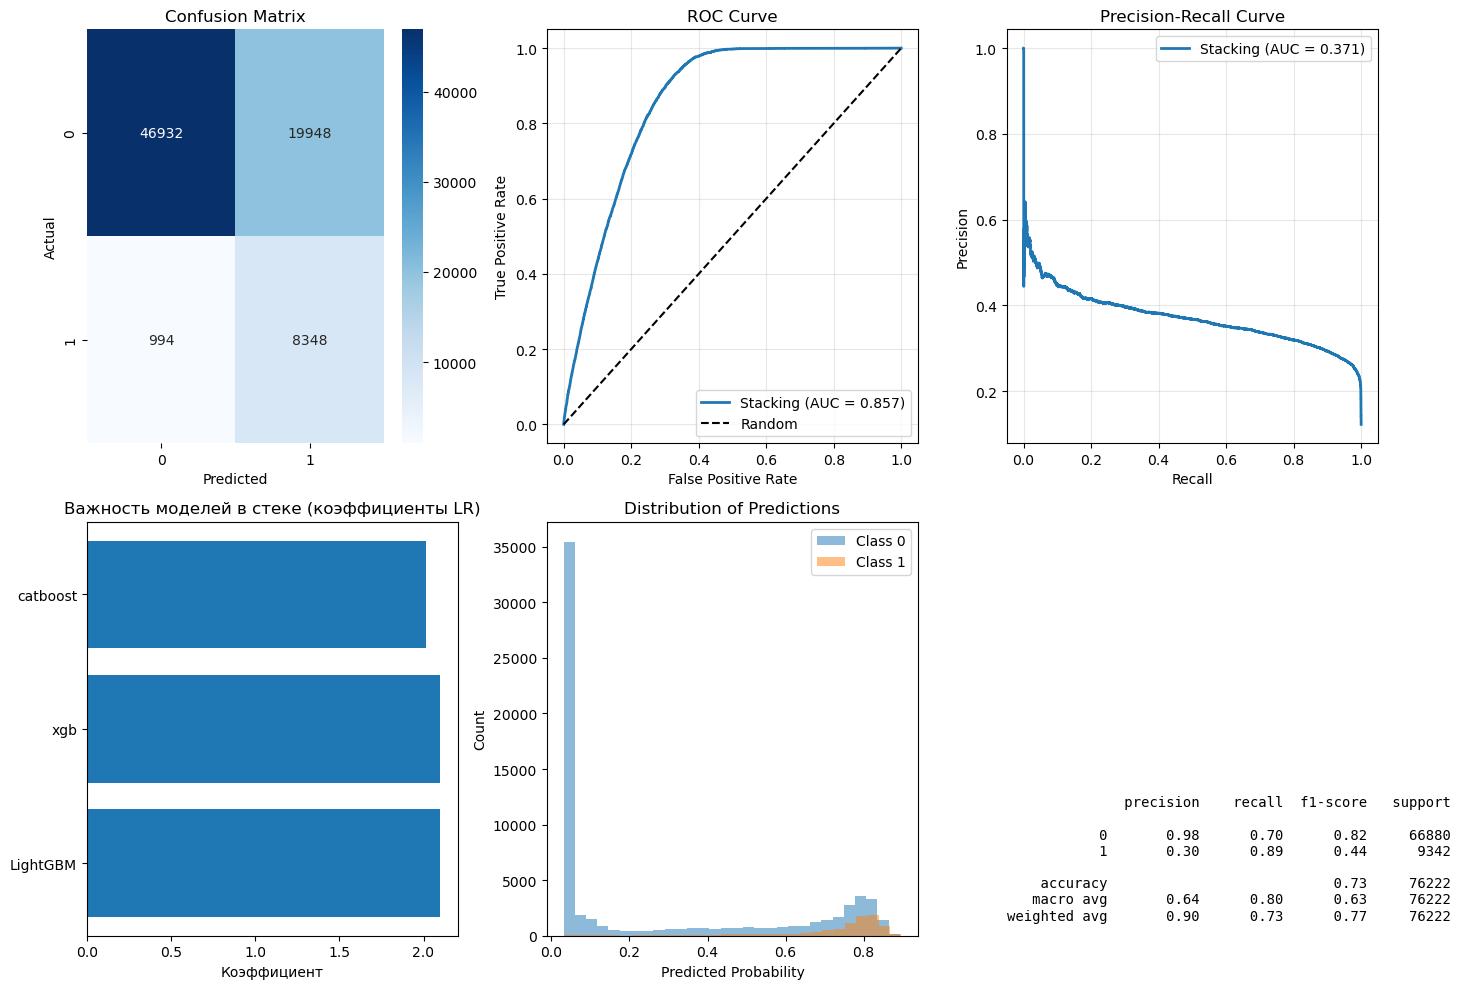


Лучший порог для классификации: 0.70
F1-Score с лучшим порогом: 0.4575


In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

###############################
# Базовые модели 
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'n_estimators': 1000,  
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'scale_pos_weight': 7.15,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'scale_pos_weight': 7.15,
    'random_state': 42,
    'n_jobs': -1,
    'tree_method': 'hist'
}

cat_params = {
    'iterations': 1000,
    'learning_rate': 0.01,
    'depth': 6,
    'l2_leaf_reg': 3,
    'border_count': 128,
    'random_strength': 1,
    'auto_class_weights': 'Balanced',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': 0,
    'task_type': 'CPU'
}


base_models = [
    #('lr', LogisticRegression(C=1.0,max_iter=1000, random_state=42, class_weight='balanced')),  # Простая базовая модель (тянет качество вниз)
    #('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced',max_depth=10)), # Bagging алгоритм. Ограничиваем глубину
    #('knn', KNeighborsClassifier(n_neighbors=50, weights='distance')), # качество низкое (возможно нужен подбор параметров)
    #('svm_linear', SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)), # Очень долго (не дождался)
    #('lda', LinearDiscriminantAnalysis()), # плохое качество на дисбалансе (тянет вниз)
    #('qda', QuadraticDiscriminantAnalysis()), # работает нестабильно: 0.498-0.798 на разных фолдах → явные проблемы
    #('nb', GaussianNB()), # Средненькое качество (тянет качество вниз)
    #('svm_rbf', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42, gamma='scale')), # Очень долго (не дождался)
    #('MLP', MLPClassifier(hidden_layer_sizes=(100, 50),activation='relu',solver='adam',alpha=0.0001,learning_rate='adaptive',max_iter=1000,random_state=42,early_stopping=True)),
    ('LightGBM', lgb.LGBMClassifier(**lgb_params)),
    ('xgb', xgb.XGBClassifier(**xgb_params)),
    ('catboost', CatBoostClassifier(**cat_params))
]



# Разделение данных
X = df_train.drop('Response', axis=1)
y = df_train['Response']
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Предобработка
X_train, encoders = preprocess_features_final(X_train1, y_train, is_train=True)
X_test, encoders = preprocess_features_final(X_test1, y_test, is_train=False, encoders=encoders)

# 1. Подготовка матриц для мета-признаков
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Матрицы для OOF (out-of-fold) предсказаний
train_meta = np.zeros((X_train.shape[0], len(base_models)))
test_meta = np.zeros((X_test.shape[0], len(base_models)))

# 2. Обучение базовых моделей с кросс-валидацией
print("Обучение базовых моделей...")
for model_idx, (name, model) in enumerate(base_models):
    print(f"\nМодель: {name}")
    
    test_fold_preds = []
    
    # Кросс-валидация для получения OOF предсказаний
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                
        # Обучение на фолде
        if name == 'LightGBM':
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                eval_metric='auc',
                #early_stopping_rounds=100,
                #verbose=100
                callbacks=[
                            lgb.early_stopping(stopping_rounds=100),
                            lgb.log_evaluation(period=100)  # Заменяет verbose=100
                        ]
                    )
        elif name == 'xgb': 
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                verbose=False
                )
        else:
            model.fit(X_tr, y_tr)
        
        # Предсказание на валидационном фолде
        val_preds = model.predict_proba(X_val)[:, 1]
        train_meta[val_idx, model_idx] = val_preds
        
        # Предсказание на тестовых данных
        test_preds = model.predict_proba(X_test)[:, 1]
        test_fold_preds.append(test_preds)
        
        # Оценка на валидационном фолде
        fold_auc = roc_auc_score(y_val, val_preds)
        print(f"  Fold {fold_idx + 1}: AUC = {fold_auc:.4f}")
    
    # Усредняем предсказания на тесте по всем фолдам
    test_meta[:, model_idx] = np.mean(test_fold_preds, axis=0)
    
    # Переобучаем модель на всех тренировочных данных
    model.fit(X_train, y_train)
    
    # Оценка всей модели
    full_train_preds = model.predict_proba(X_train)[:, 1]
    full_train_auc = roc_auc_score(y_train, full_train_preds)
    print(f"  Полный тренировочный AUC: {full_train_auc:.4f}")

# 3. Обучение мета-модели (стекинг)
print("\nОбучение мета-модели...")
meta_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # Учитываем дисбаланс
)

#meta_model = xgb.XGBClassifier(
#    n_estimators=100,
#    learning_rate=0.05,
#    max_depth=3,
#    random_state=42,
#    scale_pos_weight=7.15,
#    n_jobs=-1
#)

meta_model.fit(train_meta, y_train)

# 4. Получение предсказаний от мета-модели
# На тренировочных данных (OOF)
train_stacked_preds = meta_model.predict_proba(train_meta)[:, 1]
train_stacked_binary = meta_model.predict(train_meta)

# На тестовых данных
test_stacked_preds = meta_model.predict_proba(test_meta)[:, 1]
test_stacked_binary = meta_model.predict(test_meta)
#test_stacked_binary = (test_stacked_preds > 0.7).astype(int) # 0.7 - лучший порог

# 5. Оценка качества стекинга
print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ СТЕКИНГА")
print("="*50)

# Оценка на тренировочных данных (OOF)
print("\nНа тренировочных данных (OOF):")
train_auc = roc_auc_score(y_train, train_stacked_preds)
train_accuracy = accuracy_score(y_train, train_stacked_binary)
train_precision = precision_score(y_train, train_stacked_binary)
train_recall = recall_score(y_train, train_stacked_binary)
train_f1 = f1_score(y_train, train_stacked_binary)
train_pr_auc = average_precision_score(y_train, train_stacked_preds)

print(f"AUC-ROC: {train_auc:.4f}")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")
print(f"PR-AUC: {train_pr_auc:.4f}")

# Оценка на тестовых данных
print("\nНа тестовых данных:")
test_auc = roc_auc_score(y_test, test_stacked_preds)
test_accuracy = accuracy_score(y_test, test_stacked_binary)
test_precision = precision_score(y_test, test_stacked_binary)
test_recall = recall_score(y_test, test_stacked_binary)
test_f1 = f1_score(y_test, test_stacked_binary)
test_pr_auc = average_precision_score(y_test, test_stacked_preds)

print(f"AUC-ROC: {test_auc:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"PR-AUC: {test_pr_auc:.4f}")

# 6. Визуализация
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Матрица ошибок
cm = confusion_matrix(y_test, test_stacked_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# ROC-кривая
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, test_stacked_preds)
axes[0, 1].plot(fpr, tpr, label=f'Stacking (AUC = {test_auc:.3f})', linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision-Recall кривая
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, test_stacked_preds)
axes[0, 2].plot(recall, precision, label=f'Stacking (AUC = {test_pr_auc:.3f})', linewidth=2)
axes[0, 2].set_xlabel('Recall')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].set_title('Precision-Recall Curve')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Сравнение с базовыми моделями
print("\n" + "="*50)
print("СРАВНЕНИЕ С БАЗОВЫМИ МОДЕЛЯМИ")
print("="*50)

for model_idx, (name, model) in enumerate(base_models):
    # Предсказания базовой модели на тесте
    base_test_preds = model.predict_proba(X_test)[:, 1]
    base_test_binary = (base_test_preds > 0.5).astype(int)
    
    base_auc = roc_auc_score(y_test, base_test_preds)
    base_accuracy = accuracy_score(y_test, base_test_binary)
    base_f1 = f1_score(y_test, base_test_binary)
    
    print(f"\n{name}:")
    print(f"  AUC-ROC: {base_auc:.4f}")
    print(f"  Accuracy: {base_accuracy:.4f}")
    print(f"  F1-Score: {base_f1:.4f}")

# Сохранение результатов
results = {
    'Stacking': {
        'Test_AUC': test_auc,
        'Test_Accuracy': test_accuracy,
        'Test_Precision': test_precision,
        'Test_Recall': test_recall,
        'Test_F1': test_f1,
        'Test_PR_AUC': test_pr_auc
    }
}

# Визуализация важности моделей в стеке
coef = meta_model.coef_[0]
model_names = [name for name, _ in base_models]
axes[1, 0].barh(model_names, coef)
axes[1, 0].set_title('Важность моделей в стеке (коэффициенты LR)')
axes[1, 0].set_xlabel('Коэффициент')

# Распределение предсказаний
axes[1, 1].hist(test_stacked_preds[y_test == 0], alpha=0.5, label='Class 0', bins=30)
axes[1, 1].hist(test_stacked_preds[y_test == 1], alpha=0.5, label='Class 1', bins=30)
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Distribution of Predictions')
axes[1, 1].legend()

# Классификационный отчет в текстовом виде
axes[1, 2].axis('off')
report = classification_report(y_test, test_stacked_binary, output_dict=False)
axes[1, 2].text(0, 0, report, fontsize=10, family='monospace')

plt.tight_layout()
plt.show()

# Вывод лучшего порога 
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.05)
best_threshold = 0.5
best_f1 = 0

for thresh in thresholds:
    binary_preds = (test_stacked_preds > thresh).astype(int)
    current_f1 = f1_score(y_test, binary_preds)
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = thresh

print(f"\nЛучший порог для классификации: {best_threshold:.2f}")
print(f"F1-Score с лучшим порогом: {best_f1:.4f}")

РЕЗУЛЬТАТЫ ОЦЕНКИ Stacking

**LogisticRegression в качестве мета-модели** 
 Базовые модели 1 уровня                                        | ROC-AUC_mean |  PR-AUC |  F1_mean | Precision_mean | Recall_mean 
----------------------------------------------------------------|--------------|---------|----------|----------------|---------
XGBoost,LightGBM,CatBoost,LogisticRegression,RandomForest       | 0.8567       |  0.3666 |  0.4424  | 0.2932         | 0.9002
XGBoost,LightGBM,CatBoost,GaussianNB,LinearDiscriminantAnalysis | 0.8568       |  0.3645 |  0.4430  | 0.2939         | 0.8992
XGBoost,LightGBM,CatBoost                                       | 0.8572       |  0.3706 |  0.4436  | 0.2950         | 0.8936
XGBoost,LightGBM,CatBoost с оптимальным порогом (0.7)           | 0.8572       |  0.3706 |  0.4575  | 0.3313         | 0.7399

**XGBClassifier в качестве мета-модели**
Базовые модели 1 уровня                                         | ROC-AUC_mean |  PR-AUC |  F1_mean | Precision_mean | Recall_mean 
----------------------------------------------------------------|--------------|---------|----------|----------------|---------
XGBoost,LightGBM,CatBoost                                       | 0.8576       |  0.3685 |  0.4372  | 0.2866         | 0.9220
XGBoost,LightGBM,CatBoost с оптимальным порогом (0.65)          | 0.8576       |  0.3685 |  0.4586  | 0.3215         | 0.7994

Выводы: 

- Наилучшие результаты с минимальным набором моделей: 3 модели (XGBoost, LightGBM, CatBoost) дают лучшие результаты. Добавление слабых моделей (LR, RF, NB, LDA) ухудшает качество. Важно качество каждой модели.
- LogisticRegression как мета-модель дает лучший F1 (0.4436) - оптимальный баланс precision/recall, лучший Precision (0.295) - меньше ложных срабатываний, лучшую стабильность (PR-AUC 0.3706).
- XGBoost как мета-модель дает лучший ROC-AUC (0.8576) - лучше разделяет классы, лучший Recall (0.9220) - находит 92% целей, но имеет самый высокий риск ложных срабатываний.
- Оптимизация порога дала значительное улучшение (F1-Score и Precision существенно увеличились).

Пути дальнейшего улучшения:
- Кастомизировать веса моделей в стеке
- Добавить feature engineering на уровне мета-признаков
- Добавить качественных базовых моделей (подобрать лучшие параметры моделей).

# Проектирование архитектуры нейросети (Neural Network Architecture Design)
Попробуем для решения этой задачи использовать нейросеть. Нейронная сеть может находить нелинейные зависимости и дать лучшие результаты, если есть сложные взаимодействия признаков.

Ниже построена нейронная сеть со следующей архитектурой:
- Трехслойная полносвязная нейронная сеть (64-32-16 нейронов)
- Функции активации: tanh (скрытые слои), sigmoid (выходной слой)
- Регуляризация: Dropout (30-20%) + BatchNormalization (для ускорение сходимости и стабилизации)
- Оптимизатор: Adam 
- Функция потерь (Loss функция): Binary Crossentropy

Особенности:
- Использование class_weight='balanced' для учета соотношения классов (т.к., присутствует дисбаланс классов)
- Ранняя остановка (Early Stopping): остановка при ухудшении val_loss > 10 эпох
- Преобразование в float32 для совместимости с TensorFlow
- Стратифицированное разделение train/test (80/20)

Количество признаков: 18
Epoch 1/50
7623/7623 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.6613 - auc: 0.8216 - loss: 0.4588 - val_accuracy: 0.6751 - val_auc: 0.8451 - val_loss: 0.4709 - learning_rate: 0.0010
Epoch 2/50
7623/7623 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6709 - auc: 0.8342 - loss: 0.4448 - val_accuracy: 0.6537 - val_auc: 0.8461 - val_loss: 0.5053 - learning_rate: 0.0010
Epoch 3/50
7623/7623 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6692 - auc: 0.8361 - loss: 0.4430 - val_accuracy: 0.6978 - val_auc: 0.8465 - val_loss: 0.4531 - learning_rate: 0.0010
Epoch 4/50
7623/7623 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.6700 - auc: 0.8365 - loss: 0.4423 - val_accuracy: 0.6795 - val_auc: 0.8468 - val_loss: 0.5049 - learning_rate: 0.0010
Epoch 5/50
7623/7623 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6712 - auc: 0.8376 - loss: 0.4414 - val_accuracy: 0.6674 - val_auc: 0.8471 - val_loss: 0.4933 - learning_rate: 0.0010
Epoch 6/50
7623/7623 ━━━━━━━━━━━━━━━━━━━

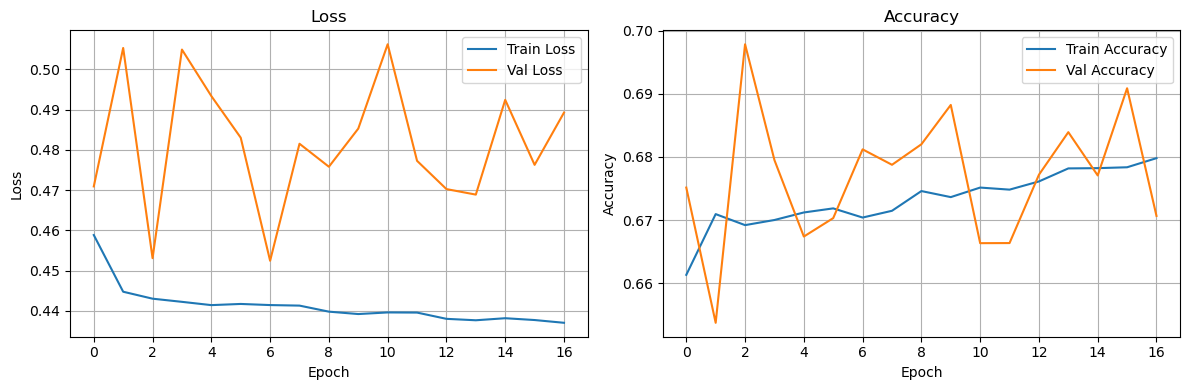

In [58]:
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Загрузка данных
X = df_train.drop('Response', axis=1)
y = df_train['Response']

# Вычисляем веса классов
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y),
    y=y
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Предобработка
X_train_processed, encoders = preprocess_features_final(X_train, y_train, is_train=True)
X_test_processed, _ = preprocess_features_final(X_test, y_test, is_train=False, encoders=encoders)

# Убедимся, что данные имеют правильный тип
X_train_processed = np.array(X_train_processed).astype('float32')
X_test_processed = np.array(X_test_processed).astype('float32')
y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')

# Определяем количество признаков
n_features = X_train_processed.shape[1]
print(f"Количество признаков: {n_features}")

# Создание модели нейронной сети
#model = Sequential()

# Первый скрытый слой
#model.add(Dense(64, input_dim=n_features, activation='tanh'))
#model.add(BatchNormalization())
#model.add(Dropout(0.3))

# Второй скрытый слой
#model.add(Dense(32, activation='tanh'))
#model.add(BatchNormalization())
#model.add(Dropout(0.3))

# Третий скрытый слой
#model.add(Dense(16, activation='tanh'))
#model.add(Dropout(0.2))

# Выходной слой (бинарная классификация)
#model.add(Dense(1, activation='sigmoid'))

# Улучшенная архитектура
model = Sequential([
    Dense(128, input_dim=n_features, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    
    Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
#model.compile(
#    optimizer='adam',
#    loss='binary_crossentropy',
#    metrics=['accuracy']
#)

# Callbacks для улучшения обучения
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Обучение модели
history = model.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# Предсказания на тестовой выборке
y_test_proba = model.predict(X_test_processed).flatten()
y_test_pred = (y_test_proba >= 0.5).astype(int)

# Метрики
print("\n" + "="*50)
print("Метрики на тестовой выборке:")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_test_proba):.4f}")

# Дополнительно: предсказания вероятностей для тренировочной выборки
y_train_proba = model.predict(X_train_processed).flatten()
print(f"\nROC-AUC на тренировочной выборке: {roc_auc_score(y_train, y_train_proba):.4f}")

# Визуализация истории обучения
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# График потерь
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# График точности
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

РЕЗУЛЬТАТЫ ОЦЕНКИ нейронной сети

Архитектура нейронной сети   | ROC-AUC_mean |  PR-AUC |  F1_mean | Precision_mean | Recall_mean |
-----------------------------|--------------|---------|----------|----------------|-------------|
(64 tanh -32 tanh -16 tanh)  | 0.8469       |  0.3349 |  0.4284  | 0.2797         | 0.9143      |
(128 relu -64 relu -32 relu) | 0.8469       |  0.3384 |  0.4203  | 0.2703         | 0.9443      |

Выводы: 
Обе архитектуры нейросети дали хуже результаты, чем ранее рассмотренные бустинговые модели. У нейросети более низкий F1 (<0.43), очень низкий precision (<0.28) - много ложных срабатываний.
Нейросеть переобучается на minority class (слишком высокий recall), не справляется с дисбалансом 

Для улучшения нейросети можно попробовать добавить техники для дисбаланса (например, SMOTE). Также, можно использовать ансамбль из нейросети и моделей, основанных на деревьях.

# Обучение финальной модели (Final Model Evaluation on Test Set)

**Выбор финальной модели**
Лучшие модели в исследовании                                    | ROC-AUC_mean |  PR-AUC |  F1_mean | Precision_mean | Recall_mean 
----------------------------------------------------------------|--------------|---------|----------|----------------|---------
Модель LightGBM с оптимальным порогом (0.669)                   | 0.8575       |  0.3701 |  0.4588  | 0.3282         | 0.7616
Модель LightGBM с калибровкой и оптимальным порогом (0.233)     | 0.8576       |  0.3703 |  0.4591  | 0.3295         | 0.7568
Модель LightGBM со SMOTE с калибровкой и оптим. порогом (0.215) | 0.8571       |  0.3709 |  0.4568  | 0.3215         | 0.7887
Блендинг (LGBM,CatBoost,LogisticRegression) с весами моделей    | 0.8559       |  0.3617 |  0.4311  | 0.2802         | 0.9343
Стекинг XGBoost,LightGBM,CatBoost с оптимальным порогом (0.65)  | 0.8576       |  0.3685 |  0.4586  | 0.3215         | 0.7994
Нейронная сеть (64 tanh -32 tanh -16 tanh)                      | 0.8469       |  0.3349 |  0.4284  | 0.2797         | 0.9143      

Ключевые наблюдения:
- Все модели имеют практически одинаковый ROC-AUC (~0.857) — качество ранжирования одинаковое
- PR-AUC очень низкий (~0.37) — подтверждает сильную несбалансированность
- Высокие Recall (~0.76-0.93) — модели хорошо находят положительные случаи
- Низкие Precision (~0.28-0.33) — много ложных срабатываний

Выбор для бизнеса определяется из следующих соображений. Высокий Precision → меньше ложных срабатываний, выше ROI (коэфициент возврата инвестиций); высокий Recall → находим больше реальных покупателей, но дороже кампания.

Финальный выбор: **LightGBM с калибровкой и порогом 0.233**

**Обоснование:**
1. **Наивысший F1-Score (0.4591)** среди всех моделей
2. **Лучший Precision (0.3295)** при сохранении Recall > 0.75
3. **Хорошая интерпретируемость** LightGBM (feature importance)
4. **Калиброванные вероятности** для более реалистичных прогнозов

**Бизнес-интерпретация:**
- При пороге 0.233 модель будет предсказывать "заинтересован" при вероятности > 23.3%
- Это обеспечивает 33% точность предсказаний (каждый третий контакт успешен)
- При этом находится 76% всех реально заинтересованных клиентов 
- ROI маркетинговой кампании будет оптимальным
   

In [8]:
# Оптимизированные параметры лучшей модель (LGBMClassifier) 
best_params = {
    'objective': 'binary',
    'boosting_type': 'dart',  # лучше для несбалансированных
    'metric': 'auc',
    'n_estimators': 320,
    'learning_rate': 0.1,
    'num_leaves': 63,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'scale_pos_weight': 7.15,  # для дисбаланса 87.7%/12.3%
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}


## Модель без калибровки (для сравнения)

In [ ]:
OPTIMAL_THRESHOLD = 0.669

def find_optimal_threshold_f1(y_true, y_pred_proba):
    """Находит оптимальный порог для максимизации F1"""
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1 = 0
    best_threshold = 0.5
    
    for thresh in thresholds:
        y_pred = (y_pred_proba > thresh).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh
    
    return best_threshold


# Проверяем, что оптимальный порог OPTIMAL_THRESHOLD работает хорошо на CV
# Загрузка данных
X_train_full = df_train.drop('Response', axis=1)
y_train_full = df_train['Response']
X_test = df_test.drop(['id'],axis=1)

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {
        'fold': [],
        'auc': [],
        'f1': [],
        'precision': [],
        'recall': [],
        'threshold': []
    }

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    X_tr, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_tr, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
    
    # Предобработка
    X_tr_processed, encoders = preprocess_features_final(X_tr, y_tr, is_train=True)
    X_val_processed, _ = preprocess_features_final(X_val, is_train=False, encoders=encoders)

    model = lgb.LGBMClassifier(**best_params)
    model.fit(X_tr_processed, y_tr)
 
    val_preds_proba = model.predict_proba(X_val_processed)[:, 1]
    
    # Используем наш порог
    val_preds_binary = (val_preds_proba > OPTIMAL_THRESHOLD).astype(int)       
        
    # Также находим оптимальный порог для этого фолда
    fold_optimal_threshold = find_optimal_threshold_f1(y_val, val_preds_proba)
        
    # Запоминаем результаты по фолдам
    cv_results['fold'].append(fold + 1)
    cv_results['auc'].append(roc_auc_score(y_val, val_preds_proba))
    cv_results['f1'].append(f1_score(y_val, val_preds_binary))
    cv_results['precision'].append(precision_score(y_val, val_preds_binary))
    cv_results['recall'].append(recall_score(y_val, val_preds_binary))
    cv_results['threshold'].append(fold_optimal_threshold) 

print("=" * 60)
print(f"Проверка порога {OPTIMAL_THRESHOLD}")
print("=" * 60)
#print(f"F1 на кросс-валидации с порогом {OPTIMAL_THRESHOLD}: {np.mean(cv_results['f1']):.4f} (±{np.std(cv_results['f1']):.4f})")
print(f"Средний по фолдам оптимальный порог : {np.mean(cv_results['threshold']):.4f}")
print(f"Разница значений порогов {OPTIMAL_THRESHOLD} и среднего по фолдам порога: {OPTIMAL_THRESHOLD - np.mean(cv_results['threshold']):.4f}")

# Если разница небольшая (<0.05), используем наш порог
if abs(OPTIMAL_THRESHOLD - np.mean(cv_results['threshold'])) < 0.05:
    print(f"Порог {OPTIMAL_THRESHOLD} соответствует оптимальному порогу на кросс-валидации")
    final_threshold = OPTIMAL_THRESHOLD
else:
    print(f"Порог {OPTIMAL_THRESHOLD} не оптимален!")
    final_threshold = np.mean(cv_results['threshold'])

# Параметры модели на кроссвалидации
print("=" * 60)
print(f"Финальная модель с порогом {OPTIMAL_THRESHOLD}")
print("=" * 60)    
print("\n Параметры качества модели на кросс-валидации с порогом threshold =", OPTIMAL_THRESHOLD)
print("-" * 50)

common_keys = cv_results.keys() & ['auc', 'f1', 'precision', 'recall']
for key in common_keys:
    print(f"{key.upper():10} : {np.mean(cv_results[key]):.4f} (±{np.std(cv_results[key]):.4f})")

# Обучение на тестовых данных и создание submission
X_tr_full_proc, encoders = preprocess_features_final(X_train_full, y_train_full, is_train=True)
X_test_proc, _ = preprocess_features_final(X_test, is_train=False, encoders=encoders)

final_model = lgb.LGBMClassifier(**best_params)
# Обучаем модель на всех тренировочных данных для предсказания на тесте
final_model.fit(X_tr_full_proc, y_train_full)
 
test_proba = final_model.predict_proba(X_test_proc)[:, 1]
test_pred_binary = (test_proba > OPTIMAL_THRESHOLD).astype(int)

submission = pd.DataFrame({
    'id': df_test['id'],
    'Response': test_proba
})
#submission.to_csv('submission.csv', index=False)
submission.head()



Проверка порога 0.669
F1 на кросс-валидации с порогом 0.669: 0.4577 (±0.0029)
Средний по фолдам оптимальный порог : 0.6740
Разница значений порогов 0.669 и среднего по фолдам порога: -0.0050
Порог 0.669 соответствует оптимальному порогу на кросс-валидации
Финальная модель с порогом 0.669

 Параметры качества модели на кросс-валидации с порогом threshold = 0.669
--------------------------------------------------
Ключ: PRECISION  : 0.3276 (±0.0022)
Ключ: F1         : 0.4577 (±0.0029)
Ключ: AUC        : 0.8574 (±0.0012)
Ключ: RECALL     : 0.7596 (±0.0050)


,id,Response
0,381110,0.003665
1,381111,0.750603
2,381112,0.740881
3,381113,0.050705
4,381114,0.003357


## Финальная модель. Формирование файла submission.csv с ответами по тестовой выборке (вероятности класса 1)

Нужно заметить, что модели LightGBM с калибровкой и без калибровки будут иметь идентичные результаты.<br> 
При этом, пороги будут разными (0.669 и 0.233), что объясняются эффектом калибровки, которая меняет 
шкалу вероятностей, но сохраняет ранжирование объектов. После калибровки вероятности становятся более реалистичными.<br>

Калибровка не изменит:
- ROC-AUC
- порядок следования ответов по значению (ранжирование)
- бинарные предсказания
- F1-Score (при оптимальном пороге)

Калибровка изменит:
- Калибровочная кривая станет более реалистичнее
- Brier Score (средний квадрат отклонений предсказанных вероятностей от фактических) улучшается
- Оптимальный порог и распределение вероятностей

**Преимущества калиброванной модели для бизнеса:**
1. **Бизнес-интерпретируемость**: Вероятность 23.3% реалистично отражает
   фактическую частоту положительных ответов (12.3%) с учетом 
   консервативной стратегии

2. **Гибкость принятия решений**: Порог 0.233 позволяет легко адаптировать модель под разные бизнес-сценарии:
   - Агрессивная кампания: снизить порог до 0.15
   - Консервативная: повысить до 0.35
   - При этом вероятности остаются калиброванными

3. **Сравнимость во времени**: Калиброванные вероятности позволяют мониторить изменения в поведении клиентов независимо от модели

4. **Доверие бизнеса**: Реалистичные вероятности повышают доверие к рекомендациям модели

In [ ]:
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV

def find_optimal_threshold_f1(y_true, y_pred_proba):
    """Находит оптимальный порог для максимизации F1"""
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1 = 0
    best_threshold = 0.5
    
    for thresh in thresholds:
        y_pred = (y_pred_proba > thresh).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh
    
    return best_threshold

def validate_calibrated_threshold(base_model, X, y, candidate_threshold=0.233,calibration_size=0.2, n_splits=5):
    """Проверка порога специально для калиброванной модели"""
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    metrics = {
        'auc': [],
        'f1': [],
        'precision': [],
        'recall': [],
        'optimal_thresholds': []
    }
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        # Разделение на train/calibration/validation
        X_tr_full, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr_full, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Делим на обучение и калибровку
        #from sklearn.model_selection import train_test_split
        X_train, X_cal, y_train, y_cal = train_test_split(X_tr_full, y_tr_full,test_size=calibration_size,random_state=42,stratify=y_tr_full)
        
        # Предобработка
        X_train_processed, encoders = preprocess_features_final(X_train, y_train, is_train=True)
        X_cal_processed, _ = preprocess_features_final(X_cal, is_train=False, encoders=encoders)
        X_val_processed, _ = preprocess_features_final(X_val, is_train=False, encoders=encoders)
        
        # Обучаем и калибруем
        model = clone(base_model)
        model.fit(X_train_processed, y_train)
        
        calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
        calibrated_model.fit(X_cal_processed, y_cal)
        
        # Прогнозы калиброванной модели
        val_proba_cal = calibrated_model.predict_proba(X_val_processed)[:, 1]
        
        # Находим оптимальный порог ДЛЯ КАЛИБРОВАННОЙ модели
        optimal_threshold_cal = find_optimal_threshold_f1(y_val, val_proba_cal)
        metrics['optimal_thresholds'].append(optimal_threshold_cal)
        
        # Проверяем кандидатский порог OPTIMAL_THRESHOLD_CALIBR
        y_pred_candidate = (val_proba_cal > candidate_threshold).astype(int)
        metrics['auc'].append(roc_auc_score(y_val, val_proba_cal))
        metrics['f1'].append(f1_score(y_val, y_pred_candidate))
        metrics['precision'].append(precision_score(y_val, y_pred_candidate, zero_division=0))
        metrics['recall'].append(recall_score(y_val, y_pred_candidate, zero_division=0))
    
    return metrics

OPTIMAL_THRESHOLD_CALIBR = 0.233

X_train_full = df_train.drop('Response', axis=1)
y_train_full = df_train['Response']
X_test = df_test.drop(['id'],axis=1)

# Проверка для КАЛИБРОВАННОЙ модели
calibrated_metrics = validate_calibrated_threshold(
    base_model=lgb.LGBMClassifier(**best_params),
    X=X_train_full,
    y=y_train_full,
    candidate_threshold=OPTIMAL_THRESHOLD_CALIBR  
)

print("Результаты для КАЛИБРОВАННОЙ модели:")
print("=" * 60)
print(f"Проверка порога {OPTIMAL_THRESHOLD_CALIBR}")
print("=" * 60)
print(f"Средний по фолдам оптимальный порог : {np.mean(calibrated_metrics['optimal_thresholds']):.4f}")
print(f"Разница значений порогов {OPTIMAL_THRESHOLD_CALIBR} и среднего по фолдам порога: {OPTIMAL_THRESHOLD_CALIBR - np.mean(calibrated_metrics['optimal_thresholds']):.4f}")

# Если разница небольшая (<0.05), используем наш порог
if abs(OPTIMAL_THRESHOLD_CALIBR - np.mean(calibrated_metrics['optimal_thresholds'])) < 0.05:
    print(f"Порог {OPTIMAL_THRESHOLD_CALIBR} соответствует оптимальному порогу на кросс-валидации")
    final_threshold = OPTIMAL_THRESHOLD_CALIBR
else:
    print(f"Порог {OPTIMAL_THRESHOLD_CALIBR} не оптимален!")
    final_threshold = np.mean(calibrated_metrics['optimal_thresholds'])

# Параметры модели на кроссвалидации
print("=" * 60)
print(f"Финальная КАЛИБРОВАННАЯ модель с порогом {OPTIMAL_THRESHOLD_CALIBR}")
print("=" * 60)    
print("\n Параметры качества модели на кросс-валидации с порогом threshold =", OPTIMAL_THRESHOLD_CALIBR)
print("-" * 50)

common_keys = calibrated_metrics.keys() & ['auc', 'f1', 'precision', 'recall']
for key in common_keys:
    print(f"{key.upper():10} : {np.mean(calibrated_metrics[key]):.4f} (±{np.std(calibrated_metrics[key]):.4f})")


# Предобработка
X_tr_full_proc, encoders = preprocess_features_final(X_train_full, y_train_full, is_train=True)
X_test_proc, _ = preprocess_features_final(X_test, is_train=False, encoders=encoders)

# Калибровка с кросс-валидацией
final_cal_model = CalibratedClassifierCV(
    lgb.LGBMClassifier(**best_params),
    method='isotonic',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
)

# Обучаем и калибруем на всей тренировочной выборке
final_cal_model.fit(X_tr_full_proc, y_train_full)

# Получаем калиброванные вероятности
y_proba_cal = final_cal_model.predict_proba(X_test_proc)[:, 1]
#test_pred_binary = (y_proba_cal > OPTIMAL_THRESHOLD_CALIBR).astype(int)

submission = pd.DataFrame({
    'id': df_test['id'],
    'Response': y_proba_cal
})
submission.to_csv('submission.csv', index=False)
#submission.head()

Результаты для КАЛИБРОВАННОЙ модели:
Проверка порога 0.233
Средний по фолдам оптимальный порог : 0.2300
Разница значений порогов 0.233 и среднего по фолдам порога: 0.0030
Порог 0.233 соответствует оптимальному порогу на кросс-валидации
Финальная КАЛИБРОВАННАЯ модель с порогом 0.233

 Параметры качества модели на кросс-валидации с порогом threshold = 0.233
--------------------------------------------------
RECALL     : 0.7505 (±0.0203)
F1         : 0.4570 (±0.0032)
PRECISION  : 0.3287 (±0.0054)
AUC        : 0.8568 (±0.0014)


Важность признаков

Тип модели: <class 'sklearn.calibration.CalibratedClassifierCV'>
calibrated_classifiers_ тип: <class 'list'>
Список из 5 калибраторов
Тип калибратора: <class 'sklearn.calibration._CalibratedClassifier'>
Найдена базовая модель через атрибут 'estimator': <class 'lightgbm.sklearn.LGBMClassifier'>

Анализ базовой модели <class 'lightgbm.sklearn.LGBMClassifier'>:
Найдены feature_importances_


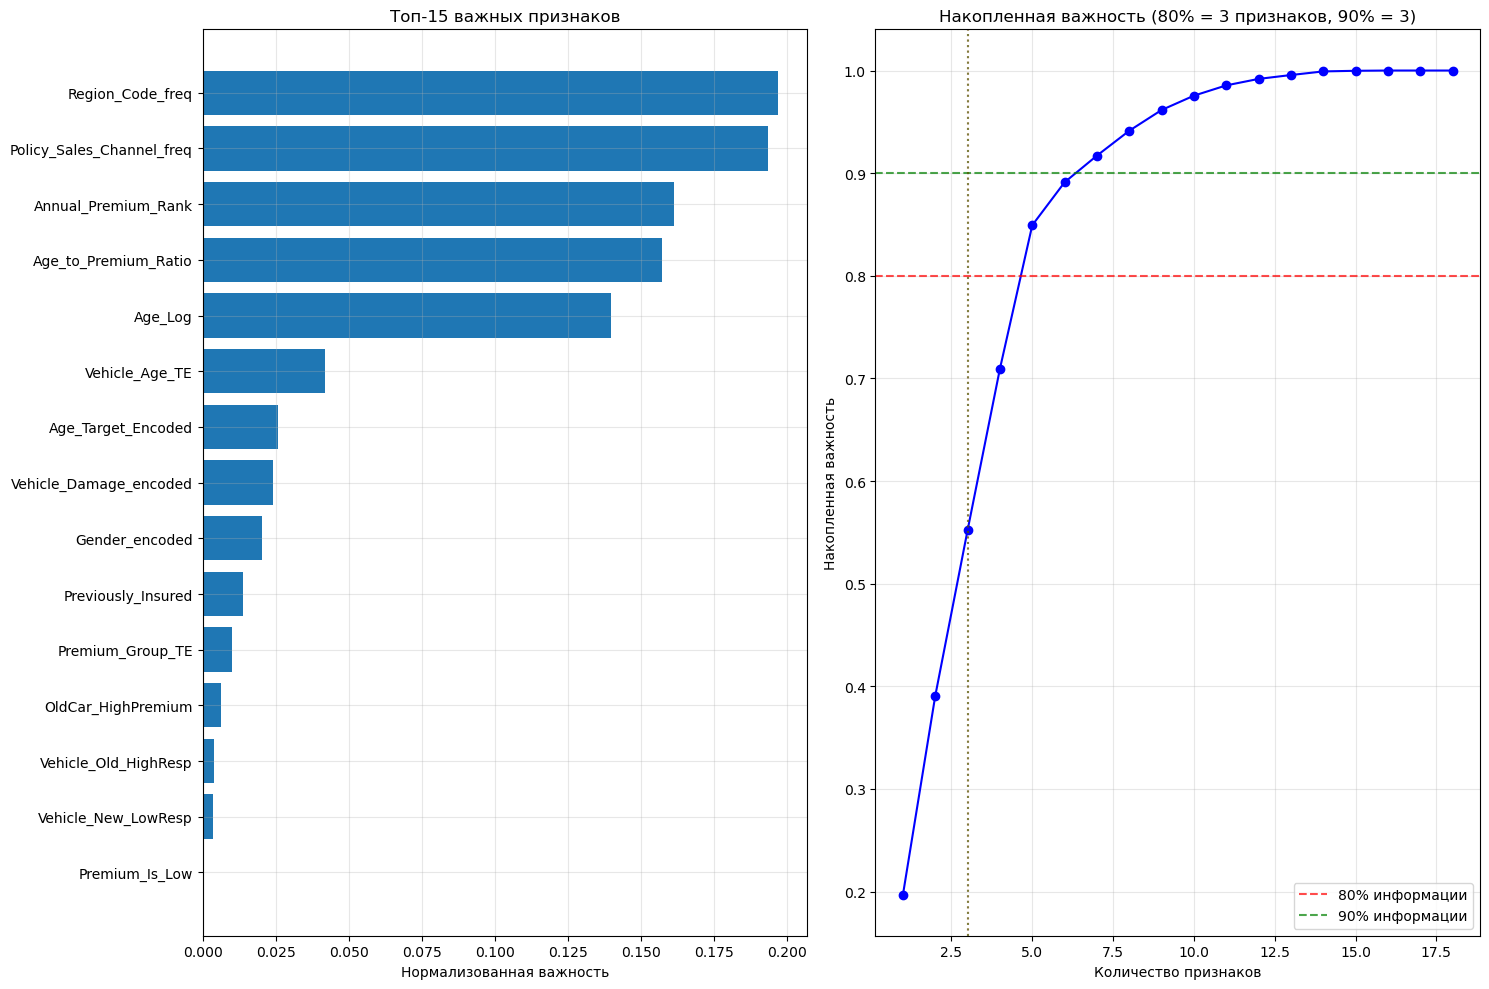


Статистика важности признаков:
Всего признаков: 18

Топ-10 самых важных признаков:
 3. Region_Code_freq                    : 0.1972 (19.7%)
 2. Policy_Sales_Channel_freq           : 0.1938 (39.1%)
13. Annual_Premium_Rank                 : 0.1614 (55.2%)
12. Age_to_Premium_Ratio                : 0.1572 (71.0%)
11. Age_Log                             : 0.1398 (84.9%)
 4. Vehicle_Age_TE                      : 0.0418 (89.1%)
10. Age_Target_Encoded                  : 0.0260 (91.7%)
 8. Vehicle_Damage_encoded              : 0.0242 (94.1%)
 7. Gender_encoded                      : 0.0202 (96.2%)
 1. Previously_Insured                  : 0.0140 (97.6%)


In [20]:
def plot_calibrated_model_importance(calibrated_model, feature_names):
    
    print(f"Тип модели: {type(calibrated_model)}")
    
    try:
        # Получаем calibrated_classifiers_
        if hasattr(calibrated_model, 'calibrated_classifiers_'):
            calibrators = calibrated_model.calibrated_classifiers_
            print(f"calibrated_classifiers_ тип: {type(calibrators)}")
            
            if isinstance(calibrators, list):
                print(f"Список из {len(calibrators)} калибраторов")
                calibrator = calibrators[0]
            else:
                calibrator = calibrators
            
            print(f"Тип калибратора: {type(calibrator)}")
            
            # В _CalibratedClassifier базовая модель хранится в base_estimator
            # но может быть под другим именем
            possible_attrs = ['base_estimator', 'estimator', '_base_estimator', 'clf']
            
            base_model = None
            for attr in possible_attrs:
                if hasattr(calibrator, attr):
                    base_model = getattr(calibrator, attr)
                    print(f"Найдена базовая модель через атрибут '{attr}': {type(base_model)}")
                    break
            
            if base_model is None:
                print("Не удалось найти базовую модель в калибраторе")
                print("Доступные атрибуты калибратора:")
                for attr in dir(calibrator):
                    if not attr.startswith('_'):
                        try:
                            attr_value = getattr(calibrator, attr)
                            if not callable(attr_value):
                                print(f"  {attr}: {type(attr_value)}")
                        except:
                            pass
                return None, None
        else:
            print("У модели нет calibrated_classifiers_")
            return None, None
        
    except Exception as e:
        print(f"Ошибка при получении базовой модели: {e}")
        return None, None
    
    # Теперь получаем важность из базовой модели
    if base_model is not None:
        print(f"\nАнализ базовой модели {type(base_model)}:")
        
        # Проверяем доступные атрибуты базовой модели
        if hasattr(base_model, 'feature_importances_'):
            importance = base_model.feature_importances_
            print("Найдены feature_importances_")
            
        elif hasattr(base_model, 'coef_'):
            # Для линейных моделей
            coef = base_model.coef_
            if len(coef.shape) > 1:
                coef = coef[0]  # берем для класса 1
            importance = np.abs(coef)
            print("Найдены коэффициенты (линейная модель)")
            
        elif hasattr(base_model, 'booster_'):
            # Для LightGBM через booster
            try:
                importance = base_model.booster_.feature_importance(importance_type='split')
                print("Найдена важность через booster (LightGBM)")
            except:
                print("Не удалось получить важность через booster")
                return None, base_model
        else:
            print("Базовая модель не поддерживает стандартные методы важности")
            print("Доступные атрибуты базовой модели:")
            for attr in dir(base_model):
                if not attr.startswith('_'):
                    try:
                        attr_value = getattr(base_model, attr)
                        if not callable(attr_value):
                            print(f"  {attr}: {type(attr_value)}")
                    except:
                        pass
            return None, base_model
        
        # Создаем DataFrame с важностью
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        # Нормализуем
        if importance_df['importance'].sum() > 0:
            importance_df['importance_norm'] = importance_df['importance'] / importance_df['importance'].sum()
        else:
            importance_df['importance_norm'] = 0
        
        # Визуализация
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))
        
        # Топ-15 признаков
        top_n = min(15, len(importance_df))
        axes[0].barh(range(top_n), importance_df['importance_norm'].head(top_n))
        axes[0].set_yticks(range(top_n))
        axes[0].set_yticklabels(importance_df['feature'].head(top_n))
        axes[0].invert_yaxis()
        axes[0].set_xlabel('Нормализованная важность')
        axes[0].set_title(f'Топ-{top_n} важных признаков')
        axes[0].grid(True, alpha=0.3)
        
        # Накопленная важность
        importance_df['cumulative'] = importance_df['importance_norm'].cumsum()
        axes[1].plot(range(1, len(importance_df)+1), importance_df['cumulative'], 'b-', marker='o')
        axes[1].axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80% информации')
        axes[1].axhline(y=0.9, color='g', linestyle='--', alpha=0.7, label='90% информации')
        
        # Находим, сколько признаков нужно для 80% и 90%
        n_80 = (importance_df['cumulative'] >= 0.8).idxmin() + 1
        n_90 = (importance_df['cumulative'] >= 0.9).idxmin() + 1
        
        axes[1].axvline(x=n_80, color='r', linestyle=':', alpha=0.5)
        axes[1].axvline(x=n_90, color='g', linestyle=':', alpha=0.5)
        
        axes[1].set_xlabel('Количество признаков')
        axes[1].set_ylabel('Накопленная важность')
        axes[1].set_title(f'Накопленная важность (80% = {n_80} признаков, 90% = {n_90})')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Выводим статистику
        print(f"\nСтатистика важности признаков:")
        print(f"Всего признаков: {len(importance_df)}")
        #print(f"Признаков с нулевой важностью: {(importance_df['importance'] == 0).sum()}")
        #print(f"Признаков для 80% информации: {n_80}")
        #print(f"Признаков для 90% информации: {n_90}")
        
        print(f"\nТоп-10 самых важных признаков:")
        for i, row in importance_df.head(10).iterrows():
            print(f"{i+1:2d}. {row['feature']:<35} : {row['importance_norm']:.4f} ({row['cumulative']:.1%})")
        
        return importance_df, base_model
    
    return None, None

feature_names = X_tr_full_proc.columns.tolist()
calibrated_importance = plot_calibrated_model_importance(final_cal_model, feature_names)

# Бизнес-аналитика и рекомендации (Business Insights & Recommendations)

**Ограничения модели и риски:**

1. **False Positives (33%)**: Каждый третий контакт будет с незаинтересованным клиентом<br>
   - A/B тестирование сообщений для снижения раздражения

2. **False Negatives (24%)**: 24% реально заинтересованных клиентов не будут контактированы<br>
   - Регулярная переоценка порога (ежеквартально)

3. **Сезонность**: Модель обучена на данных одного периода
   - Мониторинг дрейфа данных и переобучение раз в 6 месяцев
-------------------------

**Важность признаков:**
1. **Region_Code_freq** (19.7%) - географические паттерны
2. **Policy_Sales_Channel_freq** (19.4%) - эффективность каналов продаж  
3. **Annual_Premium_Rank** (16.1%) - ценовая стратегия
4. **Age_to_Premium_Ratio + Age_Log** (29.7%) - демографическо-ценовой профиль

## I. Географические паттерны (самый важный фактор - 19.7%)
**Инсайт**: Регион проживания клиента - самый сильный предиктор интереса к автострахованию

**Детали (Предположения для дальнейшего рассмотрения)**:
- Некоторые регионы имеют в разы более высокую конверсию
- Клиенты из **городских регионов с высокой плотностью движения** чаще страхуются
- **Сельские регионы** показывают низкий интерес (низкий риск аварий?)

**Рекомендации**:
1. **Гео-таргетинг**: Сфокусировать кампании на топ-20% регионов по конверсии
2. **Региональные продукты**: Разработать страховые пакеты под специфику регионов
3. **Локализованные сообщения**: Адаптировать коммуникацию под региональные особенности

## II. Каналы продаж (19.4% важности)<br>
**Инсайт**: Эффективность канала продаж почти так же важна, как регион

**Детали**:
- **Канал 163.0**: 30.4% конверсия, 2893 клиента - самый важный канал
- **Канал 155.0**: 32.0% конверсия, 1234 клиента - высокоэффективный
- **Канал 36.0**: 32.7% конверсия, 52 клиента - перспективный канал роста
- **Каналы 123.0/43.0**: 100% конверсия, но по 1 клиенту - статистический шум

**Рекомендации**:
1. **Оптимизация каналов**: 
- Увеличить долю каналов 155.0 и 36.0
- Возможна специализация: разные каналы для разных сегментов
- Игнорировать каналы с <10 клиентами для стратегических решений

Статистика по каналам продаж:
         count  conversion_rate       std
channel                                  
123.0        1         1.000000       NaN
43.0         1         1.000000       NaN
27.0         3         0.333333  0.577350
28.0         3         0.333333  0.577350
36.0        52         0.326923  0.473665
155.0     1234         0.320097  0.466703
163.0     2893         0.304183  0.460140
3.0        523         0.304015  0.460430
121.0       64         0.296875  0.460493
101.0        7         0.285714  0.487950


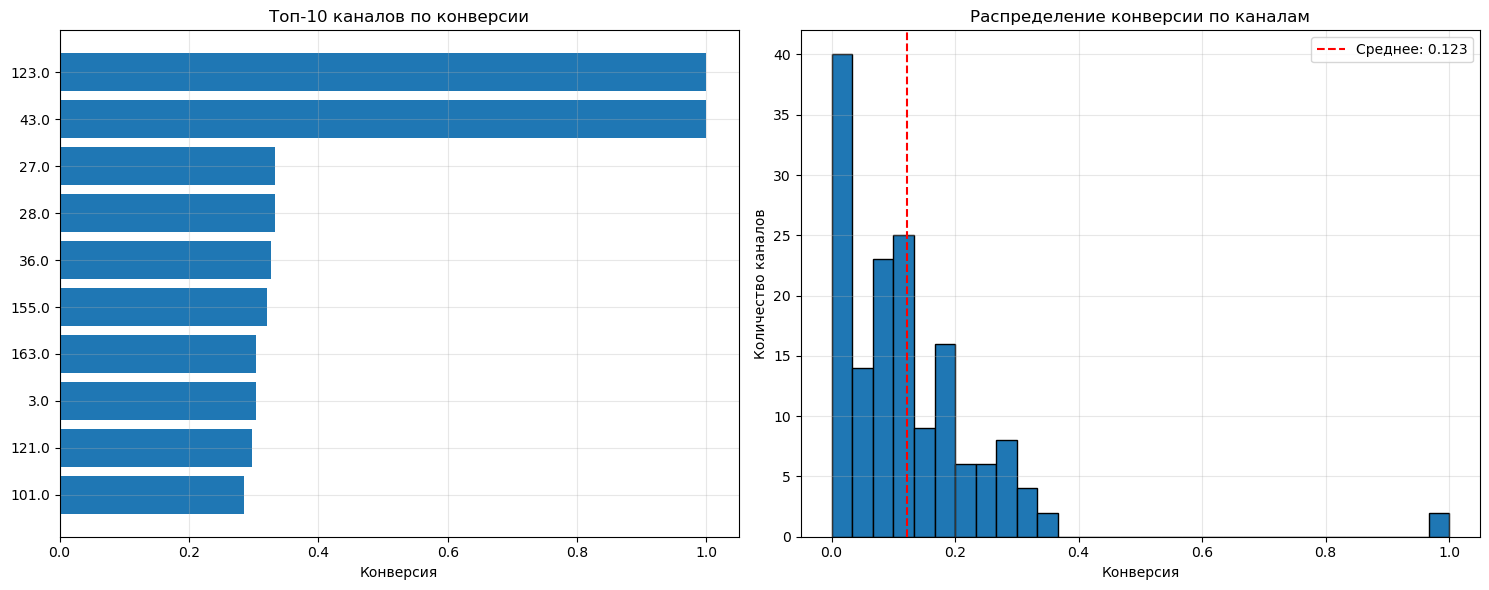

In [ ]:
def analyze_sales_channels(X_processed, y, channel_col='Policy_Sales_Channel_freq'):
    """
    Анализ эффективности каналов продаж
    """
    # Если у вас есть исходные данные с каналами
    if 'Policy_Sales_Channel' in X_processed.columns:
        # Группируем по каналам
        channel_stats = pd.DataFrame({
            'channel': X_processed['Policy_Sales_Channel'],
            'response': y
        }).groupby('channel').agg({'response': ['count', 'mean', 'std']})
        
        channel_stats.columns = ['count', 'conversion_rate', 'std']
        channel_stats = channel_stats.sort_values('conversion_rate', ascending=False)
        
        print("Статистика по каналам продаж:")
        print(channel_stats.head(10).to_string())
        
        # Визуализация
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Топ-10 каналов по конверсии
        top_channels = channel_stats.head(10)
        axes[0].barh(range(len(top_channels)), top_channels['conversion_rate'])
        axes[0].set_yticks(range(len(top_channels)))
        axes[0].set_yticklabels(top_channels.index)
        axes[0].invert_yaxis()
        axes[0].set_xlabel('Конверсия')
        axes[0].set_title('Топ-10 каналов по конверсии')
        axes[0].grid(True, alpha=0.3)
        
        # Распределение конверсий
        axes[1].hist(channel_stats['conversion_rate'], bins=30, edgecolor='black')
        axes[1].axvline(channel_stats['conversion_rate'].mean(), 
                       color='red', linestyle='--', 
                       label=f'Среднее: {channel_stats["conversion_rate"].mean():.3f}')
        axes[1].set_xlabel('Конверсия')
        axes[1].set_ylabel('Количество каналов')
        axes[1].set_title('Распределение конверсии по каналам')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return channel_stats
    else:
        print("Колонка Policy_Sales_Channel не найдена")
        return None

X_train_full = df_train.drop('Response', axis=1)
y_train_full = df_train['Response']
#X_train_processed, encoders = preprocess_features_final(X_train_full, y_train_full, is_train=True)

channel_analysis = analyze_sales_channels(X_train_full, y_train_full)

## III. Ценовая стратегия (16.1% важности):**<br>
**Инсайт**: Важна не цена сама по себе, а **ранг цены** в распределении

Анализ выявил **зависимость c двумя пиками эффективности** между относительным рангом страховой премии и конверсией:

#### Пик 1: Ультра-бюджетный сегмент (0-10% ранг)
- **Конверсия**: 13.11% (выше среднего на 6.6%)
- **Клиентов**: 64,877 (17% базы, САМЫЙ БОЛЬШОЙ сегмент)
- **Профиль**: Молодые водители, новые авто, безопасные регионы

#### Пик 2: Премиум-сегмент (70-100% ранг) 
- **Конверсия**: 14.39-15.19% (выше среднего на 17-23%)
- **Клиентов**: 87,560 (23% базы)
- **Профиль**: Опытные водители, старые/дорогие авто, рискованные регионы

#### Средний сегмент (10-70% ранг)
- **Конверсия**: 8.34-12.42% (НИЖЕ среднего)
- **Клиентов**: 228,672 (60% базы, САМЫЙ ПРОБЛЕМНЫЙ)
- **Проблема**: Неопределенность позиционирования, сравнение с конкурентами

### Рекомендации по стратегии:

#### 1. Для массового рынка (0-10% ранг): "Самая доступная страховка":

- Минимальные цены
- Онлайн-продажи, самообслуживание
- Упрощенные продукты
- Цель: масштаб

#### 2. Для премиум-рынка (70-100% ранг): "Самая надежная защита"

- Премиальные цены (на 10-15% выше конкурентов)
- Персональные консультации, VIP-сервис
- Комплексные пакеты, расширенные покрытия
- Цель: Максимизация прибыли, лояльность

#### 3. Уменьшить средний сегмент (10-70% ранг): Клиенты не понимают ценностное предложение

- Четкое позиционирование клиента: бюджетный или премиальный
- Перенаправление в крайние сегменты
- Упрощение продуктовой линейки

Зависимость конверсии от ранга страховой премии:
rank_bin  count  conversion_rate      std
   0-10%  64877         0.131094 0.337506
  10-20%  11345         0.083385 0.276475
  20-30%  38109         0.096565 0.295369
  30-40%  38109         0.101577 0.302095
  40-50%  38114         0.110222 0.313170
  50-60%  38108         0.113992 0.317805
  60-70%  38111         0.124242 0.329862
  70-80%  38116         0.135245 0.341990
  80-90%  38111         0.143948 0.351042
 90-100%  38109         0.151854 0.358884


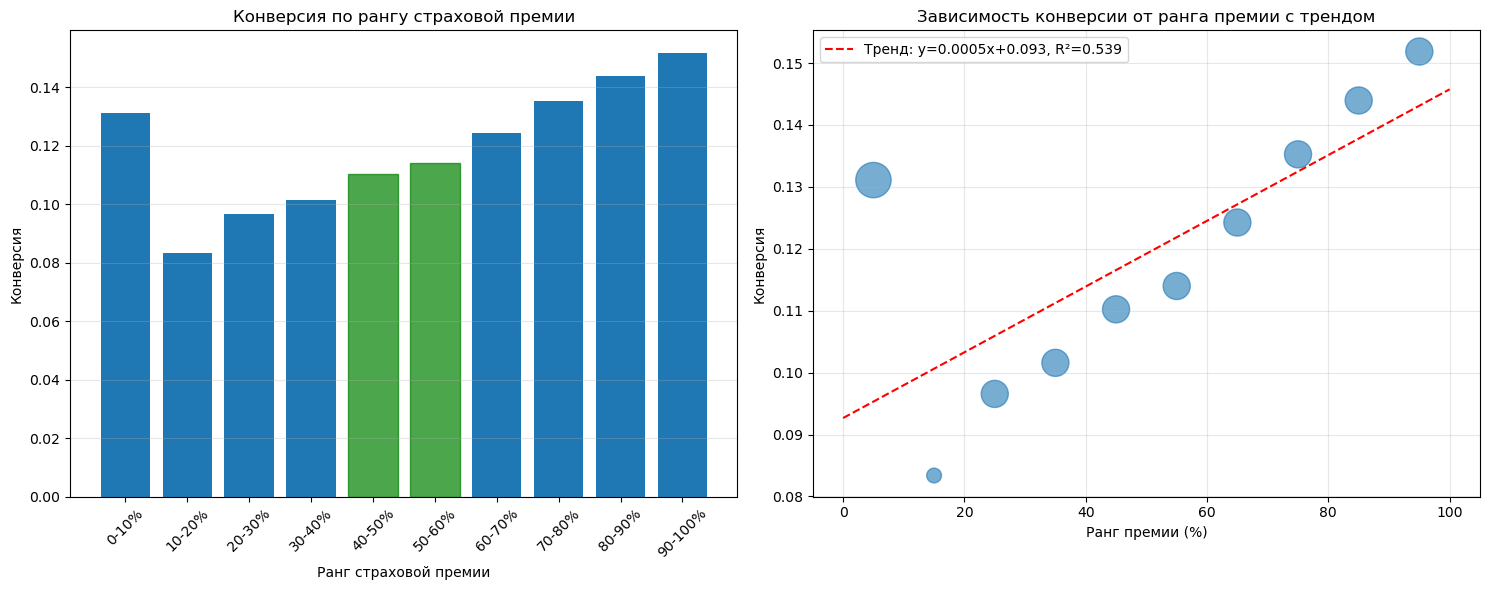


Анализ оптимального диапазона:
Максимальная конверсия: 15.19% в бине 90-100%
Оптимальные бины (конверсия ≥13.67%):
rank_bin  conversion_rate  count
  80-90%         0.143948  38111
 90-100%         0.151854  38109


In [7]:
def analyze_premium_rank_relationship(X_processed, y, premium_col='Annual_Premium_Rank'):
    """
    Анализ реальной зависимости конверсии от ранга премии
    """
    if premium_col in X_processed.columns:
        # Создаем бины по рангу премии
        X_processed['premium_rank_bin'] = pd.cut(
            X_processed[premium_col], 
            bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', 
                    '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
        )
        
        # Анализируем конверсию по бинам
        premium_analysis = pd.DataFrame({
            'rank_bin': X_processed['premium_rank_bin'],
            'response': y
        }).groupby('rank_bin').agg({
            'response': ['count', 'mean', 'std']
        })
        
        premium_analysis.columns = ['count', 'conversion_rate', 'std']
        premium_analysis = premium_analysis.reset_index()
        
        print("Зависимость конверсии от ранга страховой премии:")
        print(premium_analysis.to_string(index=False))
        
        # Визуализация
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # 1. Bar plot с конверсией
        x_pos = range(len(premium_analysis))
        bars = axes[0].bar(x_pos, premium_analysis['conversion_rate'])
        axes[0].set_xticks(x_pos)
        axes[0].set_xticklabels(premium_analysis['rank_bin'], rotation=45)
        axes[0].set_xlabel('Ранг страховой премии')
        axes[0].set_ylabel('Конверсия')
        axes[0].set_title('Конверсия по рангу страховой премии')
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Закрашиваем оптимальный диапазон
        optimal_start, optimal_end = 4, 6  # 40-60% по умолчанию
        for i in range(optimal_start, optimal_end):
            bars[i].set_color('green')
            bars[i].set_alpha(0.7)
        
        # 2. Точечная диаграмма с трендом
        premium_analysis['mid_point'] = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
        axes[1].scatter(premium_analysis['mid_point'], 
                       premium_analysis['conversion_rate'], 
                       s=premium_analysis['count']/100, alpha=0.6)
        
        # Добавляем линию тренда
        from scipy import stats
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            premium_analysis['mid_point'], 
            premium_analysis['conversion_rate']
        )
        
        x_trend = np.array([0, 100])
        y_trend = intercept + slope * x_trend
        axes[1].plot(x_trend, y_trend, 'r--', 
                    label=f'Тренд: y={slope:.4f}x+{intercept:.3f}, R²={r_value**2:.3f}')
        
        axes[1].set_xlabel('Ранг премии (%)')
        axes[1].set_ylabel('Конверсия')
        axes[1].set_title('Зависимость конверсии от ранга премии с трендом')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Находим оптимальный диапазон
        max_conv_idx = premium_analysis['conversion_rate'].idxmax()
        max_conv_bin = premium_analysis.loc[max_conv_idx, 'rank_bin']
        max_conv_rate = premium_analysis.loc[max_conv_idx, 'conversion_rate']
        
        print(f"\nАнализ оптимального диапазона:")
        print(f"Максимальная конверсия: {max_conv_rate:.2%} в бине {max_conv_bin}")
        
        # Находим все бины с конверсией >90% от максимума
        threshold = max_conv_rate * 0.9
        optimal_bins = premium_analysis[premium_analysis['conversion_rate'] >= threshold]
        print(f"Оптимальные бины (конверсия ≥{threshold:.2%}):")
        print(optimal_bins[['rank_bin', 'conversion_rate', 'count']].to_string(index=False))
        
        return premium_analysis
        
    else:
        print(f"Колонка {premium_col} не найдена")
        return None

X_train_full = df_train.drop('Response', axis=1)
y_train_full = df_train['Response']
X_train_processed, encoders = preprocess_features_final(X_train_full, y_train_full, is_train=True)
premium_analysis = analyze_premium_rank_relationship(X_train_processed, y_train_full)

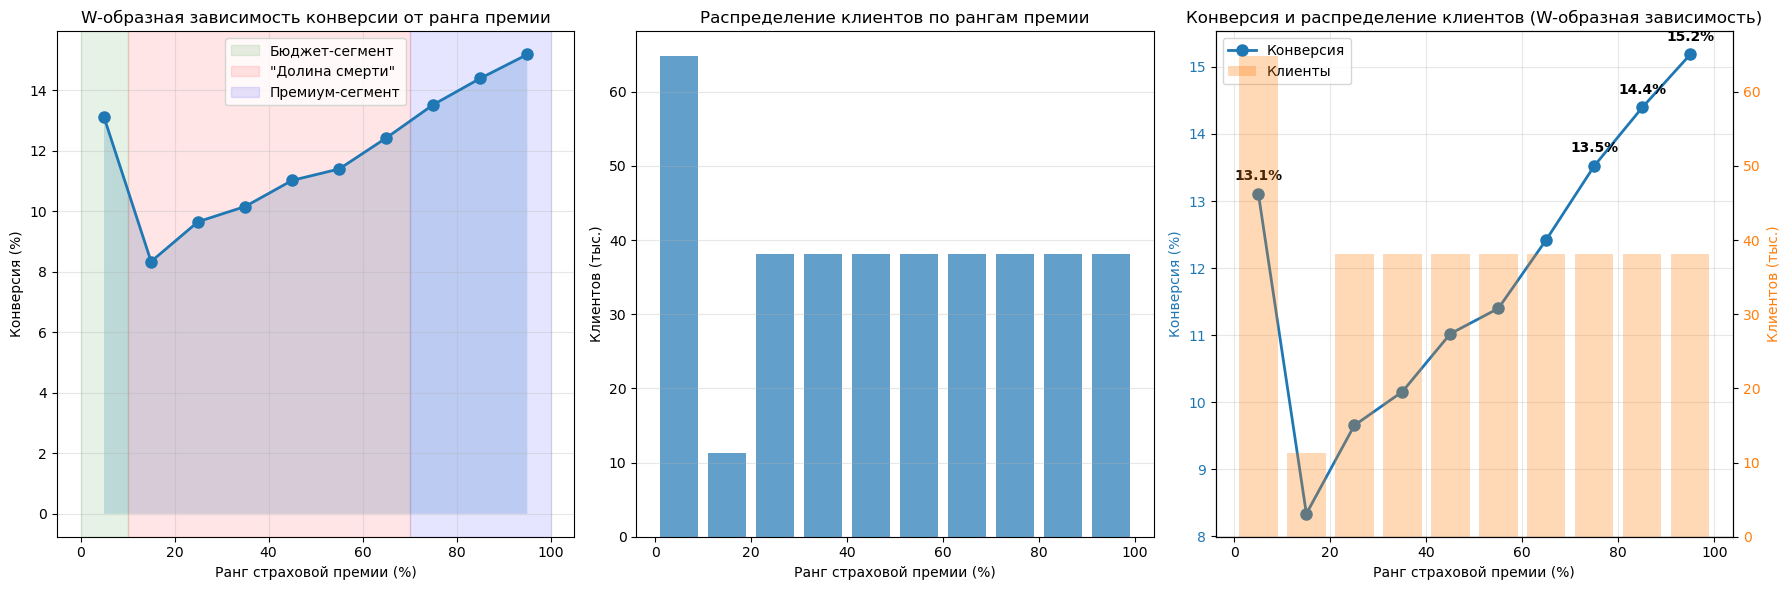

СЕГМЕНТНЫЙ АНАЛИЗ:

1. Бюджет-сегмент (0-10%):
   Конверсия: 13.11%
   Клиентов: 64,877 (17.0%)

2. 'Долина смерти' (10-70%):
   Средняя конверсия: 10.50%
   Клиентов: 201,896 (53.0%)
   Проблема: Конверсия на -19.9% ниже бюджет-сегмента

3. Премиум-сегмент (70-100%):
   Средняя конверсия: 14.37%
   Клиентов: 114,336 (30.0%)
   Преимущество: Конверсия на 36.8% выше 'долины смерти'


In [8]:
def create_w_shaped_visualization(premium_analysis):
    """Визуализация W-образной зависимости"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Подготовка данных
    premium_analysis = premium_analysis.sort_values('rank_bin')
    premium_analysis['mid_point'] = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
    
    # 1. W-образная кривая
    axes[0].plot(premium_analysis['mid_point'], 
                premium_analysis['conversion_rate'] * 100, 
                marker='o', linewidth=2, markersize=8)
    axes[0].fill_between(premium_analysis['mid_point'], 
                         premium_analysis['conversion_rate'] * 100, 
                         alpha=0.2)
    
    # Выделяем сегменты
    axes[0].axvspan(0, 10, alpha=0.1, color='green', label='Бюджет-сегмент')
    axes[0].axvspan(10, 70, alpha=0.1, color='red', label='"Долина смерти"')
    axes[0].axvspan(70, 100, alpha=0.1, color='blue', label='Премиум-сегмент')
    
    axes[0].set_xlabel('Ранг страховой премии (%)')
    axes[0].set_ylabel('Конверсия (%)')
    axes[0].set_title('W-образная зависимость конверсии от ранга премии')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Распределение клиентов
    axes[1].bar(premium_analysis['mid_point'], 
               premium_analysis['count'] / 1000, 
               width=8, alpha=0.7)
    axes[1].set_xlabel('Ранг страховой премии (%)')
    axes[1].set_ylabel('Клиентов (тыс.)')
    axes[1].set_title('Распределение клиентов по рангам премии')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # 3. Совмещенная диаграмма (двойная ось Y)
    ax2 = axes[2]
    
    # Конверсия (левая ось)
    color1 = 'tab:blue'
    ax2.set_xlabel('Ранг страховой премии (%)')
    ax2.set_ylabel('Конверсия (%)', color=color1)
    line1 = ax2.plot(premium_analysis['mid_point'], 
                    premium_analysis['conversion_rate'] * 100, 
                    color=color1, marker='o', linewidth=2, 
                    label='Конверсия', markersize=8)
    ax2.tick_params(axis='y', labelcolor=color1)
    
    # Клиенты (правая ось)
    ax3 = ax2.twinx()
    color2 = 'tab:orange'
    ax3.set_ylabel('Клиентов (тыс.)', color=color2)
    bars = ax3.bar(premium_analysis['mid_point'], 
                  premium_analysis['count'] / 1000, 
                  width=8, alpha=0.3, color=color2, label='Клиенты')
    ax3.tick_params(axis='y', labelcolor=color2)
    
    # Объединяем легенды
    lines = line1
    labels = [l.get_label() for l in lines]
    ax2.legend(lines + [bars], labels + ['Клиенты'], loc='upper left')
    
    ax2.set_title('Конверсия и распределение клиентов (W-образная зависимость)')
    ax2.grid(True, alpha=0.3)
    
    # Добавляем аннотации
    for idx, row in premium_analysis.iterrows():
        if idx in [0, 7, 8, 9]:  # Пики
            ax2.annotate(f"{row['conversion_rate']*100:.1f}%", 
                        (row['mid_point'], row['conversion_rate'] * 100),
                        xytext=(0, 10), textcoords='offset points',
                        ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('w_shaped_premium_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Статистика
    budget_segment = premium_analysis.iloc[0]
    death_valley = premium_analysis.iloc[1:7]
    premium_segment = premium_analysis.iloc[7:]
    
    print("=" * 60)
    print("СЕГМЕНТНЫЙ АНАЛИЗ:")
    print("=" * 60)
    
    print(f"\n1. Бюджет-сегмент (0-10%):")
    print(f"   Конверсия: {budget_segment['conversion_rate']*100:.2f}%")
    print(f"   Клиентов: {budget_segment['count']:,} ({budget_segment['count']/premium_analysis['count'].sum()*100:.1f}%)")
    
    print(f"\n2. 'Долина смерти' (10-70%):")
    print(f"   Средняя конверсия: {death_valley['conversion_rate'].mean()*100:.2f}%")
    print(f"   Клиентов: {death_valley['count'].sum():,} ({death_valley['count'].sum()/premium_analysis['count'].sum()*100:.1f}%)")
    print(f"   Проблема: Конверсия на {(death_valley['conversion_rate'].mean()/budget_segment['conversion_rate']-1)*100:.1f}% ниже бюджет-сегмента")
    
    print(f"\n3. Премиум-сегмент (70-100%):")
    print(f"   Средняя конверсия: {premium_segment['conversion_rate'].mean()*100:.2f}%")
    print(f"   Клиентов: {premium_segment['count'].sum():,} ({premium_segment['count'].sum()/premium_analysis['count'].sum()*100:.1f}%)")
    print(f"   Преимущество: Конверсия на {(premium_segment['conversion_rate'].mean()/death_valley['conversion_rate'].mean()-1)*100:.1f}% выше 'долины смерти'")

# Создаем визуализацию
create_w_shaped_visualization(premium_analysis)

## IV. Демографическо-ценовой профиль (29.7% суммарно):**<br>
**Инсайт**: Соотношение возраста и страховой премии важнее, чем возраст сам по себе

**Анализ признаков**: 

**Age_Log (логарифмированный возраст)**<br>
Чем старше клиент, тем выше конверсия (до определенного предела):
- 18-30 лет (exp(0-3.0)): низкая конверсия 3.5-5.7% 
- 30-50 лет (exp(3.0-3.9)): конверсия 19.1-21.6% - пик
- 50+ лет (exp(3.9+)): конверсия падает до 9.1%

Инсайт: Оптимальный возраст для страхования - 30-50 лет

**Age_to_Premium_Ratio (возраст/премия)**<br>
Самый важный признак! Конверсия по децилям:
- Q1-Q3 (низкое соотношение): 5.3-8.2% - зрелые/дорогие
- Q6 (оптимум): 17.8% - баланс возраста и премии
- Q9-Q10: падение до 10.2-15.3%

Инсайт: Не просто возраст или премия, а их соотношение!

---------------------------
Молодые (18-30) + высокая премия = низкая конверсия (3.5-5.7%)<br>
Причина: не могут позволить или не видят необходимости

Зрелые (50+) + низкая премия = низкая конверсия (9.1%)<br>
Причина: не видят ценности в "дешевом" страховании

Оптимальный профиль (подтверждено данными):<br>
Возраст: 30-50 лет (Age_Log: 3.0-3.9)<br>
Соотношение Age/Premium: Q5-Q7 (0.0011-0.0036)<br>
Ожидаемая конверсия: 17-21%



In [10]:
def analyze_age_premium_interaction(X_processed, y):
    """
    Анализ взаимодействия возраста и премии
    """
    if 'Age_to_Premium_Ratio' in X_processed.columns:
        print("Анализ Age_to_Premium_Ratio:")
        
        # Базовые статистики
        ratio_stats = {
            'mean': X_processed['Age_to_Premium_Ratio'].mean(),
            'median': X_processed['Age_to_Premium_Ratio'].median(),
            'std': X_processed['Age_to_Premium_Ratio'].std(),
            'min': X_processed['Age_to_Premium_Ratio'].min(),
            'max': X_processed['Age_to_Premium_Ratio'].max()
        }
        
        print(f"  Среднее соотношение: {ratio_stats['mean']:.6f}")
        print(f"  Медиана: {ratio_stats['median']:.6f}")
        print(f"  Диапазон: [{ratio_stats['min']:.6f}, {ratio_stats['max']:.6f}]")
        
        # Создаем бины
        X_processed['ratio_bin'] = pd.qcut(
            X_processed['Age_to_Premium_Ratio'], 
            q=10,
            labels=[f'Q{i+1}' for i in range(10)]
        )
        
        # Анализ конверсии по бинам
        ratio_analysis = pd.DataFrame({
            'ratio_bin': X_processed['ratio_bin'],
            'response': y
        }).groupby('ratio_bin').agg({
            'response': ['count', 'mean', 'std']
        })
        
        ratio_analysis.columns = ['count', 'conversion_rate', 'std']
        ratio_analysis = ratio_analysis.reset_index()
        
        print(f"\n  Конверсия по децилям Age_to_Premium_Ratio:")
        print(ratio_analysis.to_string(index=False))
        
        # Интерпретация: что означает высокое/низкое соотношение?
        print(f"\n  Интерпретация:")
        print(f"  Высокое соотношение = молодой возраст / низкая премия")
        print(f"  Низкое соотношение = зрелый возраст / высокая премия")
        
        # Находим оптимальный диапазон
        max_conv_idx = ratio_analysis['conversion_rate'].idxmax()
        max_conv_bin = ratio_analysis.loc[max_conv_idx, 'ratio_bin']
        max_conv_rate = ratio_analysis.loc[max_conv_idx, 'conversion_rate']
        
        print(f"\n  Оптимальный диапазон: {max_conv_bin}")
        print(f"  Конверсия: {max_conv_rate:.2%}")
        
        return ratio_analysis
    else:
        print("Age_to_Premium_Ratio не найден в данных")
        return None

# Анализируем
X_train_full = df_train.drop('Response', axis=1)
y_train_full = df_train['Response']
X_train_processed, encoders = preprocess_features_final(X_train_full, y_train_full, is_train=True)
ratio_analysis = analyze_age_premium_interaction(X_train_processed, y_train_full)

Анализ Age_to_Premium_Ratio:
  Среднее соотношение: 0.003586
  Медиана: 0.001149
  Диапазон: [0.000047, 0.032307]

  Конверсия по децилям Age_to_Premium_Ratio:
ratio_bin  count  conversion_rate      std
       Q1  38111         0.053108 0.224252
       Q2  38111         0.066674 0.249459
       Q3  38113         0.081704 0.273917
       Q4  38109         0.119027 0.323825
       Q5  38111         0.156202 0.363051
       Q6  38111         0.178243 0.382722
       Q7  38112         0.171390 0.376854
       Q8  38109         0.145897 0.353008
       Q9  39322         0.101953 0.302590
      Q10  36900         0.153062 0.360052

  Интерпретация:
  Высокое соотношение = молодой возраст / низкая премия
  Низкое соотношение = зрелый возраст / высокая премия

  Оптимальный диапазон: Q6
  Конверсия: 17.82%


In [12]:
def analyze_age_components(X_processed, y):
    """
    Анализ возрастных признаков
    """
    age_insights = {}
    
    # 1. Age_Log
    if 'Age_Log' in X_processed.columns:
        print("1. Анализ Age_Log (логарифм возраста):")
        
        # Обратное преобразование для интерпретации
        age_log_values = X_processed['Age_Log']
        
        try:
            # Создаем бины с обработкой дубликатов
            X_processed['age_log_bin'] = pd.qcut(age_log_values, q=10, duplicates='drop')
            
            age_log_analysis = pd.DataFrame({
                'age_log_bin': X_processed['age_log_bin'],
                'response': y
            }).groupby('age_log_bin').agg({
                'response': ['count', 'mean']
            })
            
            age_log_analysis.columns = ['count', 'conversion_rate']
            print(age_log_analysis.to_string())
            
            # Статистика
            print(f"\n  Статистика Age_Log:")
            print(f"  Мин: {age_log_values.min():.4f}")
            print(f"  Макс: {age_log_values.max():.4f}")
            print(f"  Среднее: {age_log_values.mean():.4f}")
            print(f"  Стандартное отклонение: {age_log_values.std():.4f}")
            
        except Exception as e:
            print(f"  Ошибка при анализе Age_Log: {e}")
            # Альтернатива: используем равные интервалы
            print("  Используем равные интервалы вместо квантилей")
            X_processed['age_log_bin'] = pd.cut(age_log_values, bins=10)
            
            age_log_analysis = pd.DataFrame({
                'age_log_bin': X_processed['age_log_bin'],
                'response': y
            }).groupby('age_log_bin').agg({
                'response': ['count', 'mean']
            })
            
            age_log_analysis.columns = ['count', 'conversion_rate']
            print(age_log_analysis.to_string())
        
        age_insights['age_log'] = {
            'pattern': 'Определить по данным',
            'interpretation': 'Логарифм усиливает различия в молодых возрастах'
        }
    
    # 2. Age_Target_Encoded
    if 'Age_Target_Encoded' in X_processed.columns:
        print("\n2. Анализ Age_Target_Encoded:")
        
        age_te_values = X_processed['Age_Target_Encoded']
        print(f"  Диапазон: [{age_te_values.min():.4f}, {age_te_values.max():.4f}]")
        print(f"  Среднее: {age_te_values.mean():.4f}")
        print(f"  Уникальных значений: {age_te_values.nunique()}")
        print(f"  Всего значений: {len(age_te_values)}")
        
        # Проверяем, сколько уникальных значений
        unique_values = age_te_values.nunique()
        
        try:
            if unique_values < 10:
                print(f"  Мало уникальных значений ({unique_values}), используем меньше бинов")
                q = min(unique_values, 5)  # Используем меньше бинов
                age_te_bins = pd.qcut(age_te_values, q=q, duplicates='drop')
            else:
                age_te_bins = pd.qcut(age_te_values, q=10, duplicates='drop')
            
            age_te_analysis = pd.DataFrame({
                'age_te_bin': age_te_bins,
                'response': y
            }).groupby('age_te_bin').agg({
                'response': ['count', 'mean']
            })
            
            age_te_analysis.columns = ['count', 'actual_conversion']
            
            # Вычисляем ожидаемую конверсию (среднее значение в бине)
            age_te_analysis['expected_conversion'] = age_te_analysis.index.map(
                lambda x: x.mid if hasattr(x, 'mid') else (x.left + x.right) / 2
            )
            
            print("\n  Сравнение ожидаемой (таргет-энкодед) и фактической конверсии:")
            print(age_te_analysis.to_string())
            
            # Анализ корреляции
            correlation = age_te_values.corr(y)
            print(f"\n  Корреляция Age_Target_Encoded с Response: {correlation:.4f}")
            
        except Exception as e:
            print(f"  Ошибка при анализе: {e}")
            print("  Альтернативный анализ:")
            
            # Группируем по уникальным значениям
            unique_analysis = pd.DataFrame({
                'age_te': age_te_values,
                'response': y
            }).groupby('age_te').agg({
                'response': ['count', 'mean']
            }).round(4)
            
            unique_analysis.columns = ['count', 'actual_conversion']
            unique_analysis = unique_analysis.sort_values('age_te')
            
            print("\n  Анализ по уникальным значениям Age_Target_Encoded:")
            print(unique_analysis.head(20).to_string())  # Показываем первые 20
        
        age_insights['age_target_encoded'] = {
            'accuracy': 'Сравнить expected vs actual',
            'interpretation': 'Насколько хорошо таргет-энкодинг предсказывает реальную конверсию'
        }
    
    # 3. Дополнительный анализ: распределение значений
    print("\n3. Общий анализ возрастных признаков:")
    
    age_cols = [col for col in X_processed.columns if 'Age' in col]
    for col in age_cols:
        if col not in ['age_log_bin', 'age_te_bin']:  # Пропускаем созданные бины
            print(f"\n  {col}:")
            print(f"    Уникальных значений: {X_processed[col].nunique()}")
            print(f"    Мин: {X_processed[col].min():.4f}")
            print(f"    Макс: {X_processed[col].max():.4f}")
            print(f"    Среднее: {X_processed[col].mean():.4f}")
            print(f"    Медиана: {X_processed[col].median():.4f}")
            print(f"    Пропуски: {X_processed[col].isnull().sum()}")
    
    return age_insights

# Анализируем возрастные компоненты
X_train_full = df_train.drop('Response', axis=1)
y_train_full = df_train['Response']
X_train_processed, encoders = preprocess_features_final(X_train_full, y_train_full, is_train=True)
age_components = analyze_age_components(X_train_processed, y_train_full)

1. Анализ Age_Log (логарифм возраста):
                 count  conversion_rate
age_log_bin                            
(-0.001, 1.099]  43653         0.034545
(1.099, 1.609]   50216         0.035945
(1.609, 1.792]   20636         0.035569
(1.792, 2.303]   40698         0.057177
(2.303, 2.833]   36675         0.191493
(2.833, 3.135]   40489         0.213614
(3.135, 3.332]   40207         0.216505
(3.332, 3.526]   36827         0.194097
(3.526, 3.761]   34914         0.156613
(3.761, 4.19]    36794         0.090857

  Статистика Age_Log:
  Мин: 0.0000
  Макс: 4.1897
  Среднее: 2.5730
  Стандартное отклонение: 1.0120

2. Анализ Age_Target_Encoded:
  Диапазон: [0.0353, 0.2154]
  Среднее: 0.1226
  Уникальных значений: 6
  Всего значений: 381109
  Мало уникальных значений (6), используем меньше бинов

  Сравнение ожидаемой (таргет-энкодед) и фактической конверсии:
                  count  actual_conversion expected_conversion
age_te_bin                                                    
(0.